# Project 4 - Part 2 Twitter Data

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import json
import pytz
import datetime
import numpy as np


import re
import collections
from collections import Counter
import time

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import os.path
import random

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

In [3]:
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gorkemcamli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
%matplotlib inline

In [5]:
pd.set_option("display.notebook_repr_html", True)

In [6]:
rand_seed = 42
np.random.seed(rand_seed)
random.seed(rand_seed)

#### Read Data

In [7]:
repo_name = 'ECE219_tweet_data/'
file_names= ['tweets_#gohawks.txt',
             'tweets_#gopatriots.txt',
             'tweets_#nfl.txt',
             'tweets_#patriots.txt',
             'tweets_#sb49.txt',
             'tweets_#superbowl.txt'
]

df_names = []
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    df_names.append(file_name_key)

In [8]:
def read_txt_file(fname):
    "takes too long for the last sb49 and superbowl txt files"
    with open(fname) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']
    df_inter['json_element'].apply(json.loads)
    df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))    
    return df_final

def read_txt_file2(fname):
    "read line by line and get only what you need for Q27 and Q28"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['citation_date'].append(tweet['citation_date'])
            df_dict['retweet_count'].append(tweet['metrics']['citations']['total']) 
            df_dict['followers_count'].append(tweet['author']['followers'])

    df_final = pd.DataFrame(df_dict)
    return df_final

def read_txt_file3(fname):
    "read line by line and get only what you need for Q29"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['tweet.text'].append(tweet['tweet']['text'])
            df_dict['citation_date'].append(tweet['citation_date']) 
            df_dict['tweet.lang'].append(tweet['tweet']['lang'])
            df_dict['tweet.user.name'].append(tweet['tweet']['user']['name']) 
            df_dict['original_author.name'].append(tweet['original_author']['name']) 
            df_dict['tweet.favorite_count'].append(tweet['tweet']['favorite_count'])
            df_dict['tweet.retweet_count'].append(tweet['tweet']['retweet_count'])
            df_dict['metrics.citations.total'].append(tweet['metrics']['citations']['total']) 
            df_dict['metrics.impressions'].append(tweet['metrics']['impressions']) 
            df_dict['tweet.user.followers_count'].append(tweet['tweet']['user']['followers_count']) 
            df_dict['tweet.user.friends_count'].append(tweet['tweet']['user']['friends_count']) 
            df_dict['tweet.user.favourites_count'].append(tweet['tweet']['user']['favourites_count']) 

    df_final = pd.DataFrame(df_dict)
    return df_final
            

In [9]:
TIME_ZONE = 'US/Pacific'
PST_TZ = pytz.timezone(TIME_ZONE) # PST time zone 

## Question 27

__Report the following statistics for each hashtag, i.e. each file.__

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


Since the time to read all files were taking,I solved this issue by reading files line by line and then only saving the columns I need for the questions 27 and 28. Below we can see the shape of each dataframe created for all 6 files:

In [10]:
tweet_dfs = {}
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    tweet_dfs[file_name_key] = read_txt_file2(fname=repo_name+file_name)
    print(file_name_key, tweet_dfs[file_name_key].shape)
    #display(tweet_dfs[file_name_key].head(3))

gohawks (169122, 4)
gopatriots (23511, 4)
nfl (233022, 4)
patriots (440621, 4)
sb49 (743649, 4)
superbowl (1213813, 4)


In [11]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    cur_df['citation_date_fixed'] = cur_df.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(x, PST_TZ)) 
    cur_df[new_cols] = cur_df.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    cur_df['citation_date_rounded_hour']= cur_df.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
  

__Average number of tweets per hour:__ 
For the stats questions, the average number of tweets per hour can be defined different ways:

1 - Find number of tweets tweeted all the hours in data set, take their average.

2 - Total number of tweets / (Number of hours within the textfile's min and max date)

For these definitions the results can differ if there are hour timeframes where no tweet has been posted. (2) definition takes into account the hours that have no tweet, (1) does not. For example if the within the data timeframes there are 100 hours but 2 hours have no twitter post, (2) divides the total tweets by 100, however (1) divides by 98. The second approach makes more sense and accurate, and I choose this as definition. But since the question is not clear on which definition we are expected to go I include both of them

__Average number of followers of users posting the tweets per tweet:__ Mean of followers_count column (['author']['followers'])

__Average number of retweets per tweet:__ Mean of retweet_count column ( ['metrics']['citations']['total']) as every row represent a tweet.

In [12]:
def avg_tweet_per_hour(df):
    cols_group = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    return df.groupby(by=cols_group).title.count().mean()

def avg_tweet_per_hour2(df):
    dur = (df['citation_date_fixed'].max()-df['citation_date_fixed'].min())
    num_hours = dur.days * 24 + dur.seconds / 3600.0
    res = df['title'].count() /num_hours
    return res

def avg_num_followers(df):
    '''
    Average number of followers of users posting the tweets per tweet 
    (to make it simple, we average over the number of tweets; 
    if a users posted twice, we count the user and the user’s followers twice as well)
    '''
    avg_followers = df['followers_count'].mean()
    return avg_followers

def avg_retweet_per_tweet(df):
    return df['retweet_count'].mean()

In [13]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    
    print(f'\n\n--- Stats for #{df_name} ---')
    avg_twt = avg_tweet_per_hour(cur_df)
    print('Average # tweet per hour (definition 1:)', round(avg_twt,3))
    
    avg_twt2 = avg_tweet_per_hour2(cur_df)
    print('Average # tweet per hour (definition 2:)', round(avg_twt2,3))
    
    
    avg_flws = avg_num_followers(cur_df)
    print('Average # followers', round(avg_flws,3))
    
    avg_retweet_per_twt = avg_retweet_per_tweet(cur_df)
    print('Average # retweet per tweet', round(avg_retweet_per_twt,3))



--- Stats for #gohawks ---
Average # tweet per hour (definition 1:) 296.705
Average # tweet per hour (definition 2:) 292.488
Average # followers 2217.924
Average # retweet per tweet 2.013


--- Stats for #gopatriots ---
Average # tweet per hour (definition 1:) 53.313
Average # tweet per hour (definition 2:) 40.955
Average # followers 1427.253
Average # retweet per tweet 1.408


--- Stats for #nfl ---
Average # tweet per hour (definition 1:) 399.695
Average # tweet per hour (definition 2:) 397.021
Average # followers 4662.375
Average # retweet per tweet 1.534


--- Stats for #patriots ---
Average # tweet per hour (definition 1:) 750.632
Average # tweet per hour (definition 2:) 750.894
Average # followers 3280.464
Average # retweet per tweet 1.785


--- Stats for #sb49 ---
Average # tweet per hour (definition 1:) 1384.821
Average # tweet per hour (definition 2:) 1276.857
Average # followers 10374.16
Average # retweet per tweet 2.527


--- Stats for #superbowl ---
Average # tweet per ho

## Question 28

__Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.__

In [14]:
def plot_num_tweet_per_hour(df, df_name, x_ticks_freq=10):
    cols = ['citation_date_rounded_hour']
    gp_df = pd.DataFrame(df.groupby(by=cols).title.count())
    gp_df.sort_index(inplace=True)
    #gp_df.reset_index(inplace=True)
    gp_df.rename(columns={'title':'tweet_count_per_hour'}, inplace=True)
    
    ax = gp_df.plot(kind='bar',figsize=(30,7), rot=90)
    plt.title(f'{df_name.title()} Bar Plot for Number of Tweets in hour over time', fontsize=30)
    ax.set_ylabel('Tweet Count Per Hour', fontsize=25)
    ax.set_xlabel('Citation Date', fontsize=25)
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text()[:-9] for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::x_ticks_freq])
    ax.xaxis.set_ticklabels(ticklabels[::x_ticks_freq], fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    plt.show()
    
    


Plots below show the number of tweets in hour for #superbowl and #nfl data in 1-hour bins. X axis ticks shows the corresponding day and hour for that bin. Since there are many bins and corresponding ticks for them to make the plot less crowded, I showed xticks in every 20 hours.

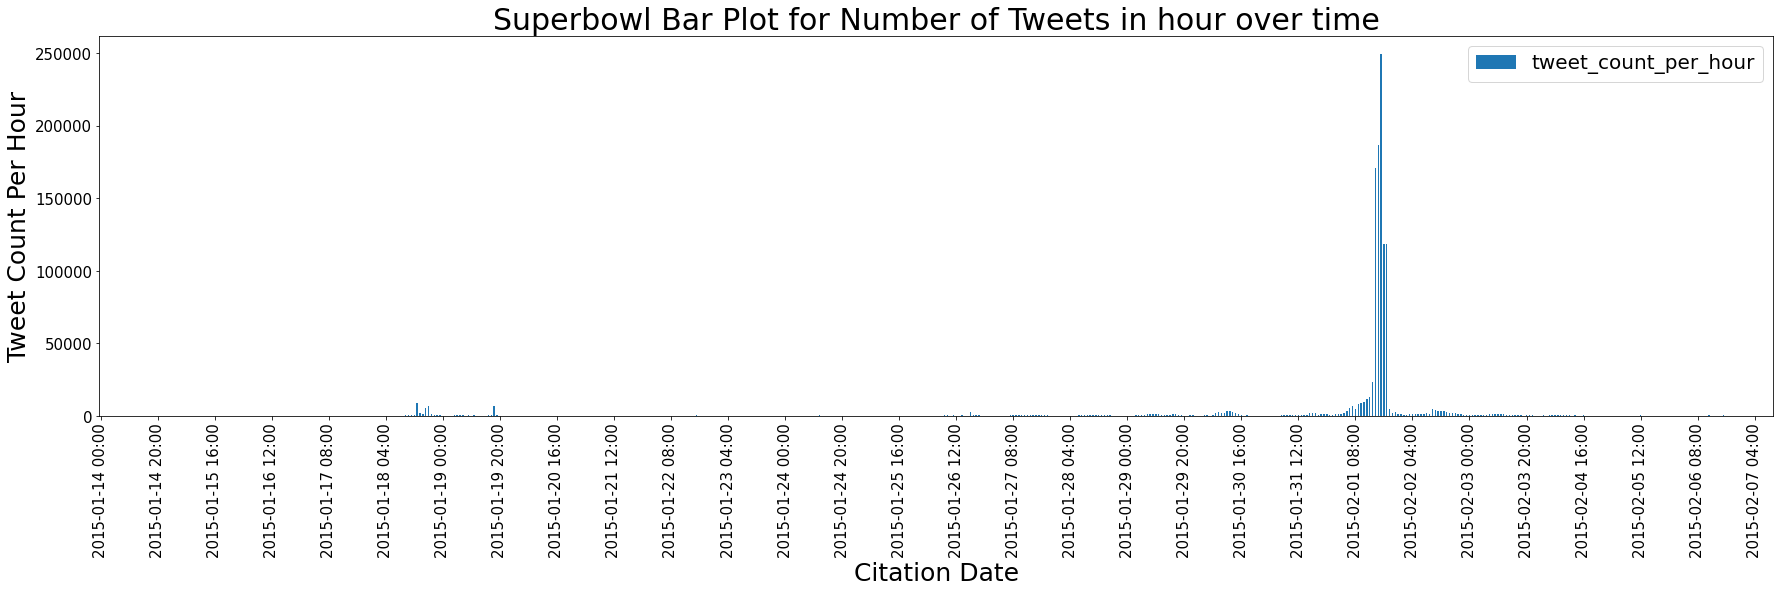

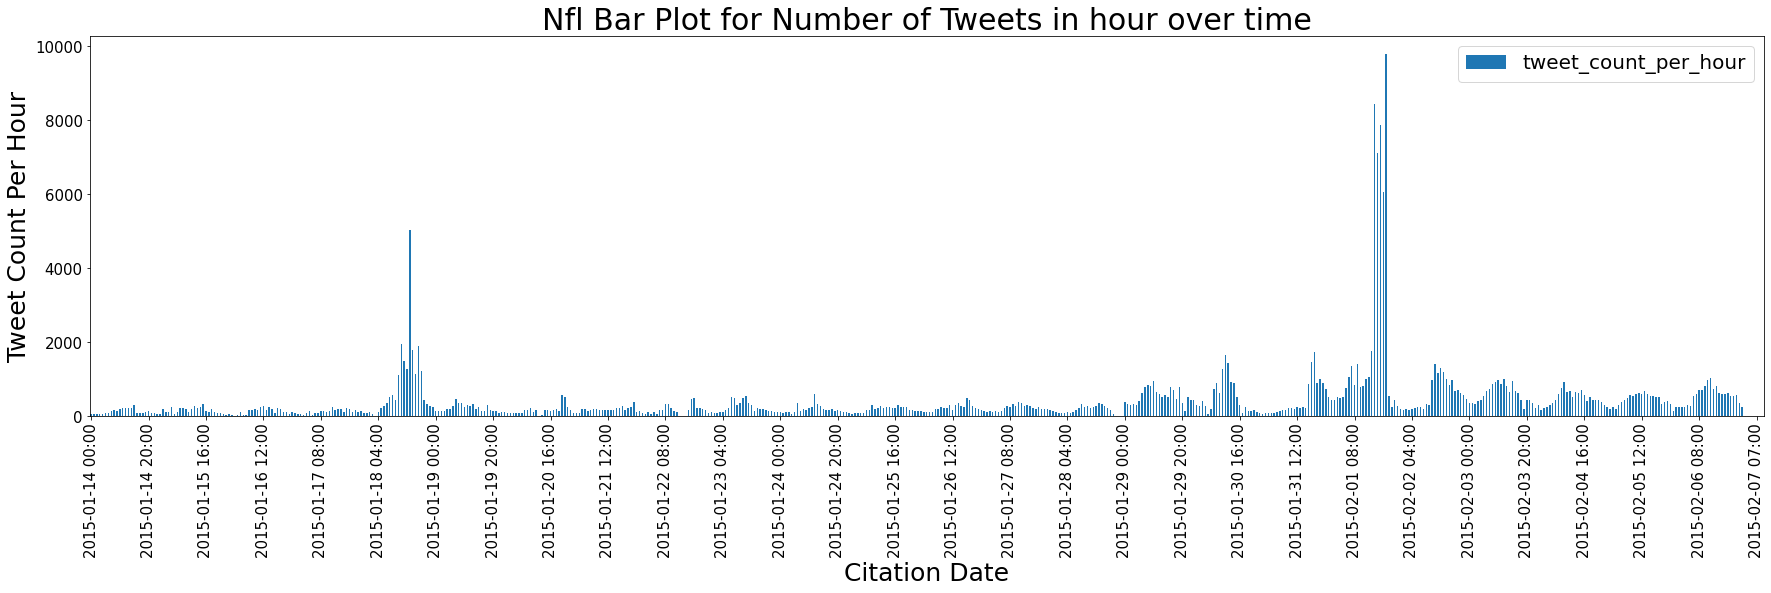

In [15]:
for df_name in ['superbowl','nfl']:
    cur_df = tweet_dfs[df_name]
    plot_num_tweet_per_hour(cur_df, df_name, x_ticks_freq=20)

For superbowl hashtag we can see that the peak is in Feb 1st 2015 on the superbowl 49 game day. For nfl the biggest peak is again on superbowl day, Feb 1st but there are also smaller peaks happening on other days, which probably also corresponds game days. For example the first small peak, on Jan 18 2015 corresponds the day where Packers and Seahawks have game. 

## Question 29

### Task Explanation

Follow the steps outlined below: 

- Describe your task.
- Explore the data and any metadata (you can even incorporate additional datasets if you choose).
- Describe the feature engineering process. Implement it with reason: Why are you extracting features this way - why not in any other way?
- Generate baselines for your final ML model.
- A thorough evaluation is necessary.
- Be creative in your task design - use things you have learned in other classes too if you are excited about them!

__Intro & Task Description:__

In this question, I did character-centric time series tracking and a winner prediction task:

- Character-centric Time-Series Tracking part, intends to understand how tweet emotions changing during the Superbowl 49 game for hawks and patriots, as well as for American Football players playing in the game. So thee question I want to answer "Can we track the average perceived emotion across tweets about each player in the game across time in each fan base? Can we correlate these emotions with the game score in the given time interval?". 

- Winner Prediction Task:  Given tweet emotions expressed to players within a time window, can we predict who is winning the superbowl 49 in that time window? The emotions about player or the team is aggregated based on 1-minute time intervals. So, given the perceived emotion in any minute in the game, who is leading the game, the answer could be Tie, Patriots or Seahawks. I will do 3 class classification task with different emotion features on 3 models (Logistic Regression, Random Forest, Neural Networks -simple MLP-). 

These two tasks are not trivial to solve. 
In the raw data:
- There is no information on which tweet belongs what player.
- There is no information about players or the game.
- We only have timestamp for tweets but we need to map these to the game time where significant events such as score occurs.
- There is no label for the prediction task. We don't know the game status in the tweets data.

In the next sections Data Exploration and Feature Engineering, I explained in details how I tackled these problems.

__Data Used:__

- '#gopatriots.csv', '#patriots.csv' and '#gohawks.csv' files.
-  Additional data: 
    - Players information: I collected team player names, positions, position category information for Patriots and Seahawks team members who played at Superbowl 49.  
    - Game information: I used the score plays information to extract relative score times from tweets and label which team is the leading the game (patriots, seahawks, tie) when a tweet posted.

    - Emotion data: 
        I used 4 different emotion feature set extracted from different libraries/models: __Nltk.sentiment.vader, TextBlob, CardiffNLP Roberta and AllenNLP Roberta.__
        I did both tasks with 4 set of features and compared the feature results as well. I chose nltk.sentiment.vader and Textblob as the baseline features, the features extracted with these methods are rather simple. Nltk vader[1] and Textblob are both rule-based sentiment analysis approaches. Whereas sentiment features extracted from Roberta (Robustly Optimized BERT Pre-training Approach) Models use advanced NLP deep learning models which promises better emotion features. CardiffNLP is especially interesting because it is pretrained on Twitter dataset.   



### __Data Preparation__

##### __Set GAME_START and GAME_END times__

In [16]:
# set naive datetime correctly
# (Add timezone to a naive datetime) from : https://medium.com/@eleroy/10-things-you-need-to-know-about-date-and-time-in-python-with-datetime-pytz-dateutil-timedelta-309bfbafb3f7

GAME_START = datetime.datetime(2015, 2, 1, 15, 30, 0, 0)
GAME_START = PST_TZ.localize(GAME_START)

GAME_END = datetime.datetime(2015, 2, 1, 19, 6, 0, 0)
GAME_END = PST_TZ.localize(GAME_END)
print('GAME_START',GAME_START)
print('GAME_END',GAME_END)

GAME_START 2015-02-01 15:30:00-08:00
GAME_END 2015-02-01 19:06:00-08:00


##### Helper functions

(to prepare data  extract features, feature engineering and prepare the dataset to be used in the tasks)

In [17]:
def read_q29_raw_data():
    tweet_dfs2 = {}
    for file_name in ['tweets_#gohawks.txt','tweets_#gopatriots.txt', 'tweets_#patriots.txt']:
        file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
        tweet_dfs2[file_name_key] = read_txt_file3(fname=repo_name+file_name)
        print(file_name_key, tweet_dfs2[file_name_key].shape)
        #display(tweet_dfs[file_name_key].head(3))

    tweet_dfs2['gohawks']['hashtag'] = '#gohawks'
    tweet_dfs2['gopatriots']['hashtag'] = '#gopatriots'
    tweet_dfs2['patriots']['hashtag'] = '#gopatriots'
    return tweet_dfs2

In [18]:
def clean_mentions_links(text):
    # clean mentions and links
    # mention count, link count, hashtag count
    
    mention_count = 0
    hashtag_count = 0
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        if t.startswith('@') and len(t) > 1:
            mention_count+=1
        if t.startswith('#') and len(t) > 1:
            hashtag_count+=1
            
        t = '' if t.startswith('@') and len(t) > 1 else t #'@user'
        t = '' if t.startswith('http') else t  #'http' 
        new_text.append(t)
    return [" ".join(new_text), mention_count, hashtag_count]

def clean_hashtag(text):
    # clean hashtag
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        t = '' if t.startswith('#') and len(t) > 1 else t #'@user'
        new_text.append(t)
    return " ".join(new_text)


def find_players_listed_in_tweet(tweet):
    players = []
    tweet_lower = tweet.lower()
    for player in list(players_df.Player.unique()):
        player_lower = player.lower()
        player_first, player_last = player_lower.split(' ')[0], player_lower.split(' ')[-1]
        
        if player_lower in tweet_lower or player_first in tweet_lower or player_last in tweet_lower:
            players.append(player)
    return None if not players else players

def game_interval(twt_time):
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < GAME_END:
        return 'during_game'
    else:
        return 'after_game'


In [19]:
def assign_nltk_sentiment_label(compound):
    # reference: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    label=None
    if compound >= 0.05:
        label='positive'
    elif (compound > -0.05) & (compound <0.05):
        label='neutral'
    else:
        label='negative'
    return label

def nltk_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_nltk_vader_'
    col_names = [prefix+'neg'+post_fix, prefix+'neu'+post_fix,prefix+'pos'+post_fix,prefix+'compound'+post_fix]
    
    if col_names[-1] in data.columns:
        return data
    else:
        sia = SentimentIntensityAnalyzer()
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(sia.polarity_scores(x)))
        data['sent_nltk_vader_label'+post_fix] =  data['sent_nltk_vader_compound'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data

def textblob_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_textblob_'
    col_names = [prefix+'polarity'+post_fix, prefix+'subjectivity'+post_fix]

    if col_names[0] in data.columns:
        return data
    else:
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(TextBlob(x).sentiment))
        data[prefix+'label'+post_fix] =  data[prefix+'polarity'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data


In [20]:
def date_time_fix(data):
    # prep posting time
    print('Starting posting time datetime features...')
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    data['citation_date_fixed'] = data.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(int(x), PST_TZ)) 
    data[new_cols] = data.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    data['citation_date_rounded_hour']= data.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
 
    return data

def prep_tweet_emotion_data(tweet_dfs2):
    fname = 'data/tweet_emt_df.csv'
    #print('Creating tweet_dfs2...')
    #tweet_dfs2 = read_q29_raw_data()
    if os.path.isfile(fname):
        tweet_emt_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        return tweet_emt_df
    else:  
        # create tweet_emt_df
        print('Starting tweet_emt_df...')
        cols = ['hashtag','title', 'tweet.text', 'citation_date','tweet.lang', 'tweet.user.name', 'original_author.name',
                'tweet.retweet_count','tweet.favorite_count','metrics.citations.total', 'metrics.impressions',
                'tweet.user.followers_count','tweet.user.friends_count','tweet.user.favourites_count',
               # 'author.followers','original_author.followers','original_author.influence_level', 'metrics.ranking_score', 
               # 'metrics.citations.influential',,'metrics.citations.replies',,'author.influence_level'
            ]
    
        # english tweets only
        tweet_dfs2['gohawks'] =  tweet_dfs2['gohawks'][tweet_dfs2['gohawks']['tweet.lang']=='en'] # english tweets only
        tweet_dfs2['gopatriots'] =  tweet_dfs2['gopatriots'][tweet_dfs2['gopatriots']['tweet.lang']=='en'] # english tweets only
        tweet_dfs2['patriots'] =  tweet_dfs2['patriots'][tweet_dfs2['patriots']['tweet.lang']=='en'] # english tweets only
        
        tweet_emt_df = pd.concat([tweet_dfs2['gohawks'][cols], tweet_dfs2['gopatriots'][cols], tweet_dfs2['patriots'][cols]])
        tweet_emt_df = tweet_emt_df.sort_values(by='citation_date')
        #tweet_emt_df = tweet_emt_df[tweet_emt_df['tweet.lang']=='en'] # english tweets only

        # prep posting time
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        
        # clean mentions and links
        #print('Starting cleaning title...')
        #tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

        # find players for each tweet 
        print('Starting find players...')
        tweet_emt_df['player'] = tweet_emt_df['tweet.text'].apply(lambda x: find_players_listed_in_tweet(tweet=x))
        tweet_emt_df['player_count'] = tweet_emt_df['player'].apply(lambda x: 0 if not x else len(x))
        tweet_emt_df['players_str'] = tweet_emt_df['player'].apply(lambda x: ', '.join(x) if x else '')
        tweet_emt_df['player2'] = tweet_emt_df['players_str'].astype(str).apply(lambda x:  'general' if x=='nan' or x=='' else x.split(',')[0])
        tweet_emt_df['player2'] = tweet_emt_df.apply(lambda x:  x['hashtag'] if x['player2']=='general' else x['player2'], axis=1)

        
        # create game status
        print('Starting game status...')
        tweet_emt_df['game_status'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval(twt_time=x))
        
        # nltk vader sentiment to title
        print('Starting nltk vader sentiment...')
        tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name='title')
        
        # textblob sentiment to title
        print('Starting textblob sentiment...')
        tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name='title')
                
        # write to not keep repeating same process
        tweet_emt_df.to_csv(fname)
        print(f'Saved file to {fname}...')
        tweet_emt_df.head(5)
        
        return tweet_emt_df
    

In [21]:
def create_players_data():
    fname = 'data/players_df.csv'
    if os.path.isfile(fname):
        players_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        return players_df
    else:
        players_df = pd.read_csv('data/sb 49 - players.csv')
        display(players_df.head(10).T)

        positions_df = pd.read_csv('data/sb 49 - positions.csv')
        display(positions_df.head(10).T)

        res = players_df.merge(positions_df, left_on='Pos', right_on='Abbreviation' , how='left')
        display(res.sample(10).T)

        res['player_first_name'] = res.Player.apply(lambda x: x.split(' ')[0])
        res['player_last_name']= res.Player.apply(lambda x: x.split(' ')[-1])
        res = res[res.espn_team_list==True]
        res.to_csv(fname)
        return res


#### __Prepare Twitter Data and Additional data__

To be able to create the tasks mentioned above, I need to first prepare the data, but some of the informations I need is not available within the Twitter dataset provided.

- Find Extra data:
    - Finding players data for each team
    - Finding game related scores, and significant events


##### __Players Data__

I used players and american football positions data found from below resources. I also crosschecked the team players info from espn website and added the missing players. Also, I realized that some players such as Dan Connolly didn't play in 2015 superbowl 49 (according to ESPN), so I created a new column espn_team_list to keep track of the players who played/not played in SB49.

References:
- players data: https://www.pro-football-reference.com/boxscores/201502010sea.htm#all_team_stats
- positions data: https://www.rookieroad.com/football/positions/position-abbreviations/

The final combined players table preview:

In [22]:
players_df = create_players_data()
print(players_df.shape)
display(players_df[['Player', 'Pos', 'Team', 'espn_team_list', 'Abbreviation', 'Position',
       'Category']].head(5))

(39, 9)


Player Pos      Team  espn_team_list Abbreviation       Position  \
0       Tom Brady  QB  Patriots            True           QB    Quarterback   
1    Shane Vereen  RB  Patriots            True           RB   Running Back   
2  Brandon LaFell  WR  Patriots            True           WR  Wide Receiver   
3  Julian Edelman  WR  Patriots            True           WR  Wide Receiver   
4  Rob Gronkowski  TE  Patriots            True           TE      Tight End   

  Category  
0  Offense  
1  Offense  
2  Offense  
3  Offense  
4  Offense

##### __Raw Tweet Data__

Read gohawks, go patriots and patriots data.

In [23]:
print('Creating tweet_dfs2...')
tweet_dfs2 = read_q29_raw_data()

Creating tweet_dfs2...
gohawks (169122, 13)
gopatriots (23511, 13)
patriots (440621, 13)


Language distribution of the tweets for top 8 language:
(und:undecided)

In [24]:
print('gohawks\n')
display( pd.DataFrame(tweet_dfs2['gohawks']['tweet.lang'].value_counts(normalize=True)).head(8).T)
print('gopatriots\n')
display(pd.DataFrame(tweet_dfs2['gopatriots']['tweet.lang'].value_counts(normalize=True)).head(8).T)
print('patriots\n')
display(pd.DataFrame(tweet_dfs2['patriots']['tweet.lang'].value_counts(normalize=True)).head(8).T)


gohawks



en       und        es        pt        de        fr  \
tweet.lang  0.841801  0.119198  0.011104  0.008976  0.003737  0.001963   

                  ja        tl  
tweet.lang  0.001904  0.001898

gopatriots



en      und        es        pt       de        fr  \
tweet.lang  0.547999  0.18234  0.129131  0.089107  0.00906  0.008166   

                  ht        it  
tweet.lang  0.005614  0.004211

patriots



en       und        es        pt        fr        de  \
tweet.lang  0.898008  0.048788  0.029399  0.005792  0.004142  0.002921   

                  ht        in  
tweet.lang  0.001441  0.001203

Given that we will do sentiment analysis task, I will only use english language tweets.


##### __Create Project Data__

We need to incorporate the newly collected data with the tweets data. This is not a trivial step as we need to know (1) if a tweet is about a specific player, (2) mapping game time to real time.
(1) is handled in this section and (2) has its own specific part since it is more complex.    

In this step I prepared the final raw data to be used in the above described tasks:

Steps followed to prepare this data:
- Select features from raw tweet data
- Filter to have english language only
- Concat gohawks and gopatriots data in a single dataframe, put hashtag column to later use to separate them.
- Handle date time information for citation_date column.
- Game Status: create a column to specify when the tweet is posted: 'pre-game, during game' and 'after game'
- Map tweets and players
- Sentiment Analysis 
	- Nltk Vader
	- Textblob
	- CardiffNLP Roberta
	- AllenNLP Roberta

Further details for some of the above steps:

__Selected features from raw tweets data:__

['title', 'tweet.text', 'citation_date','hashtag', 'tweet.lang']


__Date time:__

Twitter raw data has citation_date column as the tweet post time. This column values are in the form of UNIX time as a scalar number. I first convert this column to a human-readable format using datetime and converted the timezone to PST time zone. I also used PST time zone for significant times in the game such as game start and end time to be able to easily filter out tweets during game time. I also created additional year, month, day, hour columns for convenience.


__Find if a tweet about a specific player:__

In order to make a character-centric tracking we need to know whether a tweet is related to a player. There are several ways we can see a tweet could be related to a player: if tweet text mentions the player, uses hashtag about player and use the name of the player. 

I used a simple logic with full name and partial name to match to find tweets about players. The results are case insensitive. By doing this I can identify players for 15% of the tweet data with 1 or more than 1 players out of 551K tweets. So, around 83K of tweets are matched with at least 1 player. 
This could be further improved by finding twitter usernames of the players (for mentions) and specific hashtags used for players. However, most of these already contains either full, first or last name of the players meaning most of these case would be handled already with the current logic. Several columns created: player (list of the players found), player_count (number of players identified in a tweet), player2 (same as player but with team names for tweets no player found).

What will happen to the remaining 85% of the tweets? Well, since I didn't want to discard them directly I assigned team names to the tweets that I couldn't find specific players. 

__Sentiment Analysis:__

For sentiment analysis, we need sentiment information. 4 different approach used to extract sentiment information: nltk, textblob, CardiffNLP Roberta and AllenNLP Roberta. With nltk.vader, I found positive, negative, neutral and compound scores for each tweet. Assigned the labels using compound score. With TextBlob, I extracted polarity and sensitivity information and assigned the label using polarity information. CardiffNLP I extracted positive, neutral, negative scores and label. With AllenNLP, I extracted positive and negative scores as well as label. Since roberta model results don't have a compound score, I used the positive scores as the feature set (lower positive score would correspond negative emotion).

For the character centric analysis, we need to aggregate these emotion values, for each character and time interval. I described those steps in the later sections. I experimented extracting sentiment information with both cleaned and uncleaned tweets, the change in the results were insignificant. I shared them later in the notebook. Also, applying these steps take considerable time, in order to not rerun the same things over and over, I saved the final df and reread when I restart working.

__Preview of the project data:__

In [25]:
tweet_emt_df = prep_tweet_emotion_data(tweet_dfs2=tweet_dfs2)
print(tweet_emt_df.shape)
tweet_emt_df[['hashtag', 'title']].head(3)

Starting posting time datetime features...
(550932, 72)


hashtag                                              title
0     #gohawks  “@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...
1     #gohawks  Dr. Jim Kurtz &amp; I before Seahawks vs Panth...
2  #gopatriots  NFL PLAYOFFS: Brady throws 3 TDs in win over R...

### __Data Exploration & Feature Engineering__

##### __Answer some questions__

- __Check if data is balanced for each team?__

In [26]:
print(tweet_emt_df.hashtag.value_counts())
tweet_emt_df.hashtag.value_counts(normalize=True)

#gopatriots    408565
#gohawks       142367
Name: hashtag, dtype: int64


#gopatriots    0.741589
#gohawks       0.258411
Name: hashtag, dtype: float64

We have highly inbalanced data, gopatriots tweets corresponds to the 74% of the data. 

- __Find in how many tweets each player is mentioned?__

In [27]:
dd = pd.DataFrame(tweet_emt_df.groupby(by=['player2']).title.count())
dd = dd.sort_values(by='title', ascending=False)
dd.head(50)

title
player2                     
#gopatriots           357785
#gohawks              115377
Tom Brady              32383
Russell Wilson          8710
Rob Gronkowski          5395
Marshawn Lynch          4845
Richard Sherman         4314
Chris Matthews          2753
Julian Edelman          2439
Earl Thomas             2130
LeGarrette Blount       1948
Doug Baldwin            1541
Darrelle Revis          1342
Kam Chancellor          1010
Vince Wilfork            949
Brandon LaFell           868
Michael Hoomanawanui     737
Jermaine Kearse          646
Bryan Walters            585
Chandler Jones           507
Danny Amendola           491
Jamie Collins            471
Tony McDaniel            430
Kyle Arrington           405
Shane Vereen             394
Kevin Williams           367
Bruce Irvin              316
Brandon Browner          255
Bobby Wagner             237
Cliff Avril              191
Devin McCourty           163
Patrick Chung            163
K.J. Wright              141
Dont'a Hightower         132
Ricardo Lockette         122
Michael Bennett          118
Byron Maxwell             88
Rob Ninkovich             71
DeShawn Shead             57
Sealver Siliga            45
Robert Turbin             11

- __What is the ratio of number of players found on tweet dataset?__

Show player_count column's normalized  value counts.

In [28]:
tweet_emt_df.player_count.value_counts(normalize=True)

0     0.858839
1     0.116221
2     0.018329
3     0.005231
4     0.001049
5     0.000231
6     0.000069
7     0.000015
8     0.000011
9     0.000004
10    0.000002
Name: player_count, dtype: float64

##### __Cleaning Tweets:__



I did a minimum cleaning on the tweets to experiment on whether text cleaning will further change the emotions distributions for tweets, and help with the model performances.

Cleaned title column: cleans the links and mentions from the tweet. Make all characters lower case.

Cleaned hashtag title column: in addition to links and mentions, also cleans the hashtags from the tweet. Make all characters lower case.


In [29]:
# clean title
tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

In [30]:
tweet_emt_df['cleaned_hashtag_title'] = tweet_emt_df.cleaned_title.apply(lambda x: clean_hashtag(x))

#### __Creating Sentiment Scoring and Label Features__

##### __nltk.sentiment.vader__

As my first baseline sentiment analysis score approach, I used nltk.sentiment.vader.

VADER stands for Valence Aware Dictionary for Sentiment Reasoning. Vader is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion and one can apply Vader model directly to unlabeled text to get scores for negative, neutral and positive sentiments. Nltk.sentiment.vader also provides a compound score: "is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

To assign positive, neutral and negative labels, I used the compound score and recommended thresholds in the nltk documentaion: https://github.com/cjhutto/vaderSentiment#about-the-scoring

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

I applied Vader model to raw tweets data, cleaned_title and cleaned_hashtag_title columns. 
When we grouped and check what the ratios for each label, I don't see any huge shift in the overall distribution in emotion for the raw vs cleaned tweets.

In [31]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_nltk_vader_label_'+twt_feature_name].value_counts(normalize=True))

title


positive    0.610240
neutral     0.280111
negative    0.109649
Name: sent_nltk_vader_label_title, dtype: float64

cleaned_title


positive    0.610313
neutral     0.280203
negative    0.109484
Name: sent_nltk_vader_label_cleaned_title, dtype: float64

cleaned_hashtag_title


positive    0.609850
neutral     0.280681
negative    0.109469
Name: sent_nltk_vader_label_cleaned_hashtag_title, dtype: float64

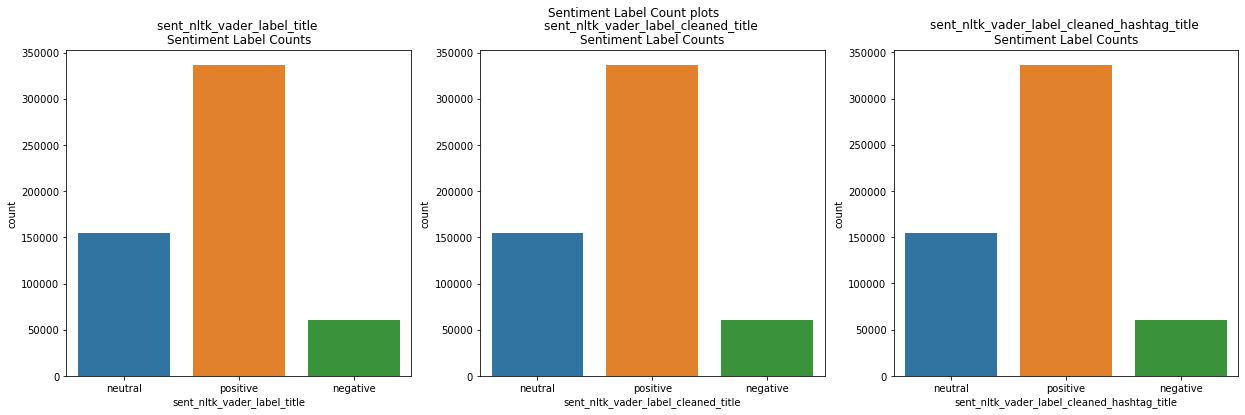

In [32]:
for ft, s in zip(['sent_nltk_vader_label_'], ['Label']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Count plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.countplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
    plt.show()

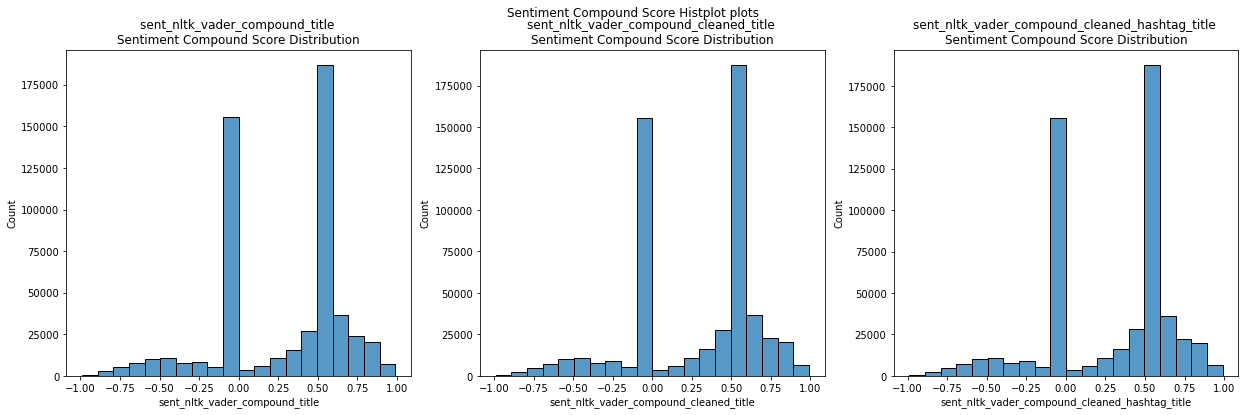

In [33]:
for ft, s in zip(['sent_nltk_vader_compound_'], ['Compound Score']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Histplot plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.histplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind, bins=20)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
    plt.show()

We can see that majority of the labels assigned to positive tag, 60-61%. The compound score has two peaks one at 0 and the other at around 0.5. 

##### __TextBlob sentiment__

In [34]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_textblob_label_'+twt_feature_name].value_counts(normalize=True))

title


positive    0.569557
neutral     0.320936
negative    0.109507
Name: sent_textblob_label_title, dtype: float64

cleaned_title


positive    0.569103
neutral     0.321288
negative    0.109609
Name: sent_textblob_label_cleaned_title, dtype: float64

cleaned_hashtag_title


positive    0.564556
neutral     0.326089
negative    0.109355
Name: sent_textblob_label_cleaned_hashtag_title, dtype: float64

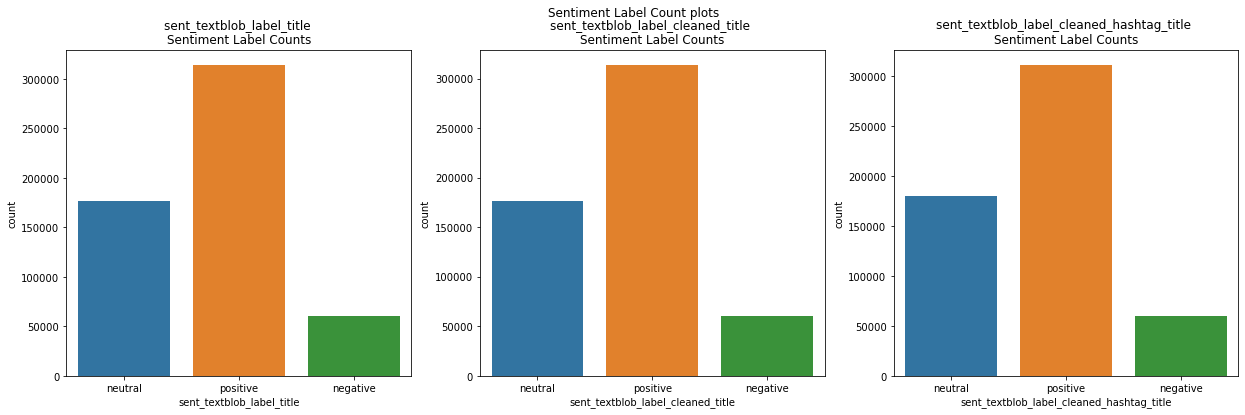

In [35]:
for ft, s in zip(['sent_textblob_label_'], ['Label']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Count plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.countplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
    plt.show()

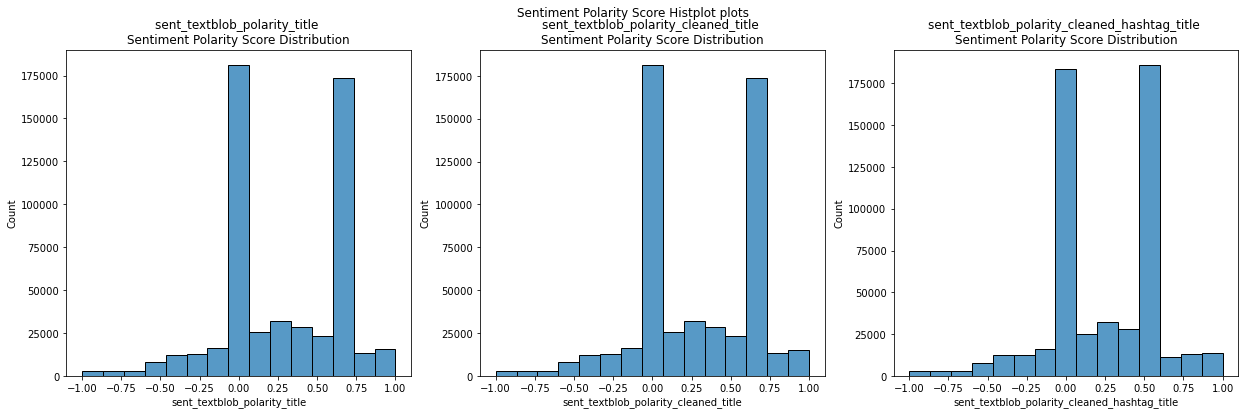

In [36]:
for ft, s in zip(['sent_textblob_polarity_'], ['Polarity Score']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Histplot plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.histplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind, bins=15)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
    plt.show()

We can see that majority of the labels assigned positive label again, but percentage of positive labels are lower compared to nltk. The polarity distribution is similar to Nltk as it has 2 main peaks, though nltk seems to assign higher scores on positive tweets whereas in this one 0.0-0.75 range has higher bars.

In [37]:
tweet_emt_df.to_csv('data/tweet_emt_df.csv')

##### __Cardiff NLP Roberta sentiment__ 


The code I used to extract features with CardiffNLP Roberta model is in another notebook called "P4_Roberta.ipynb".

I already extracted the sentiment scores and label from CardiffNLP Roberta using mentioned notebook and saved the results in a csv file. This model is particularly interesting because it is pretrained on Twitter dataset, which I am expecting to see more accurate sentiment score results. 4 columns extracted: positive, neutral, negative scores and label. Since model didn't provide a compounds score I used the positive score in the tracking and prediction task.

I only extracted features for the tweets posted during SB49 game, approx. 90K tweets. Otherwise I have around half million tweets and it was taking too much time to extract them. Also, all my exploration will be mainly focused during game, so this is the most essential information I needed for character-centric time-series tracking and my prediction task. As I didn't see any radical sentiment score changes with the cleaning tweet, I extracted the sentiment results for cleaned_title column only.



In [38]:
def cardiff_nlp_roberta_sentiment(data, tweet_feature_name='cleaned_title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_cardiff_nlp_roberta_'

    if 'sent_cardiffnlp_roberta_neg_cleaned_title' in data.columns:
        return data
    else:
        # read cardiff data
        cardiff = pd.read_csv('data/during_game_only_with_cardiffnnlp_roberta.csv', index_col=0, lineterminator='\n')
    
        # merge data frames
        cs = ['index',  'title', 
            'sent_cardiffnlp_roberta_neg_cleaned_title','sent_cardiffnlp_roberta_neut_cleaned_title',
            'sent_cardiffnlp_roberta_pos_cleaned_title','sent_cardiffnlp_roberta_label_cleaned_title'
        ]
        small_card = cardiff[cs]
        data = data.merge(small_card, how='left', on=['index','title'])
        
        # check
        #tweet_emt_df[(~tweet_emt_df.sent_cardiffnlp_roberta_pos_cleaned_title.isnull()) &
        #    (tweet_emt_df.game_status == 'during_game')].shape[0]
        
        # save data frame
        data.to_csv('data/tweet_emt_df.csv')
    return data
    
tweet_emt_df = cardiff_nlp_roberta_sentiment(data=tweet_emt_df, tweet_feature_name='cleaned_title')

In [39]:
display(tweet_emt_df['sent_cardiffnlp_roberta_label_cleaned_title'].value_counts(normalize=True))

positive    0.597334
neutral     0.267315
negative    0.135350
Name: sent_cardiffnlp_roberta_label_cleaned_title, dtype: float64

Positiive labels again takes the majority of the tweets. We have the lowest neutral label percentage and the highest negative percentage within the 3 first methods. This is a good indication that the extracted features have more polarity.

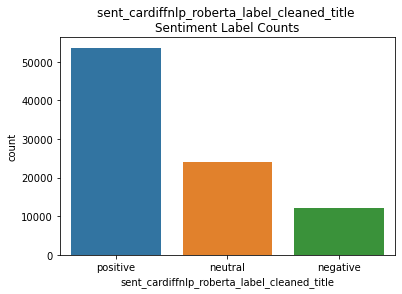

In [40]:
ft= 'sent_cardiffnlp_roberta_label_'
s= 'Label'
twt_feature_name = 'cleaned_title'
ax = plt.Figure(figsize=(6,6))
sns.countplot(tweet_emt_df[ft+twt_feature_name])
plt.title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
plt.show()

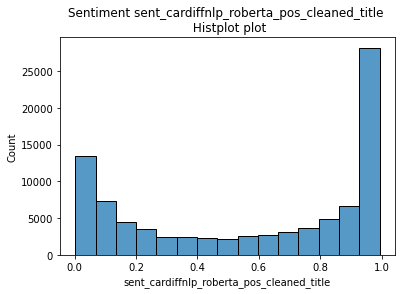

In [41]:
cols = ['sent_cardiffnlp_roberta_neg_cleaned_title','sent_cardiffnlp_roberta_neut_cleaned_title',
            'sent_cardiffnlp_roberta_pos_cleaned_title']
tweet_emt_df['sent_cardiffnlp_roberta_max_score_cleaned_title'] = tweet_emt_df[cols].max(axis=1)
ax = plt.Figure(figsize=(6,6))
ft = 'sent_cardiffnlp_roberta_pos_cleaned_title'
sns.histplot(tweet_emt_df[ft], bins=15)
plt.title(f'Sentiment {ft} \n Histplot plot')
plt.show()

We see there is a lot of tweets that assigned either 1 or very close to 1, and the second peak is towards 0. The polarity between both sides are the most significant so far with the CardiffNLP features. 

##### __Allen NLP Roberta sentiment__ 

The code I used to extract features with AllenNLP Roberta model is in another notebook called "P4_Roberta.ipynb".
I already extracted the sentiment scores and label from AllenNLP Roberta using that notebook and saved the results in a csv file. I expect to have an accurate results and good features from this model too. I extracted positive and negative scores and labels.

Similar to CardiffNLP, I only extracted features for the tweets posted during SB49 game and only on cleaned_title. Otherwise I have around half million tweets and it was taking too much time to extract them. 

In [42]:
def allen_nlp_roberta_sentiment(data, tweet_feature_name='cleaned_title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_allen_nlp_roberta_'
    
    if 'sent_allennlp_roberta_neg_cleaned_title' in data.columns:
        return data
    else:
        # read cardiff data
        allen = pd.read_csv('data/during_game_only_with_allennlp_roberta.csv', index_col=0, lineterminator='\n')
    
        # merge data frames
        cs = ['index',  'title', 'sent_allennlp_roberta_pos_cleaned_title',
              'sent_allennlp_roberta_neg_cleaned_title','sent_allennlp_roberta_label_cleaned_title']
        small_all = allen[cs]
        data = data.merge(small_all, how='left', on=['index','title'])
        
        # check
        #tweet_emt_df[(~tweet_emt_df.sent_cardiffnlp_roberta_pos_cleaned_title.isnull()) &
        #    (tweet_emt_df.game_status == 'during_game')].shape[0]
        
        # save data frame
        data.to_csv('data/tweet_emt_df.csv')
    return data
    
tweet_emt_df = allen_nlp_roberta_sentiment(data=tweet_emt_df, tweet_feature_name='cleaned_title')

In [43]:
display(tweet_emt_df['sent_allennlp_roberta_label_cleaned_title'].value_counts(normalize=True))

positive    0.758964
negative    0.241036
Name: sent_allennlp_roberta_label_cleaned_title, dtype: float64

This is a bit harder to compare with other 3 methods as it doesn't have neutral label. Neutral labels in previous features seem to be shared with positive and negative labels. We see the highest negative tweet percentage in all 4 methods.

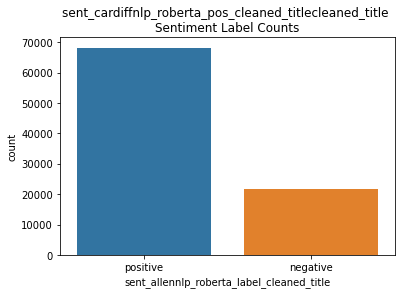

In [44]:
s= 'Label'
twt_feature_name = 'cleaned_title'
ax = plt.Figure(figsize=(6,6))
sns.countplot(tweet_emt_df['sent_allennlp_roberta_label_cleaned_title'])
plt.title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
plt.show()

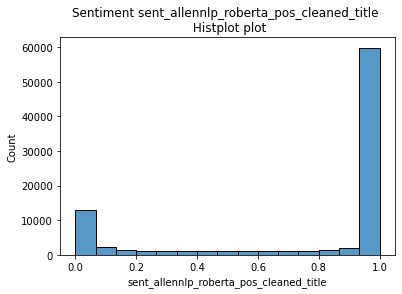

In [45]:
ax = plt.Figure(figsize=(6,6))
ft = 'sent_allennlp_roberta_pos_cleaned_title'
sns.histplot(tweet_emt_df[ft], bins=15)
plt.title(f'Sentiment {ft} \n Histplot plot')
plt.show()

The polarity is even higher in here. This is a bit concerning, because 75% of the tweets are assigned positive and there the distribution for lower scores seem almost flat and very low. The emotion information for lower scored tweets, might have almost no effect when we aggregate them and get lost within positive scores. Also, it is very interesting that CardiffNLP Roberta and AllenNLP Roberta results are very different even in terms of disitribution. Both provides more polarity and less neutral emotion, but the distribution in CardiffNLP one seems to be more varied whereas AllenNLP one is mostly seem flat except 0 and 1.

##### __Explore Sentiments Examples:__

In [46]:
import textwrap

In [47]:
sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_pos', 
              'sent_allennlp_roberta_pos'] 

for st in sent_feats:
    xf = st+'_cleaned_title'
    
    print(f'{st} Top 3 Positive Titles')
    dfx = tweet_emt_df.sort_values(by=[xf], ascending=False)
    for i in range(3):
        titl = dfx['cleaned_title'].values[i]
        scr = dfx[xf].values[i]
        print(f'Ex {i+1}: Score: {scr} - Tweet: {textwrap.fill(titl,50)} ')
    print('\n')

sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_neg', 
              'sent_allennlp_roberta_neg'] 

for st in sent_feats:
    xf = st+'_cleaned_title'
    print(f'{st} Top 3 Negative Titles')
    if 'neg' in st:
        dfx = tweet_emt_df.sort_values(by=[xf], ascending=False)
    else:
        dfx = tweet_emt_df.sort_values(by=[xf], ascending=True)
    for i in range(3):
        titl = dfx['cleaned_title'].values[i]
        scr = dfx[xf].values[i]
        print(f'Ex {i+1}: Score: {scr} - Tweet: {textwrap.fill(titl,50)} ')
    print('\n')

sent_nltk_vader_compound Top 3 Positive Titles
Ex 1: Score: 0.9906 - Tweet: #patriots win. wow wow wow wow wow wow wow omg wow
wow. #superbowl 
Ex 2: Score: 0.987 - Tweet: yesssss, #patriots #win #superbowi !!! great game,
great #halftimeshowkatyperry great sunday!! :-)
happy, happy, happy!! :-) :-) :-) 
Ex 3: Score: 0.9843 - Tweet: congratulations  you deserve/earn it! you won!
brady the best! god bless! peace &amp; love! xoxo!
#patriots #brady #superbowl2015!!! 


sent_textblob_polarity Top 3 Positive Titles
Ex 1: Score: 1.0 - Tweet: happy friday!! #seahawks #superbowlxlix #gohawks
#nfl #seagals #deflategate 💙💚 
Ex 2: Score: 1.0 - Tweet: best dressed #seahawksfan on #superbowlsunday?
done and done.  #gohawks #12fan #beastmode 
Ex 3: Score: 1.0 - Tweet:   a perfect topper to my day. glorious. #gohawks 


sent_cardiffnlp_roberta_pos Top 3 Positive Titles
Ex 1: Score: 0.99376816 - Tweet: i love you so much! thank you for this amazing
experience!  #blessed #gohawks #seahawks
#12thcouple…

Examples mostly seem to make sense.  Also some of the examples are extremely small or complicated to predict. For example: Nltk.vader's first negative example: 'hell of a game. hell of a finish. hell of an adjustment. hell of a fight. hell of a comeback. hell of a situation. hell of a team. #gohawks ' might be wrongly predicted. Depending on what time of the game it is posted this could be interpreted as either positive or negative. 

#### __Mapping Game Time to Real Time:__

There are 3 main time information we need to find:
1. Categorize tweets as pre, during and after game.
2. Find quarter and halftime show beginning and end times. 
3. Find score times.
4. Find significant event times (interceptions, fumbles).

One of the biggest challenge I had is to map the real time with the game time. Game scores and significant events data available on the internet is relative to the game time such as first touch down is happend in second quarter 9:47 (example: https://www.espn.com/nfl/playbyplay/_/gameId/400749027 check all plays and scoring plays table). However, tweets are based on real time. 

Unfortunately, game clock isn't kept counting down continuously during game. Even though game is considered 1 hour with each quarter 15 minutes, I realized that the actual game took generally 2-3 hours. In the superbowl 49 case, it took 3h 36 minutes as written on the internet. Hence, I need to find a way to map the game time and real time where tweets are written.

I tried several things on how to assign time frames. My first approach was to find timestamps of the game (either significant event or scores), but after hours of search it lead me nowhere:

- I couldn't find any data online that is relative to real timestamps like PST, UTC on neither on quarter start and end, nor for significant or score times. Every play by play and score play data I found were on relative to the game time shown minutes within quarters. 

- Checked youtube videos of the full game, to extract times manually, either by checking time on the screen or find it relative from video time. In full game video, there is no real time shown on the screen and I realized that the video was shortened where halftime shows removed, so that didn't helped either on mapping the game time to real time.

- I tried to find timestamps from the tweets of official twitter accounts of Seattle Seahawks and Patriots. I check both dataset and then twitter but the tweets from there limited and you can't infer any of the information completely.
- Final resort: refer score and quarter times from tweet dataset. Assumption: if a tweet with score is tweeted than either one of the team is already scored, use the earliest one within the game timeframe.

- As a last resort, I decided to extract the score times and quarter times from the tweets. 

PS: I skipped the (4) Find significant event times (interceptions, fumbles), since there is no fumbles in the game and finding interceptions from tweets both very difficult and not very reliable.

##### __1. Categorize tweets as pre, during and after game:__

We already know the game start time 3:30 PST and how long game lasted 3 hours 36 min. By using start and game end time we  can assign pre-game, during game and after game tags to each tweet. The distribution of game status can be seen below:

In [48]:
tweet_emt_df.game_status.value_counts()

pre_game       408154
during_game     89804
after_game      52974
Name: game_status, dtype: int64

In [49]:
tweet_emt_df.game_status.value_counts(normalize=True)

pre_game       0.740843
during_game    0.163004
after_game     0.096153
Name: game_status, dtype: float64

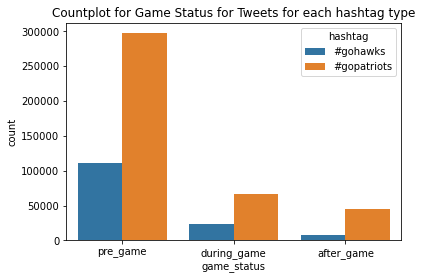

In [50]:
game_status_categories = ['pre_game', 'during_game','after_game']
plt.Figure(figsize=(10,10))
sns.countplot(data=tweet_emt_df, x='game_status', hue='hashtag', order=game_status_categories)
plt.title('Countplot for Game Status for Tweets for each hashtag type')
plt.show()

Most of the tweets were posted before game, so American Football fans, especially Patriots and SeaHawks are really fans and they watch the game during game, instead of posting tweet about it.

Distribution of tweets by each fan and game status:

In [51]:
tweet_emt_df.groupby(by=['hashtag', 'game_status']).title.count()

hashtag      game_status
#gohawks     after_game       7761
             during_game     23706
             pre_game       110900
#gopatriots  after_game      45213
             during_game     66098
             pre_game       297254
Name: title, dtype: int64

##### __2.1. Finding Quarter Times:__



To go one step further, I used the tweet information to find approximate quarter times. 

For each quarter, I checked the tweets that has 'end of' and quarter name in the same tweet. 
For example for first quarter, I filtered out only tweets that has 'end of' and either '1st quarter' or 'first quarter' substrings.

The results are not too many, so I manually checked the meanings and assigned the earliest tweet that refers to the end of quarter. In this case, the results are driven from users and approximate, but the best mapping I could find.

In [52]:
# find the relative time frames for each quarter
quarter_strs = ['first quarter|1st quarter','second quarter|2nd quarter', 'third quarter|3rd quarter', 'fourth quarter|4th quarter']
cs = ['title','citation_date_fixed']

for qs in quarter_strs:
    print(f'Looking matches for {qs} ...')
    display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('end of')) &
                (tweet_emt_df['tweet.text'].str.contains(qs)) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)][cs])

Looking matches for first quarter|1st quarter ...


title  \
425143  0-0 at the end of the first quarter. #Seahawks...   
425148  #SB49 end of first quarter. #Seattle 0 #Patrio...   
425264  At the end of the first quarter the game is ti...   
425289  It's scoreless between the #Patriots & #Seahaw...   
425291  At the end of the 1st quarter, score is 0-0! #...   
425560  At the end of a speedy first quarter, #SuperBo...   
425561  At the end of a speedy first quarter, #SuperBo...   
425589  And thatâs the end of the 1st quarter. 0-0. ...   
425611  Alright, whoever had 0-0 at the end of the 1st...   
425722  At the end off the first quarter yhe score is ...   
425867  At the end of the 1st quarter Seattle #Seahawk...   
426071  And that’s the end of the 1st quarter. 0-0 #Se...   
426073  And that’s the end of the 1st quarter. 0-0 #Se...   
426609  0 0 end of 1st quarter #SuperBowlXLIX who gonn...   
433033  I lasted until the end of the 1st quarter unti...   

             citation_date_fixed  
425143 2015-02-01 15:58:08-08:00  
425148 2015-02-01 15:58:09-08:00  
425264 2015-02-01 15:58:26-08:00  
425289 2015-02-01 15:58:29-08:00  
425291 2015-02-01 15:58:29-08:00  
425560 2015-02-01 15:59:02-08:00  
425561 2015-02-01 15:59:02-08:00  
425589 2015-02-01 15:59:05-08:00  
425611 2015-02-01 15:59:08-08:00  
425722 2015-02-01 15:59:25-08:00  
425867 2015-02-01 15:59:52-08:00  
426071 2015-02-01 16:00:28-08:00  
426073 2015-02-01 16:00:28-08:00  
426609 2015-02-01 16:01:52-08:00  
433033 2015-02-01 16:13:03-08:00

Looking matches for second quarter|2nd quarter ...


title  \
444742  agreement btwn #Seahawks &amp; #Patriots: make...   
461206  @DJAelita @TheFaithBreaker 14 - 14 at the end ...   
468326  I swear the #SB49 is paid to win.. We were pla...   
476059  #patriots have to show the same guts the #Seat...   
538569  Last play last nite was a bad call cuz it didn...   

             citation_date_fixed  
444742 2015-02-01 16:35:29-08:00  
461206 2015-02-01 17:09:09-08:00  
468326 2015-02-01 17:46:58-08:00  
476059 2015-02-01 18:11:09-08:00  
538569 2015-02-02 07:33:55-08:00

Looking matches for third quarter|3rd quarter ...


title  \
476087  The #Seahawks lead the #Patriots, 24-14, at th...   
477642  At the end of the 3rd quarter, the #Seahawks h...   
477644  24-14 at the end of 3rd quarter. Seahawks lead...   

             citation_date_fixed  
476087 2015-02-01 18:11:15-08:00  
477642 2015-02-01 18:18:36-08:00  
477644 2015-02-01 18:18:37-08:00

Looking matches for fourth quarter|4th quarter ...


title  \
475939  At the end of the 4th quarter of #SuperBowlXLI...   
483169  You HAVE to have a big lead on the #Patriots a...   
486112  Made it just for the end of the fourth quarter...   
489895  Coming from behind in end of 4th quarter is wh...   
532798  Seahawks last great play near the end of the 4...   
536105  So... Yes, stupid call at the end of the game....   

             citation_date_fixed  
475939 2015-02-01 18:10:43-08:00  
483169 2015-02-01 18:39:49-08:00  
486112 2015-02-01 18:48:30-08:00  
489895 2015-02-01 18:53:28-08:00  
532798 2015-02-02 00:15:37-08:00  
536105 2015-02-02 05:23:54-08:00

__2.2. Finding Halftime Show Times:__

I used a similar approach above and used halftime and various strings for Katty Perry who performed at the half time: 'Katty Perry|@kattyperry|katty'

In [53]:
# estimate halftime show start and end times
expected_halftime_show_time = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
expected_halftime_show_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

res = tweet_emt_df[((tweet_emt_df['tweet.text'].str.contains('halftime')) |
                (tweet_emt_df['tweet.text'].str.contains('Katty Perry|@kattyperry|katty'))) &
                (expected_halftime_show_time_end > tweet_emt_df['citation_date_fixed']) &
                 ( tweet_emt_df['citation_date_fixed'] > expected_halftime_show_time)][['title','citation_date_fixed']]

print('Check Head 10 of the found tweeets:')
display(res.head(10))
print('Check Tail 10 of the found tweeets:')
display(res.tail(10))

Check Head 10 of the found tweeets:


title  \
459695  Game tied at the half! Who will win? #SuperBow...   
459764  Well it's halftime and the game is tied at 14 ...   
459771  so i catch the game shortly before halftime.  ...   
459802  Shit it's halftime, what channel is the blowjo...   
459810  Super Bowl 49 #patriots #brady #halftime #icec...   
459811  #katyperry #halftime \n#patriots — watching Su...   
459869  Wow exciting superbowl 2 great teams 2 big QB,...   
459887         That's how you go to halftime. 💙💚 #GoHawks   
459893  What a game halftime great #SuperBowlXLIX #Pat...   
459898  Super Bowl halftime shows are a turd oasis wit...   

             citation_date_fixed  
459695 2015-02-01 17:05:02-08:00  
459764 2015-02-01 17:05:09-08:00  
459771 2015-02-01 17:05:10-08:00  
459802 2015-02-01 17:05:16-08:00  
459810 2015-02-01 17:05:17-08:00  
459811 2015-02-01 17:05:17-08:00  
459869 2015-02-01 17:05:26-08:00  
459887 2015-02-01 17:05:28-08:00  
459893 2015-02-01 17:05:30-08:00  
459898 2015-02-01 17:05:31-08:00

Check Tail 10 of the found tweeets:


title  \
462907  Bad ass halftime show! @katyperry @pepsi #SBXL...   
462912  @katyperry is just incredible, I'm in love #ha...   
462913  So far my favorite halftime show ever. #katype...   
462939                       Loving the halftime #GoHawks   
462952    I'm quite enjoying KP halftime show\n\n#GoHawks   
462959  This halftime show is so damn good! Katy Perry...   
462995  You're gonna hear me ROAR katyperry #katyperry...   
463020  I'm so glad Katy Perry is doing halftime... Be...   
463034  @katyperry @LennyKravitz Awesome halftime show...   
463058  Missy made a comeback! #superbowl #halftime #p...   

             citation_date_fixed  
462907 2015-02-01 17:18:39-08:00  
462912 2015-02-01 17:18:40-08:00  
462913 2015-02-01 17:18:40-08:00  
462939 2015-02-01 17:18:50-08:00  
462952 2015-02-01 17:18:55-08:00  
462959 2015-02-01 17:18:59-08:00  
462995 2015-02-01 17:19:20-08:00  
463020 2015-02-01 17:19:35-08:00  
463034 2015-02-01 17:19:46-08:00  
463058 2015-02-01 17:19:55-08:00

I also explored other combinations for 'halftime' and 'started|start' and 'halftime and end|ended' tweet matches to further investigate. Also, from Google and youtube videos, I found that the halftime show lasted 12 minutes 35 seconds. I incorporated this information with some buffer time as well.

Again the times are rather approximate, but this will at least help us in approximately when in the game, these tweets are being posted and put the information conceptually in place. Final time intervals I decided are below:

In [54]:
def create_time(tm):
    return PST_TZ.localize(tm)
     
quarter_times = {
    'first_qt_start' : GAME_START,
    'first_qt_end' : create_time(datetime.datetime(2015, 2, 1, 15, 58, 0, 0)),
    'second_qt_start' : create_time(datetime.datetime(2015, 2, 1, 15, 58, 0, 0)), #first_qt_end,
    'second_qt_end' : create_time(datetime.datetime(2015, 2, 1, 17, 9, 0, 0)),

    'half_time_start' : create_time(datetime.datetime(2015, 2, 1, 17, 9, 0, 0)),
    'half_time_end' : create_time(datetime.datetime(2015, 2, 1, 17, 27, 0, 0)),

    'third_qt_start' : create_time(datetime.datetime(2015, 2, 1, 17, 27, 0, 0)), #half_time_end,
    'third_qt_end' : create_time(datetime.datetime(2015, 2, 1, 18, 18, 0, 0)),

    'fourth_qt_start': create_time(datetime.datetime(2015, 2, 1, 18, 18, 0, 0)), #third_qt_end,
    'fourth_qt_end' : GAME_END
}
print('\n'.join([ f'{k} : {v}'    for k, v in quarter_times.items()]))

first_qt_start : 2015-02-01 15:30:00-08:00
first_qt_end : 2015-02-01 15:58:00-08:00
second_qt_start : 2015-02-01 15:58:00-08:00
second_qt_end : 2015-02-01 17:09:00-08:00
half_time_start : 2015-02-01 17:09:00-08:00
half_time_end : 2015-02-01 17:27:00-08:00
third_qt_start : 2015-02-01 17:27:00-08:00
third_qt_end : 2015-02-01 18:18:00-08:00
fourth_qt_start : 2015-02-01 18:18:00-08:00
fourth_qt_end : 2015-02-01 19:06:00-08:00


In [55]:
def game_interval2(twt_time):
    
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START <= twt_time < quarter_times['first_qt_end']:
        return 'first-quarter'
    elif quarter_times['second_qt_start'] <= twt_time < quarter_times['second_qt_end']:
        return 'second-quarter'
    elif quarter_times['half_time_start'] <= twt_time < quarter_times['half_time_end']:
        return 'half-time show'
    elif quarter_times['third_qt_start'] <= twt_time < quarter_times['third_qt_end']:
        return 'third-quarter'
    elif quarter_times['fourth_qt_start'] <= twt_time < GAME_END:
        return 'fourth-quarter'
    else:
        return 'after_game'
    
tweet_emt_df['game_status_detailed'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval2(twt_time=x) )

Distribution of tweets by each fan and game detailed status:

In [56]:
tweet_emt_df.groupby(by=['hashtag', 'game_status_detailed']).title.count()

hashtag      game_status_detailed
#gohawks     after_game                7755
             first-quarter             3726
             fourth-quarter            4642
             half-time show             900
             pre_game                110900
             second-quarter            8208
             third-quarter             6236
#gopatriots  after_game               45203
             first-quarter            13210
             fourth-quarter           15808
             half-time show            1921
             pre_game                297254
             second-quarter           27867
             third-quarter             7302
Name: title, dtype: int64

The final time mapping missing is to identifying the times where scores changed. I address this part on feature engineering section.

##### __3. Finding Score Times:__

I know the scores of the game, so with regex I searched the tweets where scores shared, and from those tweets I filtered and kept only the correct scores realized within the duration of the game (see scores_list). 

scores_list = ['7-0','7-7','14-7','14-14','14-17','14-24','21-24','28-24']

This is especially important because there are some tweets with prediction scores of the game. Also, according to american footbal rules, once touchdown happens a team gets 6 points and then with extras that score can increase up to 1 or 2 more points. Some tweets were posted without the extra points (ie 14-23) so scores_list helped me filter out those as well since I want to be consistent with the Scoring Plays results I dounf in espn website (https://www.espn.com/nfl/playbyplay/_/gameId/400749027). I also limited the post date of the tweets after game start time to make sure to get real scores. 

Then, my assumption is that if a user tweets the score, then it means there is a change in score and one of the team has scored. And I could use the relative real time of the score by taking the time of the earliest tweet posted with that score. In this way for each score, I can have a relative real tweet times in PST time where each score happened. Of course, the earliest tweet might be posted couple minutes later and might not be exact with the score time. But this is the best approximation and map I could get with the available data I have.

As a sanity check I also looked whether the found time frames fall in the relative place in the quarter the score happened. You can see the final dataframe with score and time mapping below:

In [57]:
scores_list = ['7-0','7-7', '14-7','14-14','14-17','14-24','21-24','28-24']


# regex to find scores of the game written by users in the tweets
strs = r'(0|[1-9]\d*)-(0|[1-9]\d*)' #'(0|[1-9]\d*)-(0|[1-9]\d*)|(0|[1-9]\d*) - (0|[1-9]\d*)' #'touchdown|td|Touch down|Touchdown|TD'
sub_twt_df = tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains(strs)) &
                          (tweet_emt_df['citation_date_fixed'] > GAME_START)] 

res = sub_twt_df['tweet.text'].str.extract(strs, expand=True)
res['score'] = res.apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)
res = res[res.score.isin(scores_list)]

sub_twt_df = pd.concat([sub_twt_df,res], axis=1)

cls = ['citation_date_fixed', 'score']
score_not_null = sub_twt_df[sub_twt_df.score.notnull()]
#display(score_not_null[cls])

score_time_df = score_not_null[cls].groupby(by=['score']).nth(5)
score_time_df = score_time_df.reindex(scores_list)
score_time_df.reset_index(inplace=True)
def find_leading(score):
    scores = score.split('-')
    pat_score = int(scores[0])
    hawk_score = int(scores[1])
    leading=''
    if pat_score==hawk_score:
        leading='Tie' 
    elif pat_score > hawk_score:
        leading='Patriots'
    else:
        leading='Seahawks'
    return leading
score_time_df['leading']= score_time_df.score.apply(lambda x: find_leading(x))
start = pd.DataFrame([['0-0', GAME_START, 'Tie' ]], columns=['score', 'citation_date_fixed', 'leading'])
score_time_df = pd.concat([start, score_time_df])

def find_quarter(x_dt):
    dic_k = {'first_qt_end':'1st Quarter', 'first_qt_start':'1st Quarter', 'second_qt_end':'2nd Quarter',
             'third_qt_end':'3rd Quarter','fourth_qt_end':'4th Quarter'}
    for k,v in quarter_times.items():
        if x_dt <= v:
            return dic_k[k]
score_time_df['quarter'] = score_time_df.citation_date_fixed.apply(lambda x:find_quarter(x))
display(score_time_df)

score       citation_date_fixed   leading      quarter
0    0-0 2015-02-01 15:30:00-08:00       Tie  1st Quarter
0    7-0 2015-02-01 16:12:00-08:00  Patriots  2nd Quarter
1    7-7 2015-02-01 16:33:59-08:00       Tie  2nd Quarter
2   14-7 2015-02-01 16:48:10-08:00  Patriots  2nd Quarter
3  14-14 2015-02-01 16:58:56-08:00       Tie  2nd Quarter
4  14-17 2015-02-01 17:39:21-08:00  Seahawks  3rd Quarter
5  14-24 2015-02-01 17:54:34-08:00  Seahawks  3rd Quarter
6  21-24 2015-02-01 18:28:17-08:00  Seahawks  4th Quarter
7  28-24 2015-02-01 18:30:34-08:00  Patriots  4th Quarter

This table shows approximately at what time the score happened according to the tweets, in which quarter and who is leading the game after the score. I will use this data frame to table my data for the prediction task. Real scoring plays relative to game time can be found here: https://www.espn.com/nfl/playbyplay/_/gameId/400749027

## Character-centric time-series tracking

__Can we track the average perceived emotion across tweets about each player in the game across time in each fan base? Can we correlate these emotions with the game score in the given time interval?__

In this part, I used the cleaned title column, with 4 different emotion features. The analysis is only done the tweeets that are tweeted during the game.

To find time based perceived emotion for each player on each fan base, I aggregated data over hashtag, player and time interval and take the mean of the selected emotion feature score. I used hashtag for each fan base, by making the assumption that if user post a tweet using #gopatriots, #patriots and #gohawks hashtag they are supporting corresponding team. I also included #patriots mainly because the tweets for #gopatriots were very low. The ratio of #gohawks (170k) to #gopatriots (24K) was 92-8%. Adding #patriots tag increased the total tweets to 550K and changed the balance to 75% patriots to 25% hawks. Using #patriots hashtag and making the assumption that only supporters/fan uses #patriots hashtag is less likely to be true, however, this change helped me find more players in more timeframes and reduced the data sparsity substancially.

For time intervals, I used different ranges 1,2,5,10 minute intervals. This is more related on the accuracy and granularity we are interested in. According the play by play and scoring play tables, put/interception and touchdowns happin 2-5 minute intervals. Aggregating the data too much might dillute the peaks in the important moments. For other plots, we are more interested in general pattern to compare it for different features/playeers etc, to make plots more consumable, I increased the time interval used on those plots. Time interval used either mentioned on x axis or title of the plots/subplots. 

###### 

In [58]:
twt_feature_name = 'cleaned_title'
sentiment_feature = 'sent_nltk_vader_compound'+'_'+twt_feature_name   #sent_nltk_vader_compound, 'sent_textblob_polarity'
round_num = 1
time_interval_feature = f'post_time_{round_num}_intervals' #post_time_2_intervals

Sample Table showing how rounded 1-minute time interval looks like for 5 samples:

In [59]:
def timeround(tm, round_val=10):
    tm += datetime.timedelta(minutes=int(round_val/2))
    tm -= datetime.timedelta(minutes=tm.minute % round_val,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    return tm

tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))
tweet_emt_df[['citation_date_fixed', time_interval_feature]].head(5)

citation_date_fixed     post_time_1_intervals
0 2015-01-14 00:04:41-08:00 2015-01-14 00:04:00-08:00
1 2015-01-14 00:05:50-08:00 2015-01-14 00:05:00-08:00
2 2015-01-14 00:07:18-08:00 2015-01-14 00:07:00-08:00
3 2015-01-14 00:09:58-08:00 2015-01-14 00:09:00-08:00
4 2015-01-14 00:12:20-08:00 2015-01-14 00:12:00-08:00

In [60]:
def plot_fancy(ax_ind=None, set_ylim=True):
    txts = ['1st Quarter', '2nd Quarter', 'Halftime \nShow', '3rd Quarter', '4th Quarter']
    times_texts = [create_time(datetime.datetime(2015, 2, 1, 15, 40, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 16, 30, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 17, 10, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 17, 40, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 18, 30, 0, 0))
             ]
    times_scores = [create_time(datetime.datetime(2015, 2, 1, 15, 30, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 12, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 33, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 48, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 59, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 17, 37, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 15, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 29, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 48, 0, 0))
             ]
    
    font_dict = {'fontsize': 15}
    for tm, txt, time in zip(['first_qt_end', 'second_qt_end', 'half_time_start','half_time_end', 'third_qt_end', 'fourth_qt_end'], txts, times_texts):
        if ax_ind:
            ax_ind.axvline(quarter_times[tm], color='lightgrey', linestyle='--')    # Plot a vertical line at corresponding x
            
            ax_ind.text(time, 1.03, txt, fontdict= font_dict,  color='gray') 
        else:        
            plt.axvline(quarter_times[tm], color='lightgrey', linestyle='--') # Plot a vertical line at corresponding x
            plt.text(time, 1.03, txt, fontdict=font_dict,  color='gray')
        

    font_dict = {'fontsize': 14}
    for score, time in zip(score_time_df.score.values, times_scores):
        fancy_score = f" P:{score.split('-')[0]} \n S:{score.split('-')[1]}"
        #display(score, time)
        if ax_ind:
            ax_ind.text(time, 0.80, fancy_score,  fontdict=font_dict,   color='black')         
            ax_ind.plot(time, 0.78, marker ="o",markersize = 5,  markeredgecolor='black', markerfacecolor='black') 
            if set_ylim:
                ax_ind.set_ylim([-1, 1])
        else:
            plt.text(time, 0.80, fancy_score,  fontdict= font_dict,   color='black')
            plt.plot(time, 0.78, marker ="o",markersize = 5,  markeredgecolor='black', markerfacecolor='black')
            if set_ylim:
                plt.ylim([-1, 1])
    return txts, times_texts, times_scores

In [61]:
def plot_emotion_by_interval(tweet_emt_df, time_int, sentiment_feat, groupby_list, is_during_game=True,
                             title='', ylab='', xlab='', hue='hashtag', marker=None, style=None,
                             ls=None, ci=None, figsize=(20,10), ax_ind=ax_ind):
    
    # create time intervals   
    time_interval_feature = f'post_time_{time_int}_intervals' #post_time_2_intervals
    if f'post_time_{time_int}_intervals' not in tweet_emt_df.columns:
        tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=time_int))
    
    # create the df
    if is_during_game:
        sub_df = tweet_emt_df[tweet_emt_df.game_status=='during_game']
    else:
        sub_df = tweet_emt_df
       
    if hue =='hashtag':
        palette = {
            '#gopatriots': 'orangered',
            '#gohawks': 'midnightblue',
        }
    else:
        palette = None

    #groupby_list.append(time_interval_feature)
    #fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=groupby_list)[sentiment_feat].mean())
    #fan_sentiments_df.reset_index(inplace=True)
    x_labl = f' Tweet Post Time Agg. in {time_interval_feature.split("_")[2]} min(s) intervals' if not xlab else xlab
    pretty = ' '.join(sentiment_feat.split("_")[1:-2]).title()
    tit_type = ' '.join(sentiment_feat.split("_")[-2:])
    y_labl = f'{pretty} \n sentiment scores ({tit_type}) ' if not ylab else ylab
    if ax_ind:
        sns.lineplot(data=sub_df, x=time_interval_feature, y=sentiment_feat, hue=hue, style=style,
                     markers=marker, linestyle=ls, ci=ci, ax=ax_ind, palette=palette)
        ax_ind.legend(loc='lower right', fontsize=16)
        ax_ind.set_title(title, y=1.08, fontsize=20)
        ax_ind.set_xlabel(x_labl, fontsize=16)
        ax_ind.set_ylabel(y_labl, fontsize=16)
        ax_ind.legend(fontsize=16)
    else:
        plt.figure(figsize=figsize)
        sns.lineplot(data=sub_df, x=time_interval_feature, y=sentiment_feat, hue=hue, style=style,
                     markers=marker, linestyle=ls, ci=ci, palette=palette)
        plt.legend(loc='lower right', fontsize=16)
        plt.title(title, y=1.07, fontsize=20)
        plt.xlabel(x_labl, fontsize=16)
        plt.ylabel(y_labl, fontsize=16)
    txts, times_texts, times_scores = plot_fancy(ax_ind=ax_ind)
    #plt.ylabel('XX')
    #plt.xlabel('Time (During Game)')


In [62]:
tweet_emt_df.reset_index(inplace=True)

Image shows the scoring summary of the game shown in ESPN website:

![scoring_summary](scoring_summary.png)

ref: https://www.espn.com/nfl/game/_/gameId/400749027

### __Fans' emotion overtime aggregated on different time intervals__

I start with comparing different time intervals. Below plots show emotion of each fan group over 1,2,5 and 10 minute(s) intervals. 
X-axis shows the time during game (Feb 1st 15:30 to 19:00), y-axis shows the nltk.vader compound score applied on cleaned title. The aggregation is made taking mean of the compound score for each hashtag within given time interval. Dashed gray lines shows the approximated quarter and halftime show end/start times. The dots with score text shows the game score during that point in time. First score belongs to Patriots and second belongs to Seahawks. 7-0 means Patriots 7, Seahawks 0. Transparent band colors shows the standard deviation of the aggregated data.
I used nltk vader sentiment features:

#### __NLTK Vader Fans' emotion during game__



Plot:    

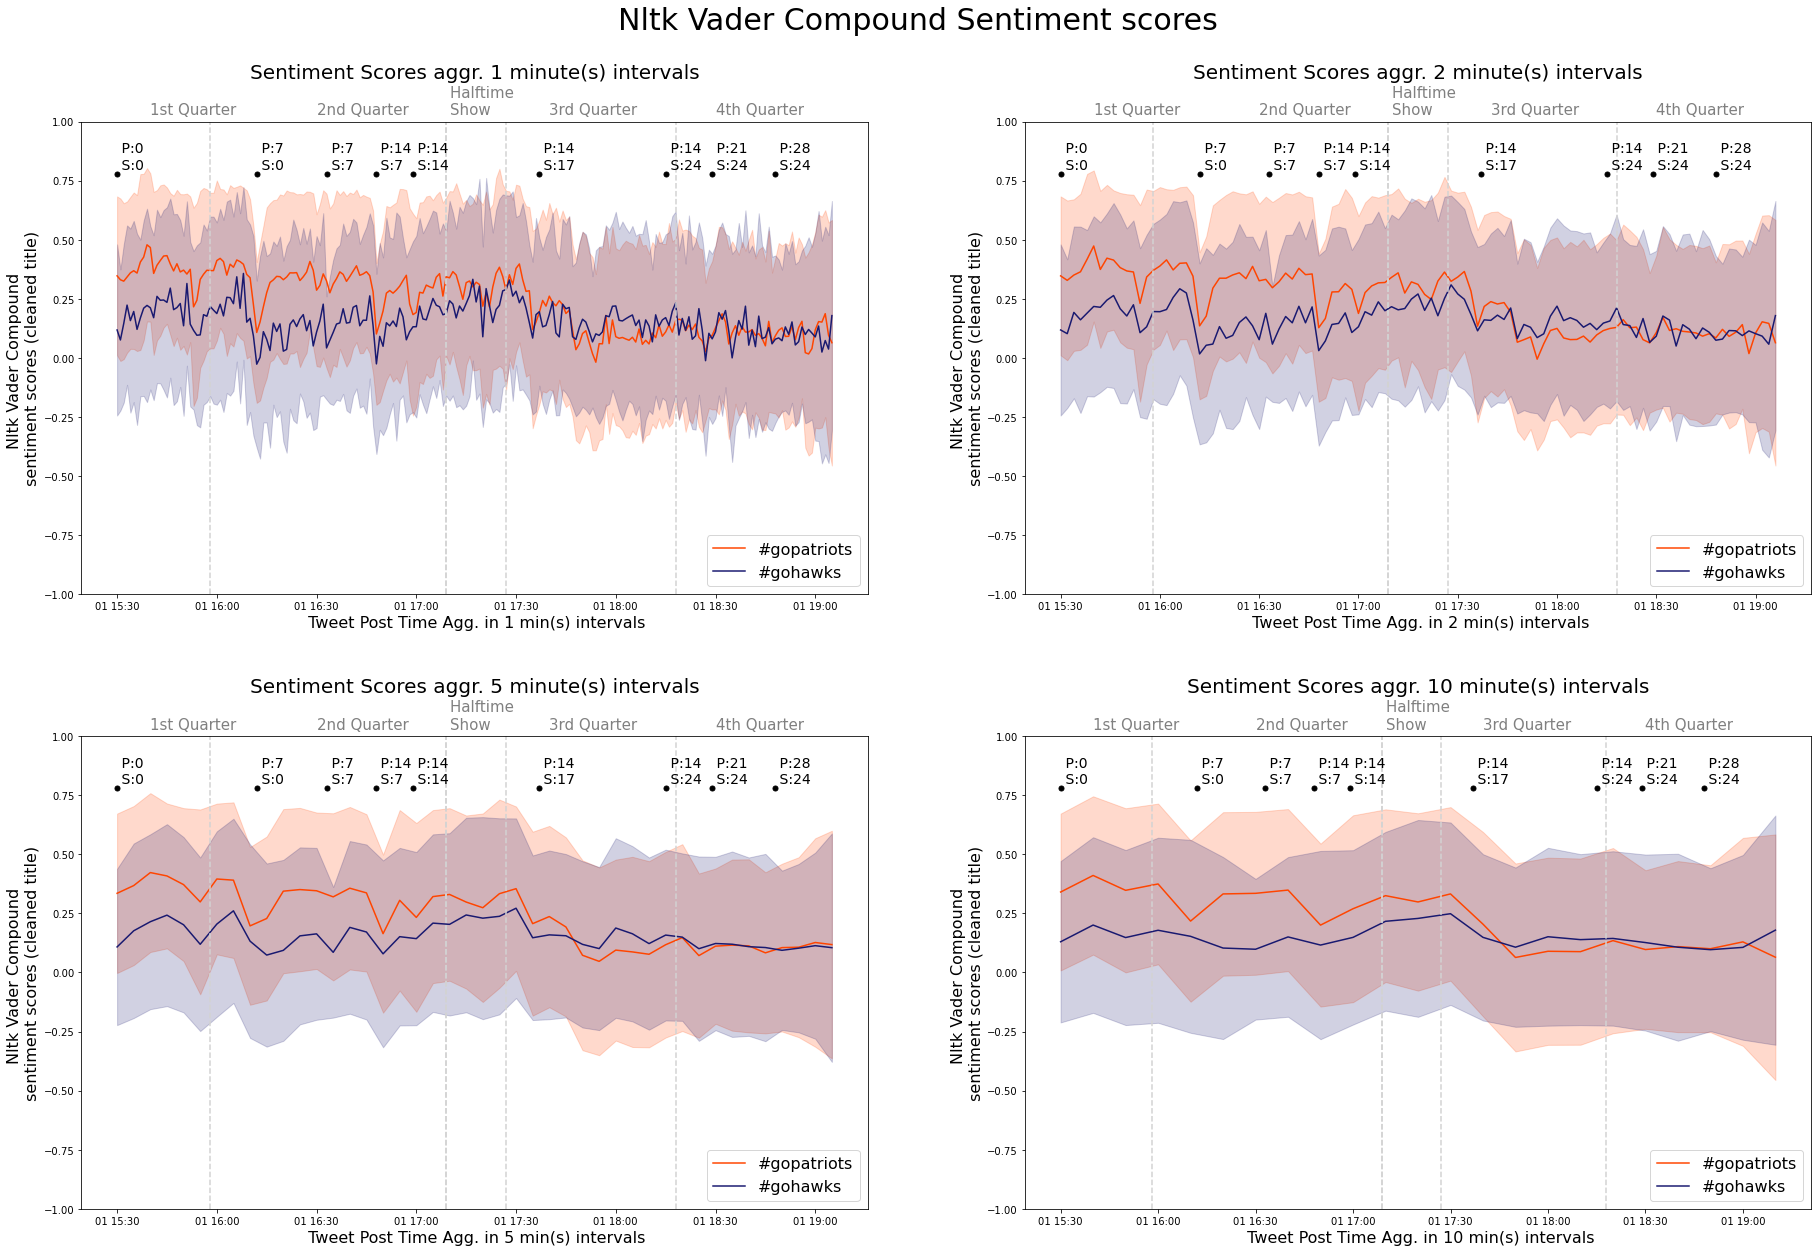

In [63]:
# Draw Fans emotion overtime aggregated on different time intervals:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(31,20))
plt.subplots_adjust(hspace = 0.3)

pretty = ' '.join(sentiment_feature.split('_')[1:-2]).title()
tit_type = ' '.join(sentiment_feature.split('_')[-2:])
plt.suptitle(f'{pretty} Sentiment scores', y=0.96, fontsize=30)
for interval, ax_ind in zip([1,2,5,10], ax.ravel()):
    
    tweet_emt_df[f'post_time_{interval}_intervals'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=interval))
    
    title = f'Sentiment Scores aggr. {interval} minute(s) intervals'
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=interval, sentiment_feat=sentiment_feature, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=title, ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=ax_ind)

plt.show()

Observations:

- We can see the spikes and downs in the teams when scores happened, for example when Patriots scored a touch down and game score is 7-0, the orange line peaks, showing increase in positive emotion, we can see the huge decrease on Patriots emotions when hawks makes score 14-17, hawks emotions get more positive than patriots when the score is 14-24.

- With nltk vader features, in 2 and 5 minute intervals plot we see same emotion patteerns for patriots and hawks from beginning until midlle of the 3rd quarter in the game. PAtriots have more positive emotions compared to seahawks, though, after the middle of 3rd quarter, at first hawks emotion gets higher and then gets almost similar with Patriots one. 


#### __CardiffNLP Fans' emotion during game__




Same plot drawn for CardiffNLP sentiment features:

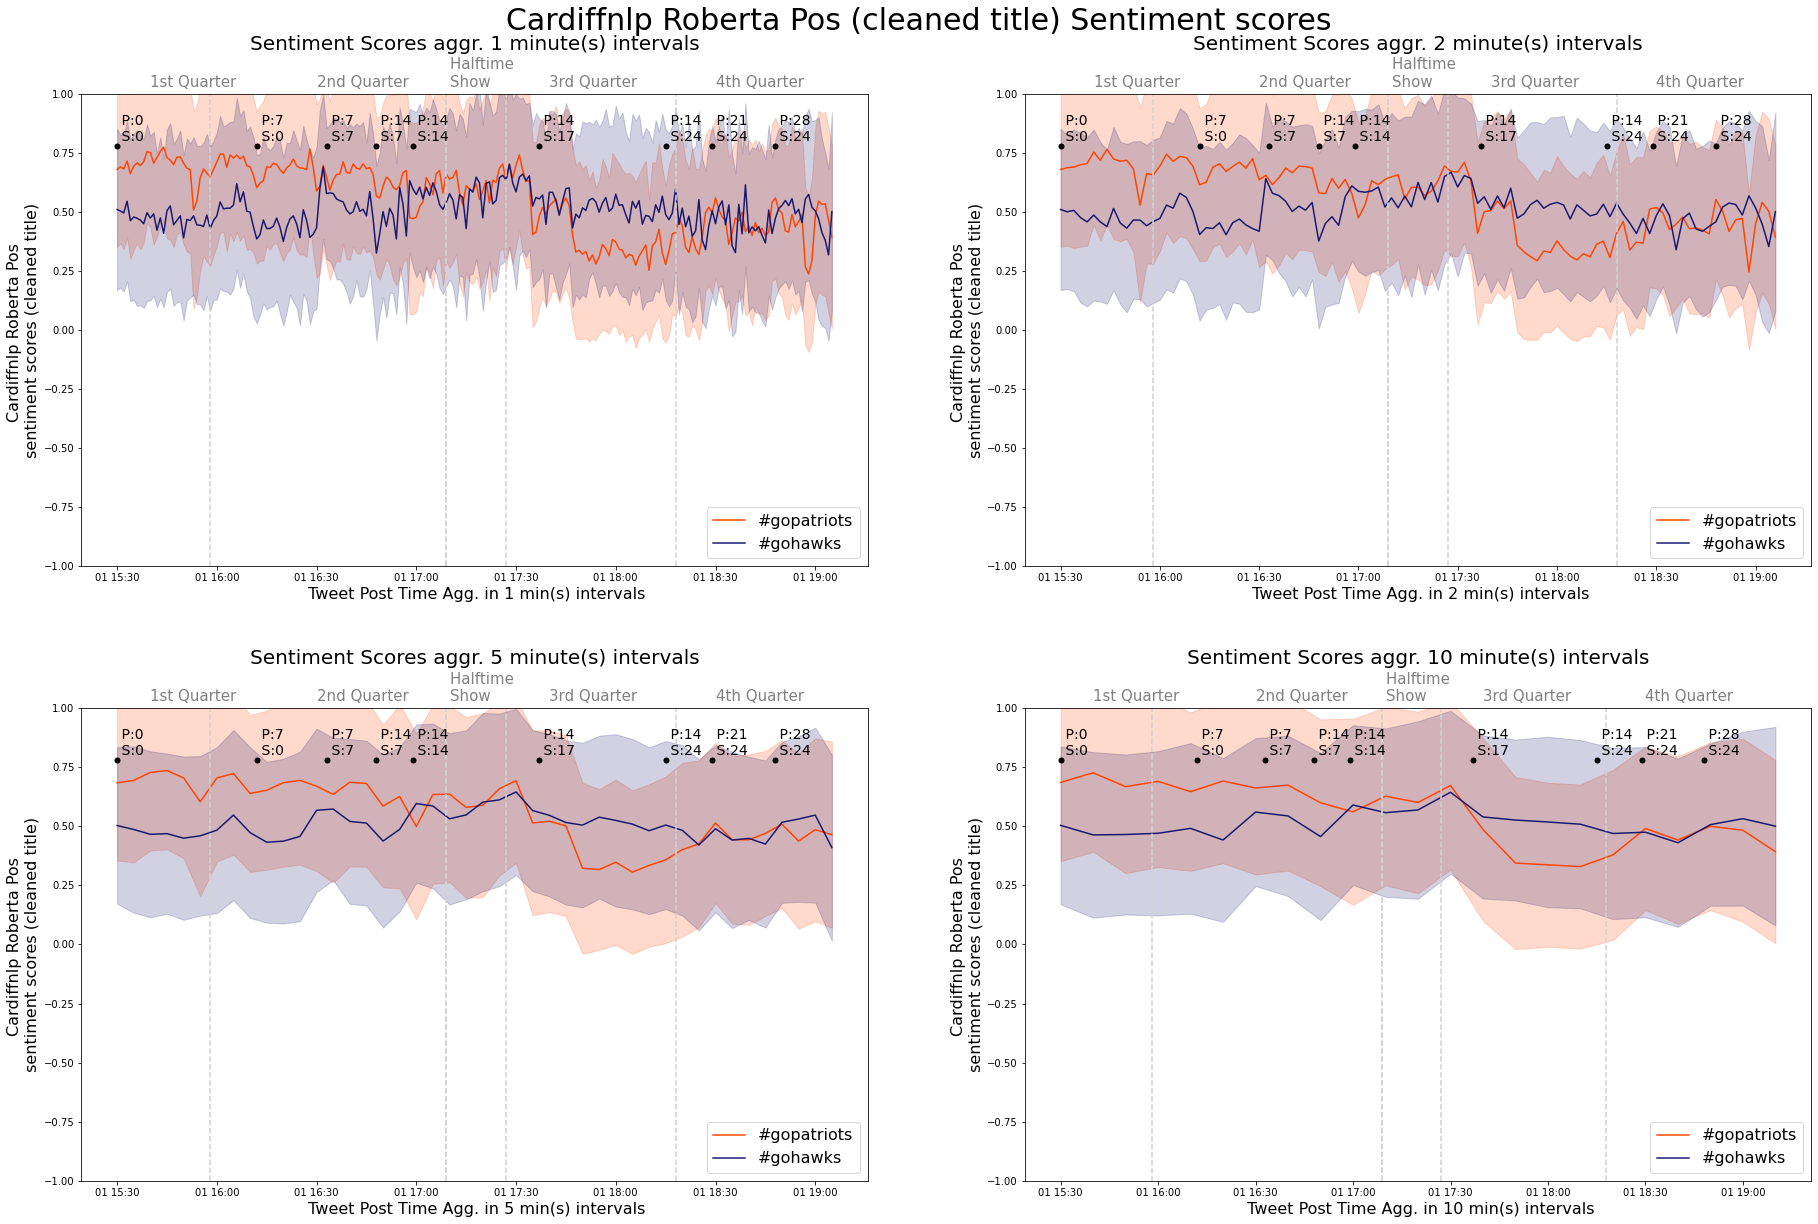

In [64]:
# Draw Fans emotion overtime aggregated on different time intervals:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(31,20))
plt.subplots_adjust(hspace = 0.3)
sne_f = 'sent_cardiffnlp_roberta_pos_cleaned_title'

pretty = ' '.join(sne_f.split('_')[1:-2]).title()
tit_type = ' '.join(sne_f.split('_')[-2:])
plt.suptitle(f'{pretty} ({tit_type}) Sentiment scores', y=0.94, fontsize=30)
for interval, ax_ind in zip([1,2,5,10], ax.ravel()):
    tweet_emt_df[f'post_time_{interval}_intervals'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=interval))
    
    title = f'Sentiment Scores aggr. {interval} minute(s) intervals'
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=interval, sentiment_feat=sne_f, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=title, ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=ax_ind)

plt.show()

Observations:

- Positive scores with CardiffNLP seems to be much higher compared to NLTK in overall. 
- The trends are more clear as well. By looking at the lines we can mostly tell which team is winning. We can see that orange line, patriots, overall emotions is more positive until the end of 2nd quarter, the periods where Patriots are leading the game. Whenever the score difference decrease or a tie happens between the teams the curve of each hashtag becomes closer to each other and the gap decreases as well. When Seahawks, starts to lead in the 3rd quarter, we can also see that the line for seahawks surpasses the patriots as well. 
- We can also see big spikes and down emotion trends also correlated with scores.
- As a first intuition, Cardiff NLP emotion distribution seems to show the correlation between scores and perceived emotions on teams more clearly than NLTK. The gaps between lines are more telling especially in the 3rd quarter in CardiffNLP. 

In [65]:
#plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=1, sentiment_feat=sentiment_feature, 
#                             groupby_list=['hashtag'], is_during_game=True,
#                             title=f'{sentiment_feature} 1 minute interval Sentiment Score over time for each fan group', 
#                             ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=None) # ci=None

### __Fans' Emotion towards each team: Comparison of different sentiment feature types__

In this section, I compare the 4 extracted sentiment features in a fixed interval time of 5 minute windows during thee game.

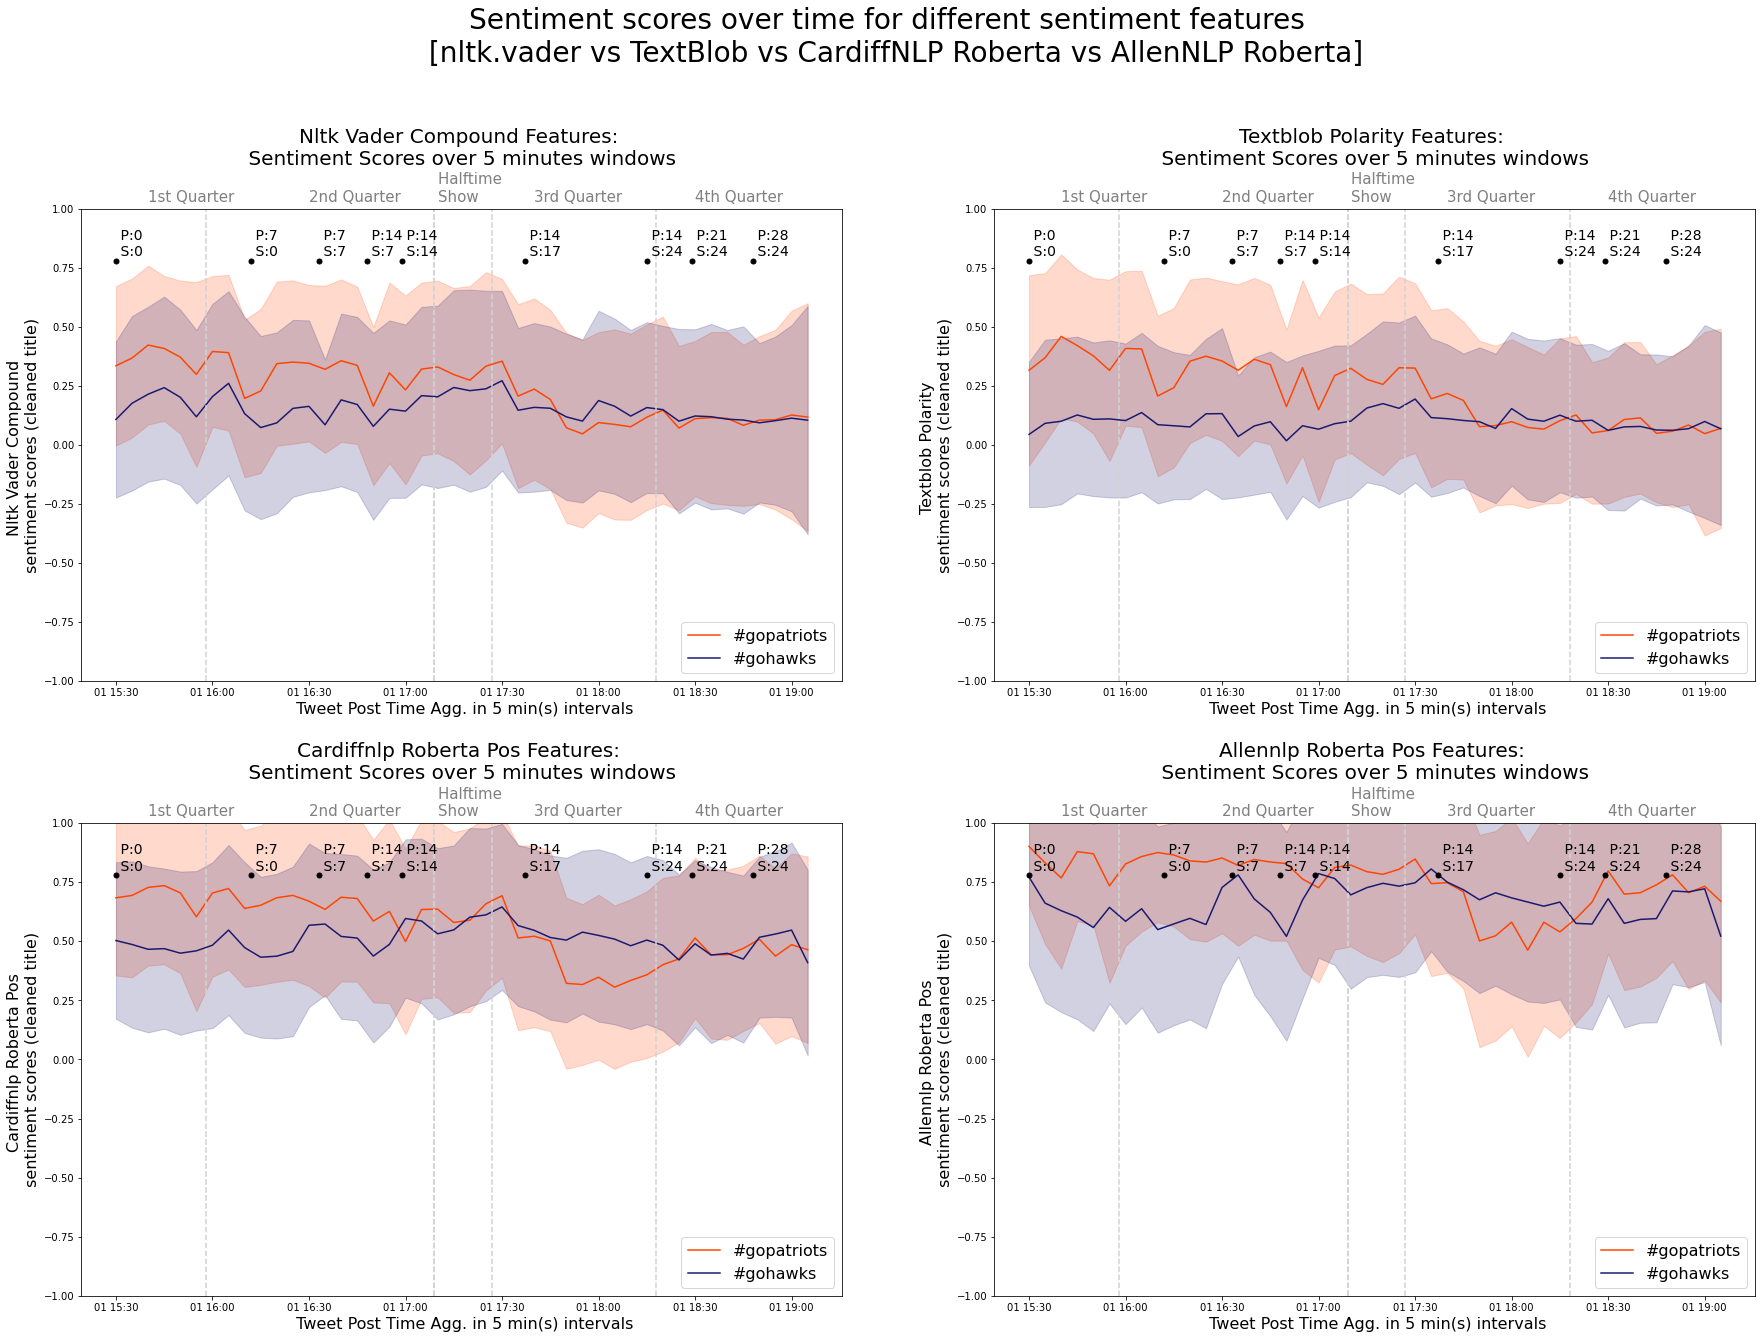

In [66]:
# Draw Fans emotion for different sentiment feature types
sentiment_feature = 'sent_nltk_vader_compound'+'_'+twt_feature_name   #sent_nltk_vader_compound, 'sent_textblob_polarity'
time_window = 5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
plt.suptitle(f'Sentiment scores over time for different sentiment features \n [nltk.vader vs TextBlob vs CardiffNLP Roberta vs AllenNLP Roberta]', y=1.02, fontsize=28)
sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_pos', 
              'sent_allennlp_roberta_pos'] 
plt.subplots_adjust(hspace = 0.3)
for snt, ax_ind in zip(sent_feats, ax.ravel()):
    sentiment_feat = snt+'_'+twt_feature_name 
    title = f'{" ".join(sentiment_feat.split("_")[1:-2]).title()} Features: \n Sentiment Scores over {time_window} minutes windows '
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=time_window, sentiment_feat=sentiment_feat, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=title, ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=ax_ind)
    #ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
#fig.tight_layout()
plt.show()

Observations:

- For NLTK in the first half of game the trends for each team is very close, on the other hand, for Textblob the closeness is less and for the 2 Roberta features set the overall line shapes are different. 
- For NLTK and Textblob, rule-based approaches, we can see that Patriots have more positive emotions, in the first half of the game, then in the second half the emotions are more flat and lower for both teams, the gap is also very small. For CardiffNLP and AllenNLP Roberta models, we can see better trends. 
- If we assume higher positive emotions corresponds to that team is leading the game, then we can see the game status clearly with line trends through out the game with AllenNLP:
    - P:7-S:0, orange line higher -> patriots winning
    - P:7-S:7, orange and purple line gap decrease -> tie
    - P:14-S:7, blue line curve decrease -> patriots score, tie break, patriots leading again
    - P:14-S:14, seahawks scores, gap decrease -> tie
    - P:14-S:24, purple line surpasses orange -> seahawks winning
    - P:21-S:24, orange line surpasses purple -> patriots winning
    - P:28-S:24, orange line surpasses purple -> patriots winning
- The gap between the lines, can even tell the score difference. Notice that when the score difference is higher the gap is bigger, whereas when there is a tie the two lines either merged or get very close.

### __Fans' Emotion for Top 8 tweeted players__

Who are the most tweeted players?

In [67]:
twt_counts_per_player = pd.concat([pd.DataFrame(tweet_emt_df.player2.value_counts()),pd.DataFrame( tweet_emt_df.player2.value_counts(normalize=True))], axis=1)
twt_counts_per_player.columns = ['tweet_counts', 'tweet_percentage']

In [68]:
display(twt_counts_per_player.head(5).T)

#gopatriots       #gohawks     Tom Brady  Russell Wilson  \
tweet_counts      357785.000000  115377.000000  32383.000000      8710.00000   
tweet_percentage       0.649418       0.209421      0.058779         0.01581   

                  Rob Gronkowski  
tweet_counts         5395.000000  
tweet_percentage        0.009792

In [69]:
display(twt_counts_per_player.iloc[5:10].T)

Marshawn Lynch  Richard Sherman  Chris Matthews  \
tweet_counts         4845.000000       4314.00000     2753.000000   
tweet_percentage        0.008794          0.00783        0.004997   

                  Julian Edelman  Earl Thomas  
tweet_counts         2439.000000  2130.000000  
tweet_percentage        0.004427     0.003866

In [70]:
display(twt_counts_per_player.iloc[10:15].T)

LeGarrette Blount  Doug Baldwin  Darrelle Revis  \
tweet_counts            1948.000000   1541.000000     1342.000000   
tweet_percentage           0.003536      0.002797        0.002436   

                  Kam Chancellor  Vince Wilfork  
tweet_counts         1010.000000     949.000000  
tweet_percentage        0.001833       0.001723

Who are the top players for each hashtag? Are the players play in defense or offense? Are the 10 players of each hashtag is for that team or the rival team?

Below table shows top 10 players for each hashtag:

In [71]:
if 'Team' not in tweet_emt_df.columns:
    sub_players_df = players_df[['Player', 'Pos', 'Team', 'Position','Category']]
    tweet_emt_df = tweet_emt_df.merge(sub_players_df, how='left', left_on='player2', right_on='Player')

In [72]:
bys = ['hashtag', 'player2', 'Team', 'Category' ]
twt_counts_per_player_hsh = pd.DataFrame(tweet_emt_df.groupby(bys).title.count())
twt_counts_per_player_hsh.columns = ['tweeet_count']
twt_counts_per_player_hsh.sort_values(by=['hashtag','tweeet_count'], ascending=False, inplace=True)
twt_counts_per_player_hsh.reset_index(inplace=True)


__#gopatriots__

In [73]:
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gopatriots'].head(5).T)


0               1               2                  3  \
hashtag       #gopatriots     #gopatriots     #gopatriots        #gopatriots   
player2         Tom Brady  Rob Gronkowski  Julian Edelman  LeGarrette Blount   
Team             Patriots        Patriots        Patriots           Patriots   
Category          Offense         Offense         Offense            Offense   
tweeet_count        28360            4327            2401               1907   

                            4  
hashtag           #gopatriots  
player2       Richard Sherman  
Team                 Seahawks  
Category              Defense  
tweeet_count             1457

In [74]:
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gopatriots'].iloc[5:10].T)


5               6               7               8  \
hashtag          #gopatriots     #gopatriots     #gopatriots     #gopatriots   
player2       Marshawn Lynch  Russell Wilson  Darrelle Revis  Chris Matthews   
Team                Seahawks        Seahawks        Patriots        Seahawks   
Category             Offense         Offense         Defense         Offense   
tweeet_count            1306            1246            1245            1156   

                        9  
hashtag       #gopatriots  
player2       Earl Thomas  
Team             Seahawks  
Category          Defense  
tweeet_count         1037

__#gohawks__

In [75]:
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gohawks'].head(5).T)


39         40              41               42  \
hashtag             #gohawks   #gohawks        #gohawks         #gohawks   
player2       Russell Wilson  Tom Brady  Marshawn Lynch  Richard Sherman   
Team                Seahawks   Patriots        Seahawks         Seahawks   
Category             Offense    Offense         Offense          Defense   
tweeet_count            7464       4023            3539             2857   

                          43  
hashtag             #gohawks  
player2       Chris Matthews  
Team                Seahawks  
Category             Offense  
tweeet_count            1597

In [76]:
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gohawks'].iloc[5:10].T)


44           45              46              47  \
hashtag           #gohawks     #gohawks        #gohawks        #gohawks   
player2       Doug Baldwin  Earl Thomas  Rob Gronkowski  Kam Chancellor   
Team              Seahawks     Seahawks        Patriots        Seahawks   
Category           Offense      Defense         Offense         Defense   
tweeet_count          1307         1093            1068             843   

                           48  
hashtag              #gohawks  
player2       Jermaine Kearse  
Team                 Seahawks  
Category              Offense  
tweeet_count              518

Tom Brady gets the bigger number of tweets. We can see that hawks supporters tends to talk more about Seahawks players whilst patriots fan talks for players of both teams 5/10 top players mentioned by patriots are SeaHawks players. One might suggest that this might be because for patriots we merged #gopatriots and #patriots tags, however, this was the case with 5/10 ratio before merging #gopatriots and #patriots tag as well.

In both of the hashtags majority of the comments are for offense players than defense players. #gopatriots mainly talks about opposite team's defense players when the player's category is defense. This potentially means that even talking about defense players, patriots fan are more focusing on the offense moments of their team. We may conclude that fans are more interested talking about attack moments of their team (deffense of opposing team). 



I plotted the perceived emotion about players over 15 minutes time inteerval for each feature set. I chose the most tweeted 8 players and increaseed time interval to 15 minutes for convenience of reading plots more easily. The perceived emotions in these plots are combined for each fan group. Given that the data is unbalanced against each hashtag, the results might be towards more Patriots' fan feeling.


Tom Brady, Russell Wilson, Rob Gronkowski,
Marshawn Lynch, Richard Sherman, Chris Matthews,
Julian Edelman, Earl Thomas


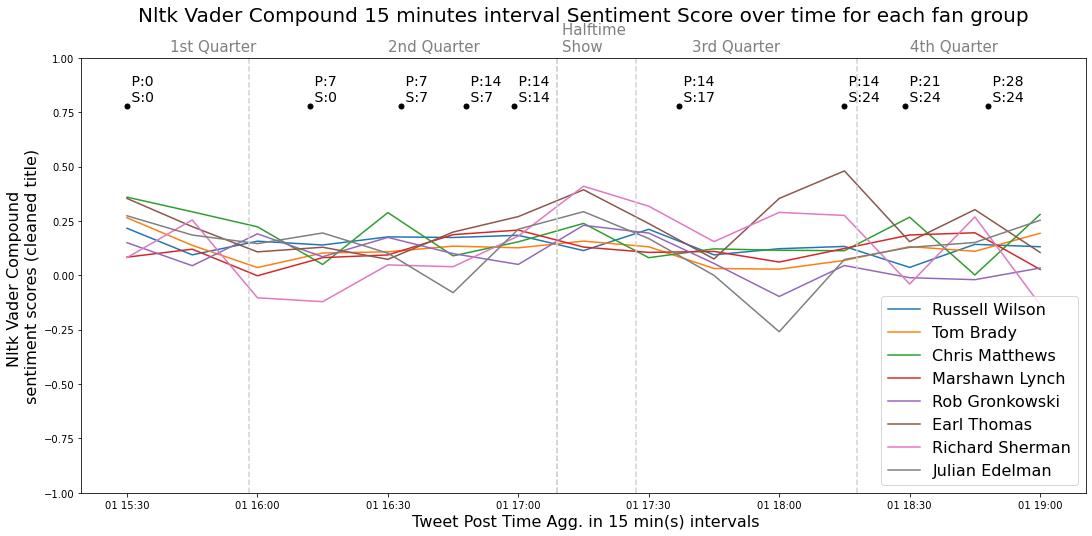

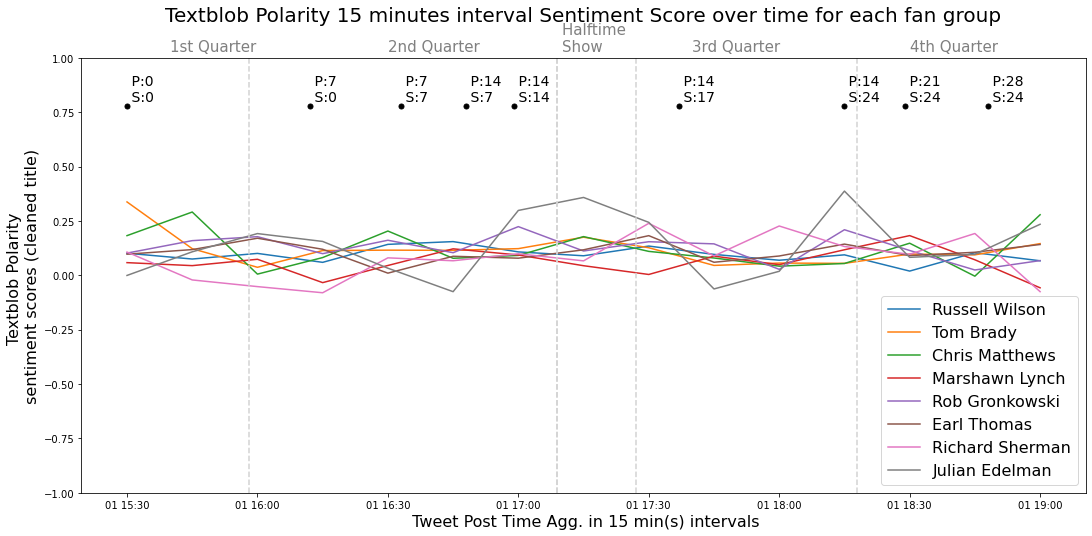

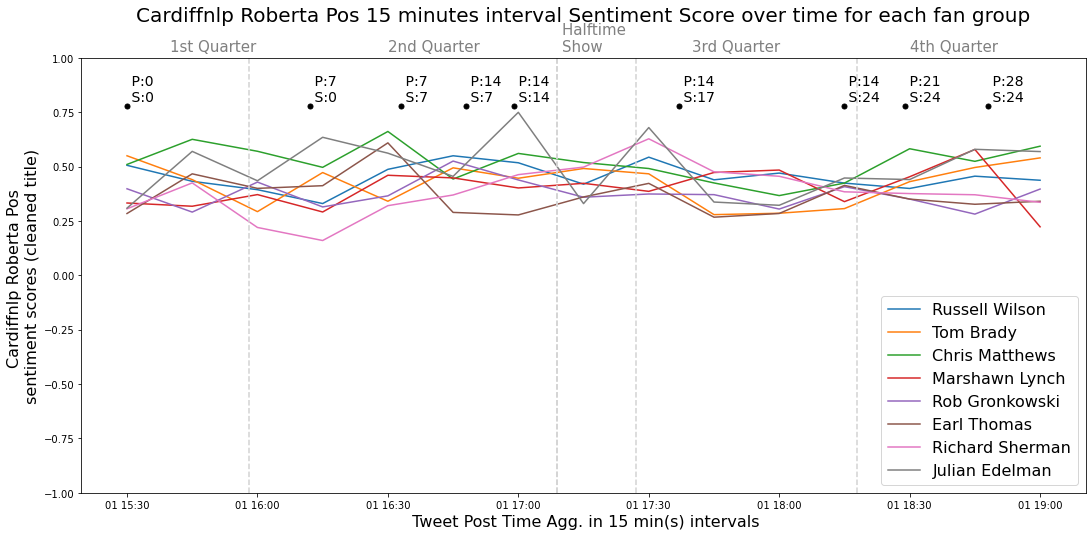

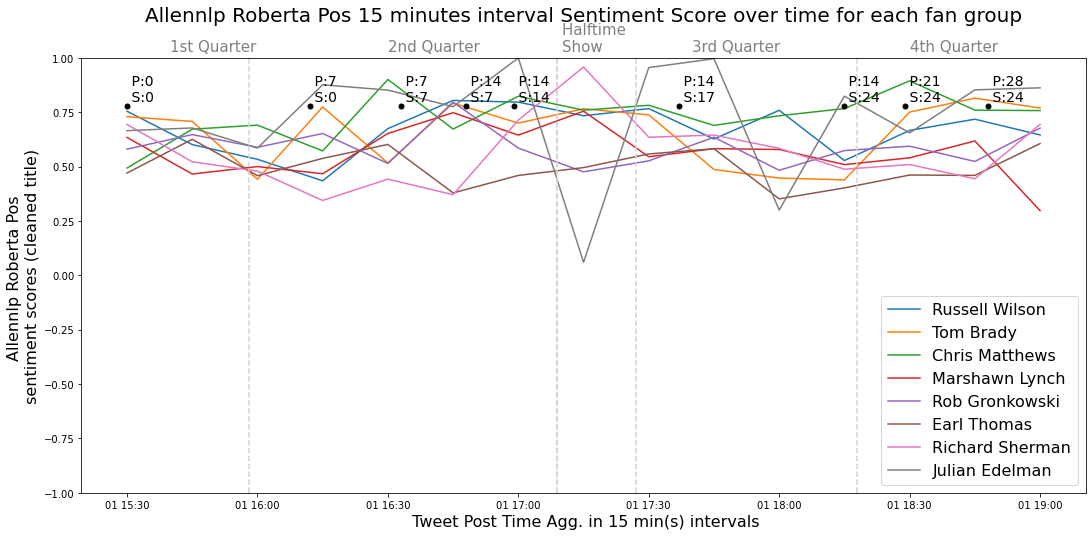

In [77]:

sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_pos', 
              'sent_allennlp_roberta_pos'] 
selected_pls = list(twt_counts_per_player.index)[2:10]
print(textwrap.fill(',\n'.join(selected_pls),50))
for st in sent_feats:
    st2 = st+'_cleaned_title'
    sb_df = tweet_emt_df[tweet_emt_df.player2.isin(selected_pls)]
    plot_emotion_by_interval(tweet_emt_df=sb_df, time_int=15, sentiment_feat=st2, 
                                 groupby_list=['player2'], is_during_game=True,
                                 title=f'{" ".join(st2.split("_")[1:-2]).title()} 15 minutes interval Sentiment Score over time for each fan group', 
                                 ylab='', xlab='', hue='player2', ci=None, figsize=(18,8), ax_ind=None)
    #plt.tight_layout()
    plt.show()
#marker='o', markersize=5

Observations:

- Notice that 5 of the 8 top tweeted players are from Seahawks. (Russell Wilson, Chris Matthews, Marshawn Lynch, Earl Thomas, Richard Sherman)
- First two players are passing leaders of each team, the next 2 are receiver for Seahawks, Rob is receiver for Patriots, Earl and Richard are defense players for Seahawks, and Julian is receiver for Patriots. 
- We can see that emotions for players, varies a lot during the game, the most sharp and bigger changes seeem to happen in AllenNLP and NLTK. Julian Edelman seems to have the biggest change of heart from fans during the game, where it has the biggest peaks and downs.The emotions perceived for Tom Brady seems rather stale in the first 3 approaches, but changes a lot in AllenNLP. 
- For CardiffNLP, we can see clear peaks on the players who involved plays during Touch Down and Field Goal times. This also makes sense since it is very likely that team's praise the player who take role in scoring or shades the players who fail to defense. 


### __Individual Players' Emotion Plots over time during the game__

In this part, I plotted individual players' perceived emotion during game. Each plot has emotion trends for 4 sentiment feature types and two of the fan base. Again plotted for 15 minute intervals for convenience.

Players selected: #gopatriots, #gohawks, Tom Brady, Russell Wilson,
Rob Gronkowski, Marshawn Lynch, Richard Sherman, Chris Matthews,
Julian Edelman, Earl Thomas


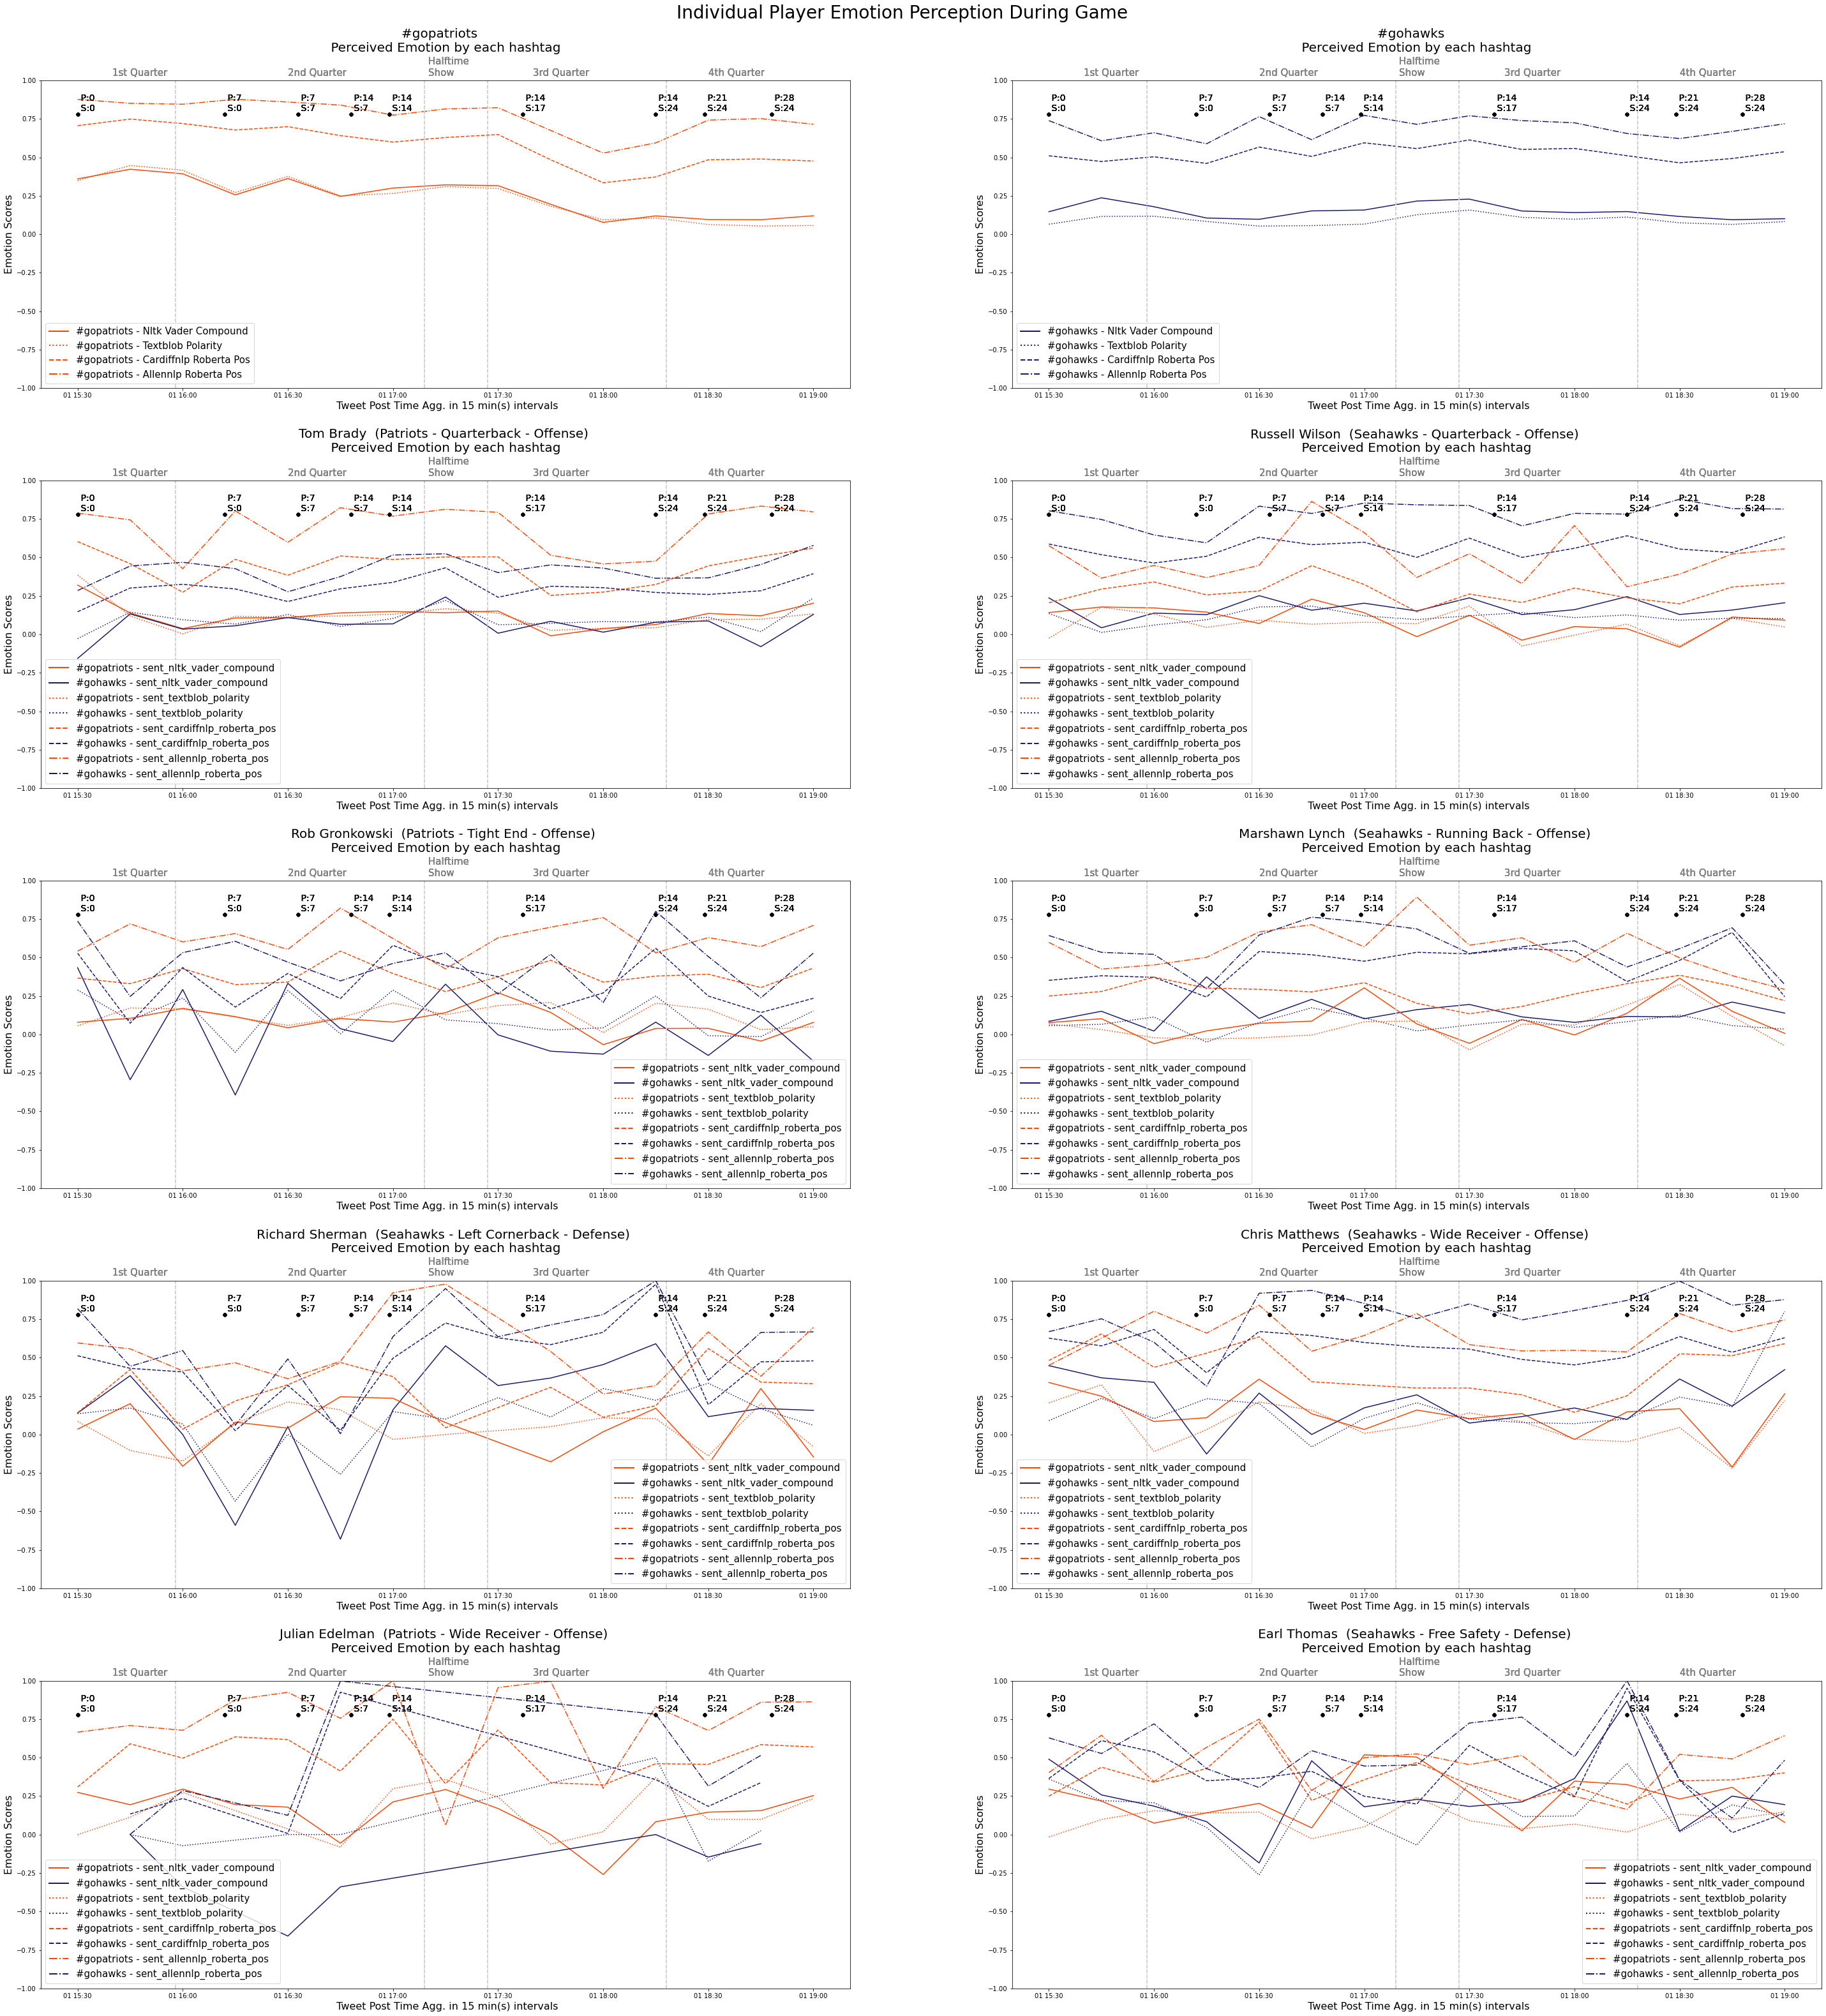

In [78]:
# Draw Fans emotion for each player separately 
time_window = 15
selected_pls = list(twt_counts_per_player.index)[:10]
print(textwrap.fill('Players selected: '+',\n'.join(selected_pls), 70))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(50,55))
plt.subplots_adjust(hspace = 0.3)
plt.suptitle(f'Individual Player Emotion Perception During Game', y=0.91, fontsize=28)
cnt= 0
for ply, ax_ind in zip(selected_pls, ax.ravel()):
    cnt+=1
    ply_df = players_df[players_df.Player==ply]
    team = ply_df.Team.values[0] if not ply_df.empty else ''
    pos = ply_df.Position.values[0] if not ply_df.empty else ''
    cat = ply_df.Category.values[0] if not ply_df.empty else ''
    infix = f'({team} - {pos} - {cat})' if pos else ''
    title = f'{ply}  {infix} \n Perceived Emotion by each hashtag '
    
    
    sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_pos', 
              'sent_allennlp_roberta_pos'] 
    lnstyle = ['-', ':','--', '-.' ]
    markers=['o','v', 's', '*']
    for st, ls, mrk in zip(sent_feats, lnstyle, markers):
        st2 = st+'_cleaned_title'
        plot_emotion_by_interval(tweet_emt_df=tweet_emt_df[tweet_emt_df.player2==ply], 
                                        time_int=time_window, sentiment_feat=st2, 
                                         groupby_list=['hashtag'], is_during_game=True, ls=ls,
                                         title=title, ylab='Emotion Scores', xlab='', hue='hashtag',
                                         ci= None, figsize=(20,6), ax_ind=ax_ind)
        
    palette = {'#gopatriots': 'orangered','#gohawks': 'midnightblue'}
    lines = []
    labels = []
    if cnt > 2:
        for z,ll in zip(sent_feats, lnstyle):
            for  team in ['#gopatriots', '#gohawks']:
                lines.append(Line2D([0], [0], color=palette[team], linewidth=2, linestyle=ll))
                labels.append(f'{team} - {z}')
    else:
        for z,ll in zip(sent_feats, lnstyle):
            lines.append(Line2D([0], [0], color=palette[ply], linewidth=2, linestyle=ll))
            labels.append(f'{ply} - {" ".join(z.split("_")[1:]).title()}')
        
    ax_ind.legend(lines, labels, fontsize=15)

plt.show()

Observations:

- #gohawks, #gopatriots: these emotion groups belong to the tweets where I can't identiy a player. It also corresponds to the majority of the tweets. #gopatriots is mostly on highly positve stable curve up to 3rd quarter, and has a huge decrease in 3rd quarter. These makes perfect sense since Patriots lead thee game in first half and Seahawks, lead the 3rd quarter. I cannot clearly see trends in Touch Downs though. For seahawks, we can see smooth little peaks when Seahawks ties the game twice in thee second quarteer. Textblob and NLTK curves are almost same. The trends of Roberta models are very similar. AllenNLP assigns higher emotion scores than CardiffNLP. 

- Tom Brady: The emotions are keep changing for Tom Brady during the game for both fans. Patriots fan's positive emotion increases towards Tom Brady when Patriots score, and decrease considerably when Seahawks scores. Again we see that AllenNLP assigns higher values, then CardiffNLP and then the rule based features. 

- Russell Wilson: The zigzag trend is more towards Russell Wilson from both fans, compared to Tom Brady. 

-  The trends of different feature types throughout the game per fan base seems to be similar but differs in the score amount. 

- The more lower towards the subplots, players with lower tweet number, the data becomes more sparse throughout time or fan base, and the more chaotic lines seem to get. Patterns are harder to interpret, and for different feature set, the trends are no longer simiilar either. 



### __Individual Players' Emotion Plots over time during the game for AllenNLP__

Since it is harder to read the previous plots, I also plotted the same thing on only AllenNLP Roberta Feeatures. I chose AllenNLP since the polarity seem to be highhtened in this feature set and previous results were more interesting for this one than the other feature sets. I decreased the intervals to 10 minutes, since we have less lines, and want to see more granular, accurate patterns.

Players selected: #gopatriots, #gohawks, Tom Brady, Russell Wilson,
Rob Gronkowski, Marshawn Lynch, Richard Sherman, Chris Matthews,
Julian Edelman, Earl Thomas


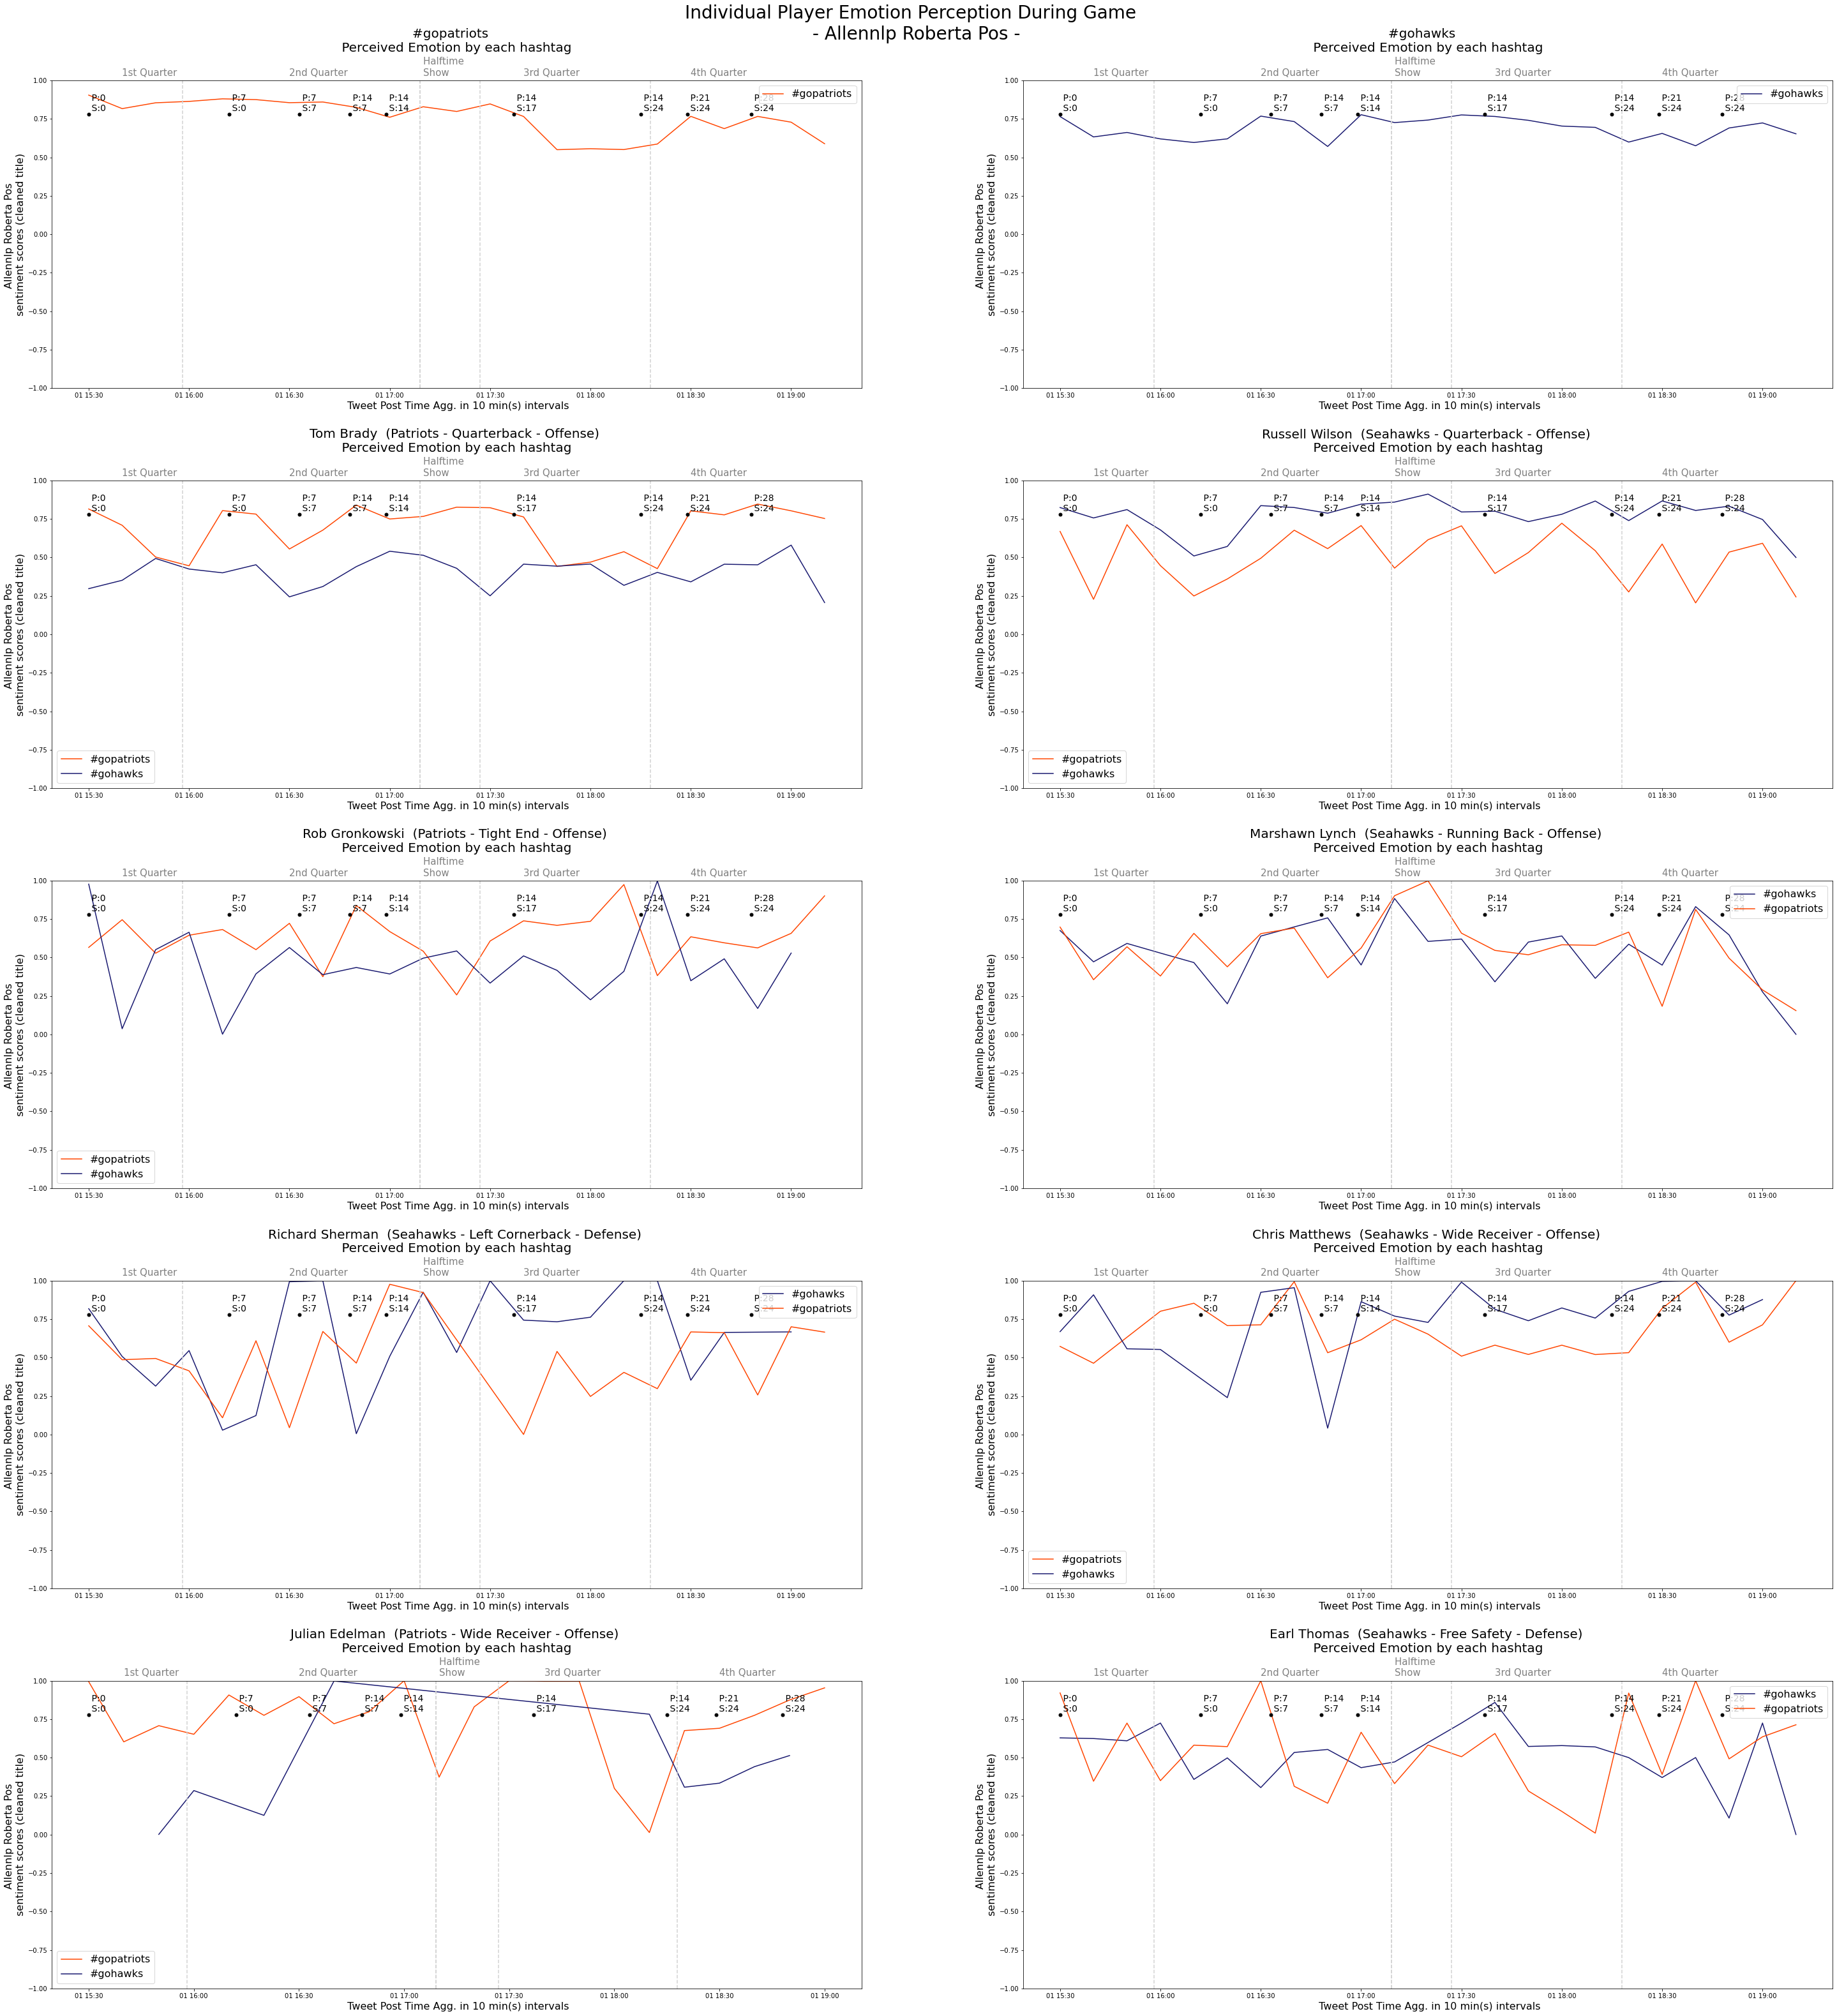

In [79]:
# Draw Fans emotion for each player separately 
time_window = 10
selected_pls = list(twt_counts_per_player.index)[:10]
print(textwrap.fill('Players selected: '+',\n'.join(selected_pls), 70))

sentiment_feat = 'sent_allennlp_roberta_pos_cleaned_title'
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(50,55))
plt.subplots_adjust(hspace = 0.3)
plt.suptitle(f'Individual Player Emotion Perception During Game \n - {" ".join(sentiment_feat.split("_")[1:-2]).title()} -', y=0.91, fontsize=28)
for ply, ax_ind in zip(selected_pls, ax.ravel()):
    ply_df = players_df[players_df.Player==ply]
    team = ply_df.Team.values[0] if not ply_df.empty else ''
    pos = ply_df.Position.values[0] if not ply_df.empty else ''
    cat = ply_df.Category.values[0] if not ply_df.empty else ''
    infix = f'({team} - {pos} - {cat})' if pos else ''
    title = f'{ply}  {infix} \n Perceived Emotion by each hashtag '
    
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df[tweet_emt_df.player2==ply], 
                                        time_int=time_window, sentiment_feat=sentiment_feat, 
                                         groupby_list=['hashtag'], is_during_game=True,
                                         title=title, ylab='', xlab='', hue='hashtag', ci=None, figsize=(20,6), ax_ind=ax_ind)
plt.show()



Observations:

- Tom Brady: Patriots have a clear pattern for Tom, when Patriots score huge jump in emotion towards positive, when Seahawks scores huge decrease. This makes sense since Tom Brady is the main player. Patriots overall emotion is more positive for Tom.

- Russell Wilson: Again, as stated in the previous plot, the emotion is way zigzagy and fragile for Russell Wilson than Tom Brady. Seahawks fans emotion is more stable, and has an upward trend when SeaHawks scores. Seahawks emotions are more positive overall for Russell. 

- Rob Gronkowski: He is an offense player for Patriots and the most interesting thing is that sometimes hawks fans' emotions are higher to a Patriot player than from patriot fans (halftime show, beegining of 4th quarter). Could positive emotions be more sarcasm? Especially in 4th quarter the positive emotions come after hawks score. It is also possible that more than 1 player is listed in the tweet and we see these results, ie. hawks fan may be talking about a specific moment between the players of the teams such as Rob and his counterpart in the game. 

- Marshawn Lynch: Perceived emotion by each fan group is again more complicated, we can't tell which fan group as an overall higher/lower emotion for him during the game. Two clear peaks are seahawks scored at the end of second quarter and when Patriots scored 21-24 in 4th quarter. He seems to make a comeback in the second half of the game, since hawks fan emotion is way higher in the second half of the game for him.

- Richard Sherman & Chris Matthews: I see huge peaks in emotion when Seahawks scores, which makes sense. Looks like more seahawks emotion towards the whol game rather than player itself.

- Julian Edelman: Very few hawks fan tweets. There is a huge PAtriots' fan emotion decrease twice during game, both which seahawks scored. He might have been interrupted or played a role on loosing the ball? (excuse my lousy american football terms). 


For most of the players, I believe there might be more than one player stated in the tweet, and the tweet emotion might not directly correlate to the player itself but rather a significant position/event happening in the game where name of the player is stated. Such as "Wow, such a comeback Tom Brady and Russell Wilson are playing big. Way to go Seahawks I hope you win.": if this would have been a real tweet we would assign positive scores both Tom and Russell no matter which team's fan I am. The problem is the emotion in the tweet is not directly towards either player but rather team itself. There might be more interesting inferences from these plot about players but my american football knowledge is limited to the things I learned in the last two weeks. 


### __Pairwise Players' Perceived Emotion Change During Game__

In this part, I coupled the leaders of the game by their counterparts in the match, such as Tom Brady and Russell Wilson and check the overall perceived emotion for both players oveer time during game. Note that at this part perceived emotion is calculated for both fans together. Time interval over 5 minutes. I used AllenNLP Roberta feature for this part.

In [80]:
bys = ['Team', 'player2', 'Category' ]
twt_counts_per_player_hsh2 = pd.DataFrame(tweet_emt_df.groupby(bys).title.count())
twt_counts_per_player_hsh2.columns = ['tweeet_count']
twt_counts_per_player_hsh2.sort_values(by=['Team','tweeet_count'], ascending=False, inplace=True)
twt_counts_per_player_hsh2.reset_index(inplace=True)


__Patriots__

Top 10 players tweet counts in all dataset:

In [81]:

display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Patriots'].head(5).T)


20              21              22                 23  \
Team           Patriots        Patriots        Patriots           Patriots   
player2       Tom Brady  Rob Gronkowski  Julian Edelman  LeGarrette Blount   
Category        Offense         Offense         Offense            Offense   
tweeet_count      32383            5395            2439               1948   

                          24  
Team                Patriots  
player2       Darrelle Revis  
Category             Defense  
tweeet_count            1342

In [82]:

display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Patriots'].iloc[5:10].T)


25              26                    27  \
Team               Patriots        Patriots              Patriots   
player2       Vince Wilfork  Brandon LaFell  Michael Hoomanawanui   
Category            Defense         Offense               Offense   
tweeet_count            949             868                   737   

                          28              29  
Team                Patriots        Patriots  
player2       Chandler Jones  Danny Amendola  
Category             Defense         Offense  
tweeet_count             507             491

__Saahawks__

Top 10 players tweet counts in all dataset:

In [83]:
display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Seahawks'].head(5).T)

0               1                2               3  \
Team                Seahawks        Seahawks         Seahawks        Seahawks   
player2       Russell Wilson  Marshawn Lynch  Richard Sherman  Chris Matthews   
Category             Offense         Offense          Defense         Offense   
tweeet_count            8710            4845             4314            2753   

                        4  
Team             Seahawks  
player2       Earl Thomas  
Category          Defense  
tweeet_count         2130

In [84]:
display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Seahawks'].iloc[5:10].T)

5               6                7              8  \
Team              Seahawks        Seahawks         Seahawks       Seahawks   
player2       Doug Baldwin  Kam Chancellor  Jermaine Kearse  Bryan Walters   
Category           Offense         Defense          Offense        Offense   
tweeet_count          1541            1010              646            585   

                          9  
Team               Seahawks  
player2       Tony McDaniel  
Category            Defense  
tweeet_count            430

For offense and defense use players other than Tom Brady and Russell Wilson since we already compared them in Passing Leaders.

Image shows the game leaders listed in ESPN website for the game:

![game_leaders](game_leaders.png)

ref: https://www.espn.com/nfl/game/_/gameId/400749027

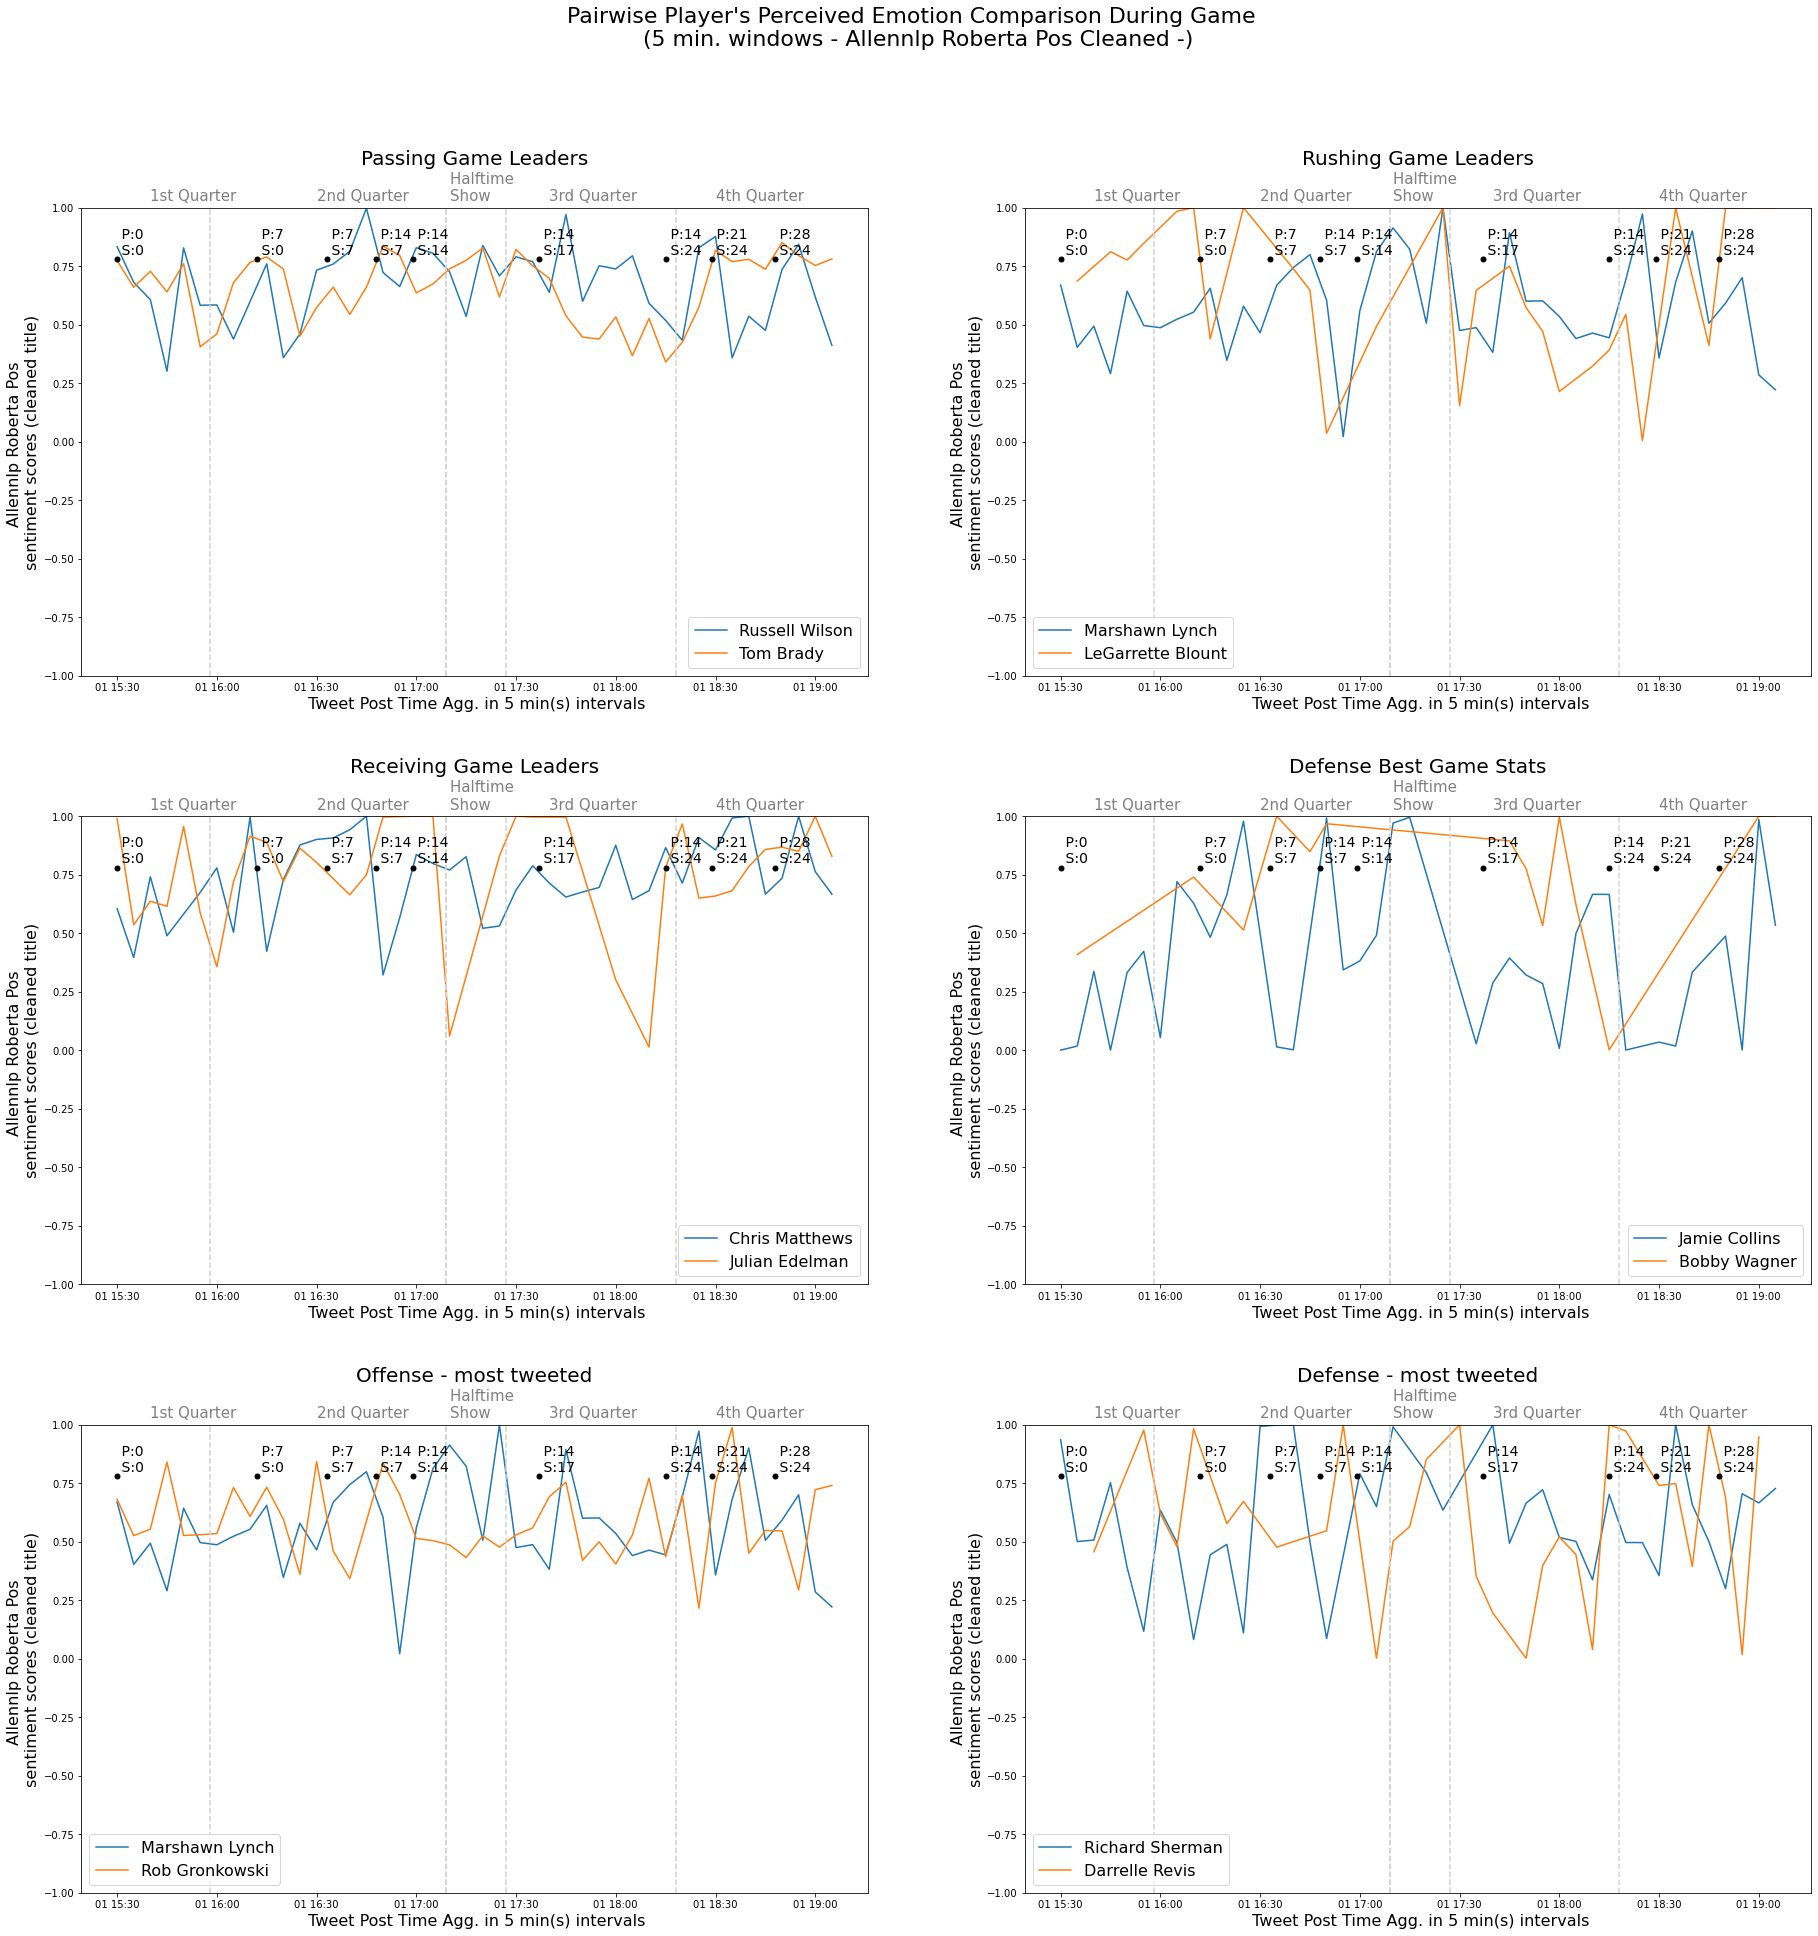

In [85]:
pairs = [('Passing Game Leaders',['Tom Brady','Russell Wilson']),
         ('Rushing Game Leaders',['LeGarrette Blount','Marshawn Lynch']),
         ('Receiving Game Leaders',['Julian Edelman','Chris Matthews']),
         ('Defense Best Game Stats',['Jamie Collins','Bobby Wagner']),
         ('Offense - most tweeted',['Rob Gronkowski','Marshawn Lynch']),
         ('Defense - most tweeted',['Darrelle Revis','Richard Sherman']),      
]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(31,31))
plt.subplots_adjust(hspace = 0.3)
tm_int = 5
sentiment_feat = 'sent_allennlp_roberta_pos_cleaned_title'
plt.suptitle(f"Pairwise Player's Perceived Emotion Comparison During Game  \n({tm_int} min. windows - {' '.join(sentiment_feat.split('_')[1:-1]).title()} -)", y=0.97, fontsize=22)
for (name, plys), ax_ind in zip(pairs, ax.ravel()):
    title = f'{name}'
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df[tweet_emt_df.player2.isin(plys)], 
                                        time_int=tm_int, sentiment_feat=sentiment_feat, 
                                         groupby_list=['player2'], is_during_game=True, 
                                         title=title, ylab='', xlab='', hue='player2', ci=None, figsize=(20,6), ax_ind=ax_ind)
plt.show()

# do one for 1 of the roberta 



__Passing Game Leaders: Tom Brady vs Russell Wilson__
- There is a pick in both players emotion positively whenever a team is scored. Sometimes the emotion with each player is related based on their team's status only, ie. peak in Russell 3rd quarter when Seahawks scores, peak in Tom's curve when Patriots score in 2nd quarter P14-S7. Though sometimes emotions are rather merged, see peaks in P7-S0, P21-S24, P28-S24, both player's get peak, irrespective of which team is scored. I believe the reason behind this is that both players are mentioned in the time of these touch down tweets.


__Rushing Game Leaders: Marshawn Lynch vs LeGarette Blount__
-  The curve patterns mostly have same high peaks and low drop moments for both players.


__Receiving Game Leaders: Chris Matthews vs Julian Edelman__
- The emotions are motly opposite for each player when touch downs happened. When Patriots score, Julian's emotion raise towards more positive and Chris' drops, and when Seahawks scores reverse happens. This is interesting, we can see the expected opposite team emotions for these player throughout the game.

__Defense Best Game Stats: Jamie Collins vs Bobby Wagner__
- Bobby Wagner's emotion features are more sparse than Jamie Collins. Again wee see the opposite feeling pattern we observed above with these two players.


__Offense - most tweeted: Marshawn Lynch vs Rob Gronkowski & Defense - most tweeted: Richard Sherman - Darnell Revis__

Again we see the opposite patterns, when one player peaks other's emotion drops in the touch down times and most likely in other significant events during game.


## Prediction Task

__From tweet emotions expressed to players in 1-minute time windows can we predict who is winning?__


I aggregated the emotions about each player in 1-minute time windows during the game, for aggregation I used mean of the given sentiment scores. For mapping tweets to players I used the same starategy described in previous parts. I also added 2 more columns: #gohawks and #gopatriots where I get the overall sentiment for each team in 1-minute intervals. There is two main reason I added these two columns: 1- around 75% of the data I couldn't idendity player name, so if I don't I would be loosing too much information that might help my prediction task. 2- The final matrix created is a sparse matrix, not many players have tweets posted with their name each minute of the game. These two columns are dense one, that might increase the prediction power of the task.

The classes of this task is Tie, Patriots or Seahawks. This was also unable in the raw tweet data and for the labels I used the 'leading' column of the score_df I created in the previous parts. To map the game time to the tweets real time, I used the approximated score times (described in detail Data Exploration & Feature Engineering: Mapping Game Time to Real Time section), with the use of these time mappings I assigned the labels of who is leading the game to every 1-minute interval.

For each 4 feature set type, I created different datasets for the prediction task and applied 3 ML models to all 4 of them. 

Feature sets:
- Nltk.sentiment.vader, 
- TextBlob, 
- CardiffNLP Roberta and 
- AllenNLP Roberta

ML Models:
- Logistic Regression
- Random Forest
- Neural Network

I choose these 3 models, because I want to see the performance of the models in a simple baseline model (LR), a model that is performed well in unbalanced dataseet and a more complex model (NN).

The steps followed:
- Create data for the modelling, get labels and prepare data for modelling
- Split data to train-test set, do 10-fold cross validation for model parameter tuning using train dataset to select best estimators for each model type
- Apply test set on the refitted ML models with best parameters on the all training dataset
- Check Feature Importance for Random Forest and coeff weights for Logistic Regression models.

I only used the data tweeted during the superbowl 49 game and English tweets. 

In addition to the prediction task, I want to check the importance of the models I created to see whether I can say anything additional about the players. Who is the most important player for the game. Can we tell who might be the MVP of the game? Along with player's position can we tell who could be the best Receiver, Defense player?

#### __Creating the data to be used for prediction task:__


In [86]:
def get_label(post_date, time_interval_feature_pred):
    df = score_time_df[score_time_df['citation_date_fixed'] <= post_date] #time_interval_feature_pred
    scr =  '' if df.empty else df.score.values[-1]
    lbl =  '' if df.empty else df.leading.values[-1]
    return [scr, lbl]

def prep_prediction_data(data, time_interval_feature_pred, sentiment_feature_pred, agg='mean'):
    pls = list(players_df.Player) 
    player_feature = 'player2'
    sub_df = data[(data.game_status=='during_game')]
    if agg=='sum':
        fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature_pred, player_feature])[sentiment_feature_pred].sum()) 
    else:
        fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature_pred, player_feature])[sentiment_feature_pred].mean())
    
    fan_sentiments_df.reset_index(inplace=True)
    
    # pivot table to use in the model
    model_data = fan_sentiments_df.pivot_table(columns =[player_feature, ], index=[time_interval_feature_pred], values=[sentiment_feature_pred])
    model_data.reset_index(inplace=True)
    model_data = model_data.sort_values(by=[time_interval_feature_pred])
    model_data = model_data.set_index([time_interval_feature_pred])
    model_data.columns = model_data.columns.droplevel(0)
    model_data = model_data.reset_index()
    model_data.rename(columns={'':time_interval_feature_pred}, inplace=True)
    model_data[['score','leading']] = model_data.apply(lambda x: get_label(x[time_interval_feature_pred], 
                                                                           time_interval_feature_pred=time_interval_feature_pred)
                                                       , axis=1, result_type='expand')
    
    return model_data, fan_sentiments_df

How many tweeets each player received during game?

In [87]:
# How many tweeets each player received?
tweet_emt_df[tweet_emt_df.game_status=='during_game'].player2.value_counts()

#gopatriots             57138
#gohawks                19203
Tom Brady                5977
Russell Wilson           1302
Chris Matthews           1100
Marshawn Lynch            864
Julian Edelman            646
Rob Gronkowski            571
Doug Baldwin              354
Brandon LaFell            272
Richard Sherman           251
Earl Thomas               240
Jermaine Kearse           221
Danny Amendola            220
Darrelle Revis            154
LeGarrette Blount         137
Kyle Arrington            129
Shane Vereen              113
Jamie Collins             106
Bobby Wagner              103
Vince Wilfork              77
Chandler Jones             71
Michael Hoomanawanui       69
Tony McDaniel              64
Kevin Williams             55
Kam Chancellor             54
Bruce Irvin                46
Cliff Avril                39
K.J. Wright                38
Bryan Walters              33
Rob Ninkovich              30
Ricardo Lockette           30
Dont'a Hightower           26
Brandon Br

In [88]:
model_data_mean_dfs = {}
sent_feats = ['sent_nltk_vader_compound', 'sent_textblob_polarity', 
              'sent_cardiffnlp_roberta_pos', 
              'sent_allennlp_roberta_pos'] 
twt_feature_name_pred = 'cleaned_title'
round_num_pred = 1
time_interval_feature_pred = f'post_time_{round_num_pred}_intervals'

for sf in sent_feats:
    sentiment_feature_pred = sf+'_'+twt_feature_name_pred   
    model_data_exp, _ = prep_prediction_data(data=tweet_emt_df, 
                         time_interval_feature_pred=time_interval_feature_pred, 
                         sentiment_feature_pred=sentiment_feature_pred, 
                         agg='mean')
    
    model_data_mean_dfs[sf+'_'+f'{round_num_pred}_mins'] = model_data_exp


#### __How Data Looks Like?__

Game took 216 minutes, that is why we have 216 rows, samples in our dataset and I found tweets posted on 40 players during game + 2 team columns, 42 columns.
Below, we can see the data created for AllenNLP Roberta Positive Score Features for the first 5 minute of the game. Notice that the data seems very sparse for some of the players.

Data Preview for the first 6 columns of first 5 minutes in the game:

In [89]:
sample_df = model_data_mean_dfs['sent_allennlp_roberta_pos'+'_'+f'{round_num_pred}_mins']
print(sample_df.shape)
sample_df[['post_time_1_intervals', '#gohawks', '#gopatriots', 'Bobby Wagner',
       'Brandon Browner', 'Brandon LaFell']].head(5)

(216, 42)


player2     post_time_1_intervals  #gohawks  #gopatriots  Bobby Wagner  \
0       2015-02-01 15:30:00-08:00  0.765169     0.915447           NaN   
1       2015-02-01 15:31:00-08:00  0.815970     0.918031           NaN   
2       2015-02-01 15:32:00-08:00  0.781914     0.905448           NaN   
3       2015-02-01 15:33:00-08:00  0.733644     0.895856           NaN   
4       2015-02-01 15:34:00-08:00  0.657131     0.878550           NaN   

player2  Brandon Browner  Brandon LaFell  
0                    NaN             NaN  
1                    NaN             NaN  
2                    NaN        0.951774  
3                    NaN             NaN  
4                    NaN             NaN

As expected, data becomes less sparse for the most tweeted players. Below you can see only the most tweeted players and randomly selected 10 minutes of the game:

(post_time_1_intervals won't be used in the modelling, I put in here just for showing what time in the game the selected 1-minute interval corresponds to)

In [90]:
inds = sample_df.sample(10).index
sample_df[['post_time_1_intervals', '#gohawks', '#gopatriots','Tom Brady',  'Russell Wilson', 'Chris Matthews', 
           ]].iloc[inds]

player2     post_time_1_intervals  #gohawks  #gopatriots  Tom Brady  \
201     2015-02-01 18:51:00-08:00  0.768218     0.672990   0.713158   
213     2015-02-01 19:03:00-08:00  0.548149     0.745636   0.819526   
138     2015-02-01 17:48:00-08:00  0.700695     0.559546   0.433796   
177     2015-02-01 18:27:00-08:00  0.532102     0.788759   0.660526   
15      2015-02-01 15:45:00-08:00  0.630571     0.881566   0.666181   
111     2015-02-01 17:21:00-08:00  0.765330     0.791283   0.999210   
182     2015-02-01 18:32:00-08:00  0.700104     0.748749   0.829745   
73      2015-02-01 16:43:00-08:00  0.684693     0.853567   0.571063   
205     2015-02-01 18:55:00-08:00  0.640510     0.675349   0.702878   
139     2015-02-01 17:49:00-08:00  0.737002     0.507526   0.465867   

player2  Russell Wilson  Chris Matthews  
201            0.709041        0.781835  
213            0.460369        0.000856  
138            0.999411        0.809007  
177                 NaN        0.999224  
15                  NaN        0.285398  
111            0.943161             NaN  
182            0.947678        0.996738  
73             0.998351             NaN  
205            0.647346        0.999822  
139            0.602391        0.757743

In [91]:
sample_df[['Marshawn Lynch', 'Julian Edelman',  'Rob Gronkowski', 'leading' ]].iloc[inds]

player2  Marshawn Lynch  Julian Edelman  Rob Gronkowski   leading
201            0.678363        0.892279        0.990402  Patriots
213            0.163377        0.828680        0.000495  Patriots
138                 NaN             NaN        0.382201  Seahawks
177                 NaN        0.606261             NaN  Seahawks
15             0.201507        0.999847        0.786160       Tie
111            0.998131             NaN        0.572241       Tie
182            0.999836        0.462827        0.995795  Patriots
73             0.997983             NaN        0.320715       Tie
205            0.757766        0.990173             NaN  Patriots
139                 NaN             NaN             NaN  Seahawks

In the prediction task I will only use a subset of the players, since for some players the data is very very sparse, it might hurt prediction rather than help. As I experimented with the full dataset, I realized that those sparse columns are creating noise to confuse model than to increase prediction power. For example, for Rober Turbin I could only match 3 tweets in the entire game, in the best case if every tweet is posted in separate minutes, we only have 3 rows filled out of 216. 

That is why, I will only use a subset of these 42 columns and select the best ones based on their density level, by dropping the most sparse columns.

In [92]:
# model_data_mean_dfs.keys()
# model_data_mean_dfs['sent_nltk_vader_compound'+'_'+f'{round_num_pred}_mins'].head(5)
# model_data_mean_dfs['sent_nltk_vader_compound'+'_'+f'{round_num_pred}_mins'].describe()

#### __Parameter Tuning Experiments:__



In [93]:
def model_experiment(X, y, full_pipeline, params, fname, model_file, model_name, cv, rerun, search_type='grid', n_iter=10, scoring='accuracy', verbose=0, model=None):
    if os.path.isfile(fname) and (not rerun):
        grid_results_df = pd.read_csv(fname)
        #load your model for further usage
        grid_search = joblib.load(model_file)
        return grid_search, grid_results_df
    else:
        t0 = time.time()
        if scoring == 'accuracy':
            refit=True
        else:
            refit='accuracy'
        
        if search_type=='randomized':
            grid_search = RandomizedSearchCV(full_pipeline, param_distributions=params, 
                                     n_iter=n_iter,  cv=cv, scoring=scoring,
                                     refit=refit, return_train_score=True, verbose=verbose)
        elif search_type=='bayes':
            if not model:
                grid_search = BayesSearchCV(full_pipeline, search_spaces=params, 
                                         n_iter= n_iter,cv=cv, scoring=scoring,
                                         refit=refit, return_train_score=True,verbose=verbose)
            else:
                grid_search = BayesSearchCV(model, search_spaces=params, n_iter= n_iter,
                                         cv=cv, scoring=scoring, refit=refit,return_train_score=True,verbose=verbose)
    
        else: # do grid search
            grid_search = GridSearchCV(full_pipeline, params, cv=cv, scoring=scoring, refit=refit,
                                       return_train_score=True,verbose=verbose)
            
        cv_results = grid_search.fit(X, y)
        t1 = time.time()
        elapsed = t1-t0
        print('Time for experiment:',time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
        grid_results_df = pd.DataFrame(grid_search.cv_results_)
        if scoring == 'accuracy':
            grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
        else:
            grid_results_df.rename(columns={'mean_test_accuracy': 'mean_validation_accuracy'}, inplace=True)
            grid_results_df.rename(columns={'mean_test_f1': 'mean_validation_f1'}, inplace=True)

        
        grid_results_df['model_name'] = model_name
        grid_results_df.to_csv(fname)
        #save your model or results
        joblib.dump(grid_search, model_file)
        #grid_results_df.head()
        return grid_search, grid_results_df
        
def rf_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/p2_exps/p2_{data_name}_rf_model_exp{post_fix}.csv'
    model_file = f'exp_results/p2_exps/p2_{data_name}_rf_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    params = {
        "model": [ RandomForestClassifier(random_state=rand_seed,oob_score=True, n_jobs=-1)],
        "model__max_features":  ['auto', None, 1, 2, 3, 4, 6] ,
        "model__n_estimators": [5, 10, 20, 40, 60],
        "model__max_depth": [2, 4, 6, None],
        "model__class_weight": [None, 'balanced', 'balanced_subsample'],
    }
    scoring = 'accuracy' #{"accuracy": "accuracy", "f1": "f1"}
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv, model_name='Random Forest',
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

def nn_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/p2_exps/p2_{data_name}_nn_model_exp{post_fix}.csv'
    model_file = f'exp_results/p2_exps/p2_{data_name}_nn_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    params = {
        "model": [ MLPClassifier(random_state=rand_seed, max_iter=300, early_stopping=True)],
        "model__hidden_layer_sizes": [(5,), (8,), (10,), (30,),(50,),(100,), (120,), (30,30), (50, 50)],
        "model__alpha": [10**(x) for x in range(-5,3)] ,
        "model__learning_rate_init":[0.001, 0.01, 0.1],
        "model__activation":['relu','logistic','tanh']
    }
    scoring = 'accuracy' #{"accuracy": "accuracy", "f1": "f1"}
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv, model_name='MLP',
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

def lr_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/p2_exps/p2_{data_name}_lr_model_exp{post_fix}.csv'
    model_file = f'exp_results/p2_exps/p2_{data_name}_lr_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    params = {
        "model": [LogisticRegression(random_state=rand_seed, solver='saga')],
        "model__penalty": ['none','l1','l2'],
        "model__class_weight": [None, 'balanced'],
        "model__C": [10**(x) for x in range(-2,2)],
    }
    
    scoring = 'accuracy' #{"accuracy": "accuracy", "f1": "f1"}
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv,  model_name='Logistic Regression',
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

def create_xy_data(data, col_drop_level, sent_feat, drop_cols=True, print_stats=True):
    pls = ['#gohawks', '#gopatriots', 'Bobby Wagner',
       'Brandon Browner', 'Brandon LaFell', 'Bruce Irvin', 'Bryan Walters',
       'Byron Maxwell', 'Chandler Jones', 'Chris Matthews', 'Cliff Avril',
       'Danny Amendola', 'Darrelle Revis', 'Devin McCourty',
       "Dont'a Hightower", 'Doug Baldwin', 'Earl Thomas', 'Jamie Collins',
       'Jermaine Kearse', 'Julian Edelman', 'K.J. Wright', 'Kam Chancellor',
       'Kevin Williams', 'Kyle Arrington', 'LeGarrette Blount',
       'Marshawn Lynch', 'Michael Bennett', 'Michael Hoomanawanui',
       'Patrick Chung', 'Ricardo Lockette', 'Richard Sherman',
       'Rob Gronkowski', 'Rob Ninkovich', 'Robert Turbin', 'Russell Wilson',
       'Shane Vereen', 'Tom Brady', 'Tony McDaniel', 'Vince Wilfork',]
    model_data = data[sent_feat]
    X =  model_data[pls]
    y = model_data['leading']
    
    if drop_cols:
        drop_perc = col_drop_level
        int_NA = int(drop_perc*X.shape[0])
        X = X.dropna(thresh=int_NA, axis=1)
    
    if print_stats:
        print(f'-- Info about data: \n')
        print('X shape:', X.shape)
        display('Class Distribution:', y.value_counts())
        display('Class Distribution (normalized):', y.value_counts(normalize=True))

        print(f'\tDropped columns where less than {drop_perc*100}% is empty')
        print('\tX shape after dropping columns:', X.shape)
        print(textwrap.fill(f'\tRemaining columns:\n\t\t {X.columns.tolist()}' , 70))

        print('\tFilling NaN emotions scores with 0..')
    X = X.fillna(0)
    return X,y

For parameter tuning I applied 10-fold cross validation on training dataset (contains 80% of samples).
For each model I tuned the following parameters: 

__Logistic Regression:__

- penalty: ['none','l1','l2'],
- class_weight: [None, 'balanced'],
- C: [10**(x) for x in range(-2,2)],

__Random Forest:__

- max_features:  ['auto', None, 1, 2, 3, 4, 6] ,
- n_estimators: [5, 10, 20, 40, 60],
- max_depth: [2, 4, 6, None],
- class_weight: [None, 'balanced', 'balanced_subsample'],


__Neural Network:__

- hidden_layer_sizes: [(5,), (8,), (10,), (30,),(50,),(100,), (120,), (30,30), (50, 50)],
- alpha: [10**(x) for x in range(-5,3)] ,
- learning_rate_init:[0.001, 0.01, 0.1],
- activation:['relu','logistic','tanh']


For Logistic Regression and Neural Network, I applied 10-fold cross validation on gridsearch, for Random forest I used 10-fold cross validation on randomized search with 100 samples.

In [94]:
def experiment(col_drop_level=0.5, print_stat=True):
    exp_results = {}
    for sent_data_type in model_data_mean_dfs.keys():  
        
        X, y = create_xy_data(data=model_data_mean_dfs, col_drop_level=col_drop_level, sent_feat=sent_data_type, drop_cols=True, print_stats=print_stat)
        print_stat=False
        print(f'Model Experiments for : {sent_data_type} data: ')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        # create experiments for 3 models
        #print('Experiments for LR ')
        pstfix= f'{sent_data_type}_{str(col_drop_level)}'
        search_lr, res_lr_df = lr_model_exp(X=X_train, y=y_train, cv=10,data_name='emotions',
                                            search_type='grid', n_iter=100, post_fix=pstfix, verbose=0)
        #print('Experiments for RF ')
        search_rf, res_rf_df = rf_model_exp(X=X_train, y=y_train, cv=10,data_name='emotions',
                                            search_type='randomized', n_iter=100, post_fix=pstfix, verbose=0)
        #print('Experiments for NN ')
        search_nn, res_nn_df = nn_model_exp(X=X_train, y=y_train, cv=10,data_name='emotions',
                                            search_type='grid', n_iter=100, post_fix=pstfix, verbose=0)
        exp_results[sent_data_type] = {'X_train':X_train,
                                       'X_test':X_test,
                                       'y_train':y_train,
                                       'y_test':y_test, 
                                       'lr_cv_search':search_lr,
                                       'lr_cv_res':res_lr_df,
                                       'rf_cv_search':search_rf,
                                       'rf_cv_res':res_rf_df,
                                       'nn_cv_search':search_nn,
                                       'nn_cv_res':res_nn_df}
    return exp_results

In this experiment I only kept selected denser columns that have at least 50% of the rows that are non-nulls. This corresponds to 8 out of 42 columns. The columns kept are: ['#gohawks', '#gopatriots', 'Chris Matthews', 'Earl Thomas', 'Marshawn Lynch', 'Rob Gronkowski', 'Russell Wilson', 'Tom Brady']

I also filled the remaining null values with 0s as 0 is the neutral score in this case:



In [95]:
exp_res_df_50 = experiment(col_drop_level=0.5, print_stat=True)

-- Info about data: 

X shape: (216, 8)


'Class Distribution:'

Tie         98
Patriots    67
Seahawks    51
Name: leading, dtype: int64

'Class Distribution (normalized):'

Tie         0.453704
Patriots    0.310185
Seahawks    0.236111
Name: leading, dtype: float64

	Dropped columns where less than 50.0% is empty
	X shape after dropping columns: (216, 8)
        Remaining columns:                  ['#gohawks',
'#gopatriots', 'Chris Matthews', 'Earl Thomas', 'Marshawn Lynch', 'Rob
Gronkowski', 'Russell Wilson', 'Tom Brady']
	Filling NaN emotions scores with 0..
Model Experiments for : sent_nltk_vader_compound_1_mins data: 
Model Experiments for : sent_textblob_polarity_1_mins data: 
Model Experiments for : sent_cardiffnlp_roberta_pos_1_mins data: 
Model Experiments for : sent_allennlp_roberta_pos_1_mins data: 


##### __Top 3 Best Features Found for each feature set and model pairs:__

Below, I shared the top 3 best tuned parameter combination for each feature set, model pairs along with 10-fold training and validation scores.

In [96]:
sel_cols =['lr_cv_res', 'rf_cv_res', 'nn_cv_res']
cs_models = [[ 'mean_train_score','mean_validation_score' ,'param_model__C',
             'param_model__class_weight', 'param_model__penalty', 'rank_test_score'],
             
             [ 'mean_train_score','mean_validation_score' ,'param_model__n_estimators', 'param_model__max_features',
               'param_model__max_depth', 'param_model__class_weight', 'rank_test_score'],
             
             ['mean_train_score','mean_validation_score' , 
              'param_model__hidden_layer_sizes', 'param_model__alpha', 'rank_test_score']
]
for st in exp_res_df_50.keys():
    for mdl_cv_res, cs in zip(sel_cols, cs_models):
        print(f'\n\n\n{st} Features - {mdl_cv_res.split("_")[0].upper()} Model CV Results')
        sorted_df = exp_res_df_50[st][mdl_cv_res][cs].sort_values('mean_validation_score', ascending=False)
        display(sorted_df[cs[:4]].head(3))
        if len(cs) > 5:
            display(sorted_df[cs[4:]].head(3))






sent_nltk_vader_compound_1_mins Features - LR Model CV Results


mean_train_score  mean_validation_score  param_model__C  \
9           0.709271               0.655229            0.10   
22          0.712501               0.655229           10.00   
3           0.709271               0.655229            0.01   

   param_model__class_weight  
9                   balanced  
22                  balanced  
3                   balanced

param_model__penalty  rank_test_score
9                  none                1
22                   l1                1
3                  none                1




sent_nltk_vader_compound_1_mins Features - RF Model CV Results


mean_train_score  mean_validation_score  param_model__n_estimators  \
77          0.950930               0.743137                         40   
74          0.788726               0.738562                         20   
80          0.880494               0.738235                         20   

   param_model__max_features  
77                         3  
74                         3  
80                         3

param_model__max_depth param_model__class_weight  rank_test_score
77                     6.0                       NaN                1
74                     2.0                       NaN                2
80                     4.0                       NaN                3




sent_nltk_vader_compound_1_mins Features - NN Model CV Results


mean_train_score  mean_validation_score param_model__hidden_layer_sizes  \
101          0.754512               0.609150                          (120,)   
575          0.642145               0.604575                           (10,)   
38           0.708638               0.604248                           (30,)   

     param_model__alpha  
101              0.0100  
575              1.0000  
38               0.0001




sent_textblob_polarity_1_mins Features - LR Model CV Results


mean_train_score  mean_validation_score  param_model__C  \
9           0.647294               0.633333            0.10   
3           0.647294               0.633333            0.01   
21          0.647294               0.633333           10.00   

   param_model__class_weight  
9                   balanced  
3                   balanced  
21                  balanced

param_model__penalty  rank_test_score
9                  none                1
3                  none                1
21                 none                1




sent_textblob_polarity_1_mins Features - RF Model CV Results


mean_train_score  mean_validation_score  param_model__n_estimators  \
87          0.891487               0.726797                         40   
58          0.898580               0.715033                         20   
15          0.974805               0.709477                         20   

   param_model__max_features  
87                         2  
58                         6  
15                         6

param_model__max_depth param_model__class_weight  rank_test_score
87                     4.0        balanced_subsample                1
58                     4.0        balanced_subsample                2
15                     6.0        balanced_subsample                3




sent_textblob_polarity_1_mins Features - NN Model CV Results


mean_train_score  mean_validation_score param_model__hidden_layer_sizes  \
119          0.709305               0.628758                           (30,)   
131          0.679535               0.623203                        (30, 30)   
65           0.714491               0.622876                           (30,)   

     param_model__alpha  
119               0.100  
131               0.100  
65                0.001




sent_cardiffnlp_roberta_pos_1_mins Features - LR Model CV Results


mean_train_score  mean_validation_score  param_model__C  \
20          0.748710               0.697386           10.00   
19          0.746125               0.697386           10.00   
0           0.741605               0.685621            0.01   

   param_model__class_weight  
20                       NaN  
19                       NaN  
0                        NaN

param_model__penalty  rank_test_score
20                   l2                1
19                   l1                1
0                  none                3




sent_cardiffnlp_roberta_pos_1_mins Features - RF Model CV Results


mean_train_score  mean_validation_score  param_model__n_estimators  \
34          0.892765               0.750980                         10   
60          0.770670               0.745752                         40   
64          0.983192               0.745098                         40   

   param_model__max_features  
34                       NaN  
60                       NaN  
64                         4

param_model__max_depth param_model__class_weight  rank_test_score
34                     4.0                  balanced                1
60                     2.0                  balanced                2
64                     6.0                       NaN                3




sent_cardiffnlp_roberta_pos_1_mins Features - NN Model CV Results


mean_train_score  mean_validation_score param_model__hidden_layer_sizes  \
11           0.658140               0.646732                           (30,)   
149          0.676984               0.634314                           (50,)   
92           0.649074               0.629412                           (30,)   

     param_model__alpha  
11              0.00001  
149             1.00000  
92              0.01000




sent_allennlp_roberta_pos_1_mins Features - LR Model CV Results


mean_train_score  mean_validation_score  param_model__C  \
20          0.724801               0.668954           10.00   
0           0.724835               0.657516            0.01   
6           0.724835               0.657516            0.10   

   param_model__class_weight  
20                       NaN  
0                        NaN  
6                        NaN

param_model__penalty  rank_test_score
20                   l2                1
0                  none                2
6                  none                2




sent_allennlp_roberta_pos_1_mins Features - RF Model CV Results


mean_train_score  mean_validation_score  param_model__n_estimators  \
25          0.998056               0.703595                         20   
17          0.991609               0.698693                         40   
72          0.970268               0.693137                         10   

   param_model__max_features  
25                         6  
17                         3  
72                         3

param_model__max_depth param_model__class_weight  rank_test_score
25                     NaN                       NaN                1
17                     6.0                  balanced                2
72                     6.0        balanced_subsample                3




sent_allennlp_roberta_pos_1_mins Features - NN Model CV Results


mean_train_score  mean_validation_score param_model__hidden_layer_sizes  \
68           0.594378               0.557516                           (50,)   
97           0.625987               0.552288                          (100,)   
583          0.617495               0.547059                          (100,)   

     param_model__alpha  
68                0.001  
97                0.010  
583               1.000

### __Evaluation Results__

For evaluating I used accuracy as my metric. 

In [97]:
def create_res_table(exp_results):
    mods = []
    fs = []
    trs = []
    vals =  []
    tests = []
    preds_list = []
    preds_list_counts = []

    model_cv_searchs = ['lr_cv_search', 'rf_cv_search', 'nn_cv_search']
    for st in exp_results.keys():
        for mdl_cv_res, cs, ms in zip(sel_cols, cs_models, model_cv_searchs):
            model_name = ms.split("_")[0].upper()
            mods.append(model_name)
            fs.append(st)
            dfx = exp_results[st][mdl_cv_res]
            trs.append(round(dfx[dfx.rank_test_score==1]['mean_train_score'].values[0],3))
            vals.append(round(dfx[dfx.rank_test_score==1]['mean_validation_score'].values[0],3))

            # do the test on best estimator.
            X_test_df = exp_results[st]['X_test']
            y_test_df = exp_results[st]['y_test']
            best_est = exp_results[st][ms].best_estimator_

            preds = best_est.predict(X_test_df)
            preds_list.append(preds)
            preds_list_counts.append(Counter(preds))
            test_acc = round(best_est.score(X_test_df, y_test_df),3)
            tests.append(test_acc)

    res_table = pd.DataFrame(
                 {'Model Name':mods, 
                  'Sentiment Feature Name':fs,
                  'Mean Train Score':trs,
                  'Mean Validation Score':vals,
                  'Mean Test Score':tests,
                  'Test Predictions':preds_list,
                  'Test Preds Label Count':preds_list_counts})
    res_table['Sentiment Feature']=res_table['Sentiment Feature Name'].apply(lambda x: ' '.join(x.split('_')[1:-2]).title())
    
    small_table = res_table[['Sentiment Feature','Model Name', 'Mean Train Score', 'Mean Validation Score','Mean Test Score' ]]

    piv_res = small_table.pivot_table(index=['Sentiment Feature'] , 
                          columns=['Model Name'], values=[ 'Mean Train Score',  'Mean Validation Score','Mean Test Score' ], 
                          )

    piv_res = piv_res[['Mean Train Score', 'Mean Validation Score','Mean Test Score' ]]
    piv_res = piv_res.reindex(['Nltk Vader Compound','Textblob Polarity', 'Cardiffnlp Roberta Pos','Allennlp Roberta Pos',  
           ])
    return piv_res, res_table

Below table shows 10-fold average train and validation scores and final test score for each model and feature types:

In [98]:
piv_res_50, res_table_50 = create_res_table(exp_results=exp_res_df_50)
#display(res_table_50)
display(piv_res_50)

Mean Train Score               Mean Validation Score  \
Model Name                           LR     NN     RF                    LR   
Sentiment Feature                                                             
Nltk Vader Compound               0.709  0.755  0.951                 0.655   
Textblob Polarity                 0.647  0.709  0.891                 0.633   
Cardiffnlp Roberta Pos            0.746  0.658  0.893                 0.697   
Allennlp Roberta Pos              0.725  0.594  0.998                 0.669   

                                     Mean Test Score                
Model Name                 NN     RF              LR     NN     RF  
Sentiment Feature                                                   
Nltk Vader Compound     0.609  0.743           0.773  0.432  0.727  
Textblob Polarity       0.629  0.727           0.750  0.705  0.705  
Cardiffnlp Roberta Pos  0.647  0.751           0.750  0.477  0.795  
Allennlp Roberta Pos    0.558  0.704           0.705  0.568  0.659

We need to be mindful while checking these results given that we have 1-minute intervals, the samples in the data is 216, very small dataset. Test sample corresponds only 20% of the data, which is around 43 samples. Hence, test samples are small and might not reflect the overall game status distribution, and should be taken into account with caution. 

I will mainly focus on validation scores: the best feature set for this prediction task seems to be Cardiffnlp Roberta Pos and best model is Random Forest. With Random Forest on CardiffNLP features, we can reach up to 75% mean validation accuracy and 79.5% test accuracy.

I also did the same experimentation on different subset of columns (Players) based on different density levels with fewer and more columns than I had in this data. 30% and 80% density selected feature experiment results are shared in the appendix.

### Interpreting Models

##### __RF feature importances and LR coeff plots for each feat type__

Below you can seee the feature importances for each feature set on the best estimator found from parameter tuning.

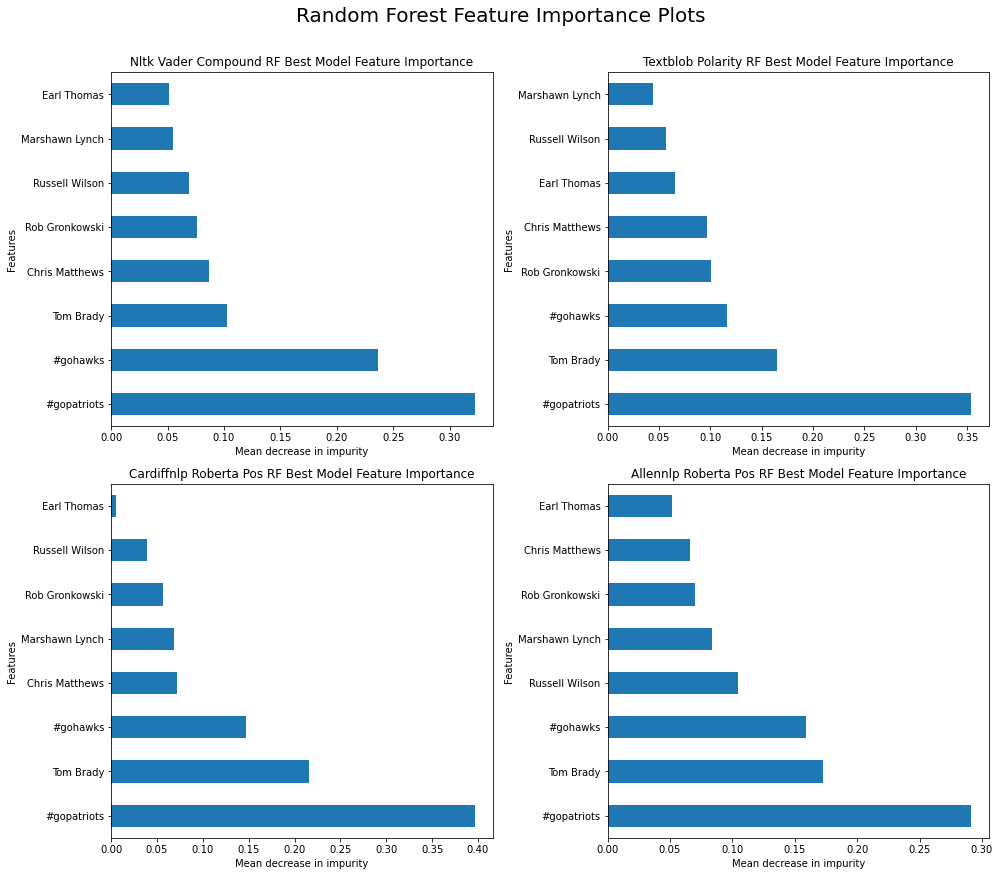

In [99]:
def feat_importance(clf, X, ax_ind):
    importances = clf.feature_importances_
    feature_names = X.columns
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances.sort_values(ascending=False, inplace=True)
    forest_importances.plot.barh(ax=ax_ind)
    ax_ind.set_xlabel("Mean decrease in impurity")
    ax_ind.set_ylabel("Features")
    return forest_importances

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
plt.suptitle(f'Random Forest Feature Importance Plots', fontsize=20, y=1.01)
for st , ax_ind in zip(exp_res_df_50.keys(), ax.ravel()):
    sent_name = ' '.join(st.split('_')[1:-2]).title()

    X_rf_train = exp_res_df_50[st]['X_train']
    rf_clf = exp_res_df_50[st]['rf_cv_search'].best_estimator_['model']
    forest_importances = feat_importance(clf=rf_clf, X=X_rf_train, ax_ind=ax_ind)
    ax_ind.set_title(f'{sent_name} RF Best Model Feature Importance')
fig.tight_layout()
plt.show()

In [100]:
players_df.columns

Index(['Player', 'Pos', 'Team', 'espn_team_list', 'Abbreviation', 'Position',
       'Category', 'player_first_name', 'player_last_name'],
      dtype='object')

In [101]:
cls = ['Player', 'Pos', 'Team', 'espn_team_list', 'Abbreviation', 'Position',
       'Category']
players_df[cls][players_df.Player.isin(['Chris Matthews', 'Earl Thomas', 
                                   'Marshawn Lynch', 'Rob Gronkowski', 
                                   'Russell Wilson', 'Tom Brady'])]

Player Pos      Team  espn_team_list Abbreviation       Position  \
0        Tom Brady  QB  Patriots            True           QB    Quarterback   
4   Rob Gronkowski  TE  Patriots            True           TE      Tight End   
21  Russell Wilson  QB  Seahawks            True           QB    Quarterback   
22  Marshawn Lynch  RB  Seahawks            True           RB   Running Back   
42     Earl Thomas  FS  Seahawks            True           FS    Free Safety   
46  Chris Matthews  WR  Seahawks            True           WR  Wide Receiver   

   Category  
0   Offense  
4   Offense  
21  Offense  
22  Offense  
42  Defense  
46  Offense

Overall, we see that #gohawks and #gopatriots are the two columns that have high influence on the model results.
We can see that Tom Brady is the player who has the most importance in all 4 models independent of which feature set we use. 

When we check AllenNLP RF feature importances, what I see is that the paired most important players shown in order. The first two most important players are Tom Brady and his counterpart Russell Wilson, following them Marshawn Lynch and his Patriots counterpart Rob Gronkowski. TexBlob, seems to put more importance on Patriots' players.

Best Model we found was CardiffNLP's Random Forest: We can see that for this model the second most important feature and most important player is Tom Brady. Followed by, Chris Matthews, Marshawn Lynch, Rob Gronkowski and Russell Wilson. 

Can we guess who might be the MVP of the game by looking at the Random Forests' importance for each model? All seems to point Tom Brady and indeed he was the MVP. If we look at the department of each player can we also guess who might be best Receiver and Defense player? For the CardiffNLP feature set, the second most important player is Chris Matthews,  he is a receiver from Seahawks, when I check the Team Stats from ESPN site, he is indeed the Game Leader for Receiving Yards for Seahawks, and has one of the best stats makes him a good candidate for best receiver. The third importan player is Marshawn Lynch, who is also selected as Rushing Leader of the Game for his team and has better game stats than his Patriots counterpart, L. Blount. 

##### __LR coeff plots for each Sentiment type__

In this part, we show the coefficient plots of each class for best LR models' on each feature type. I only show non-zero coefficients in the plot.

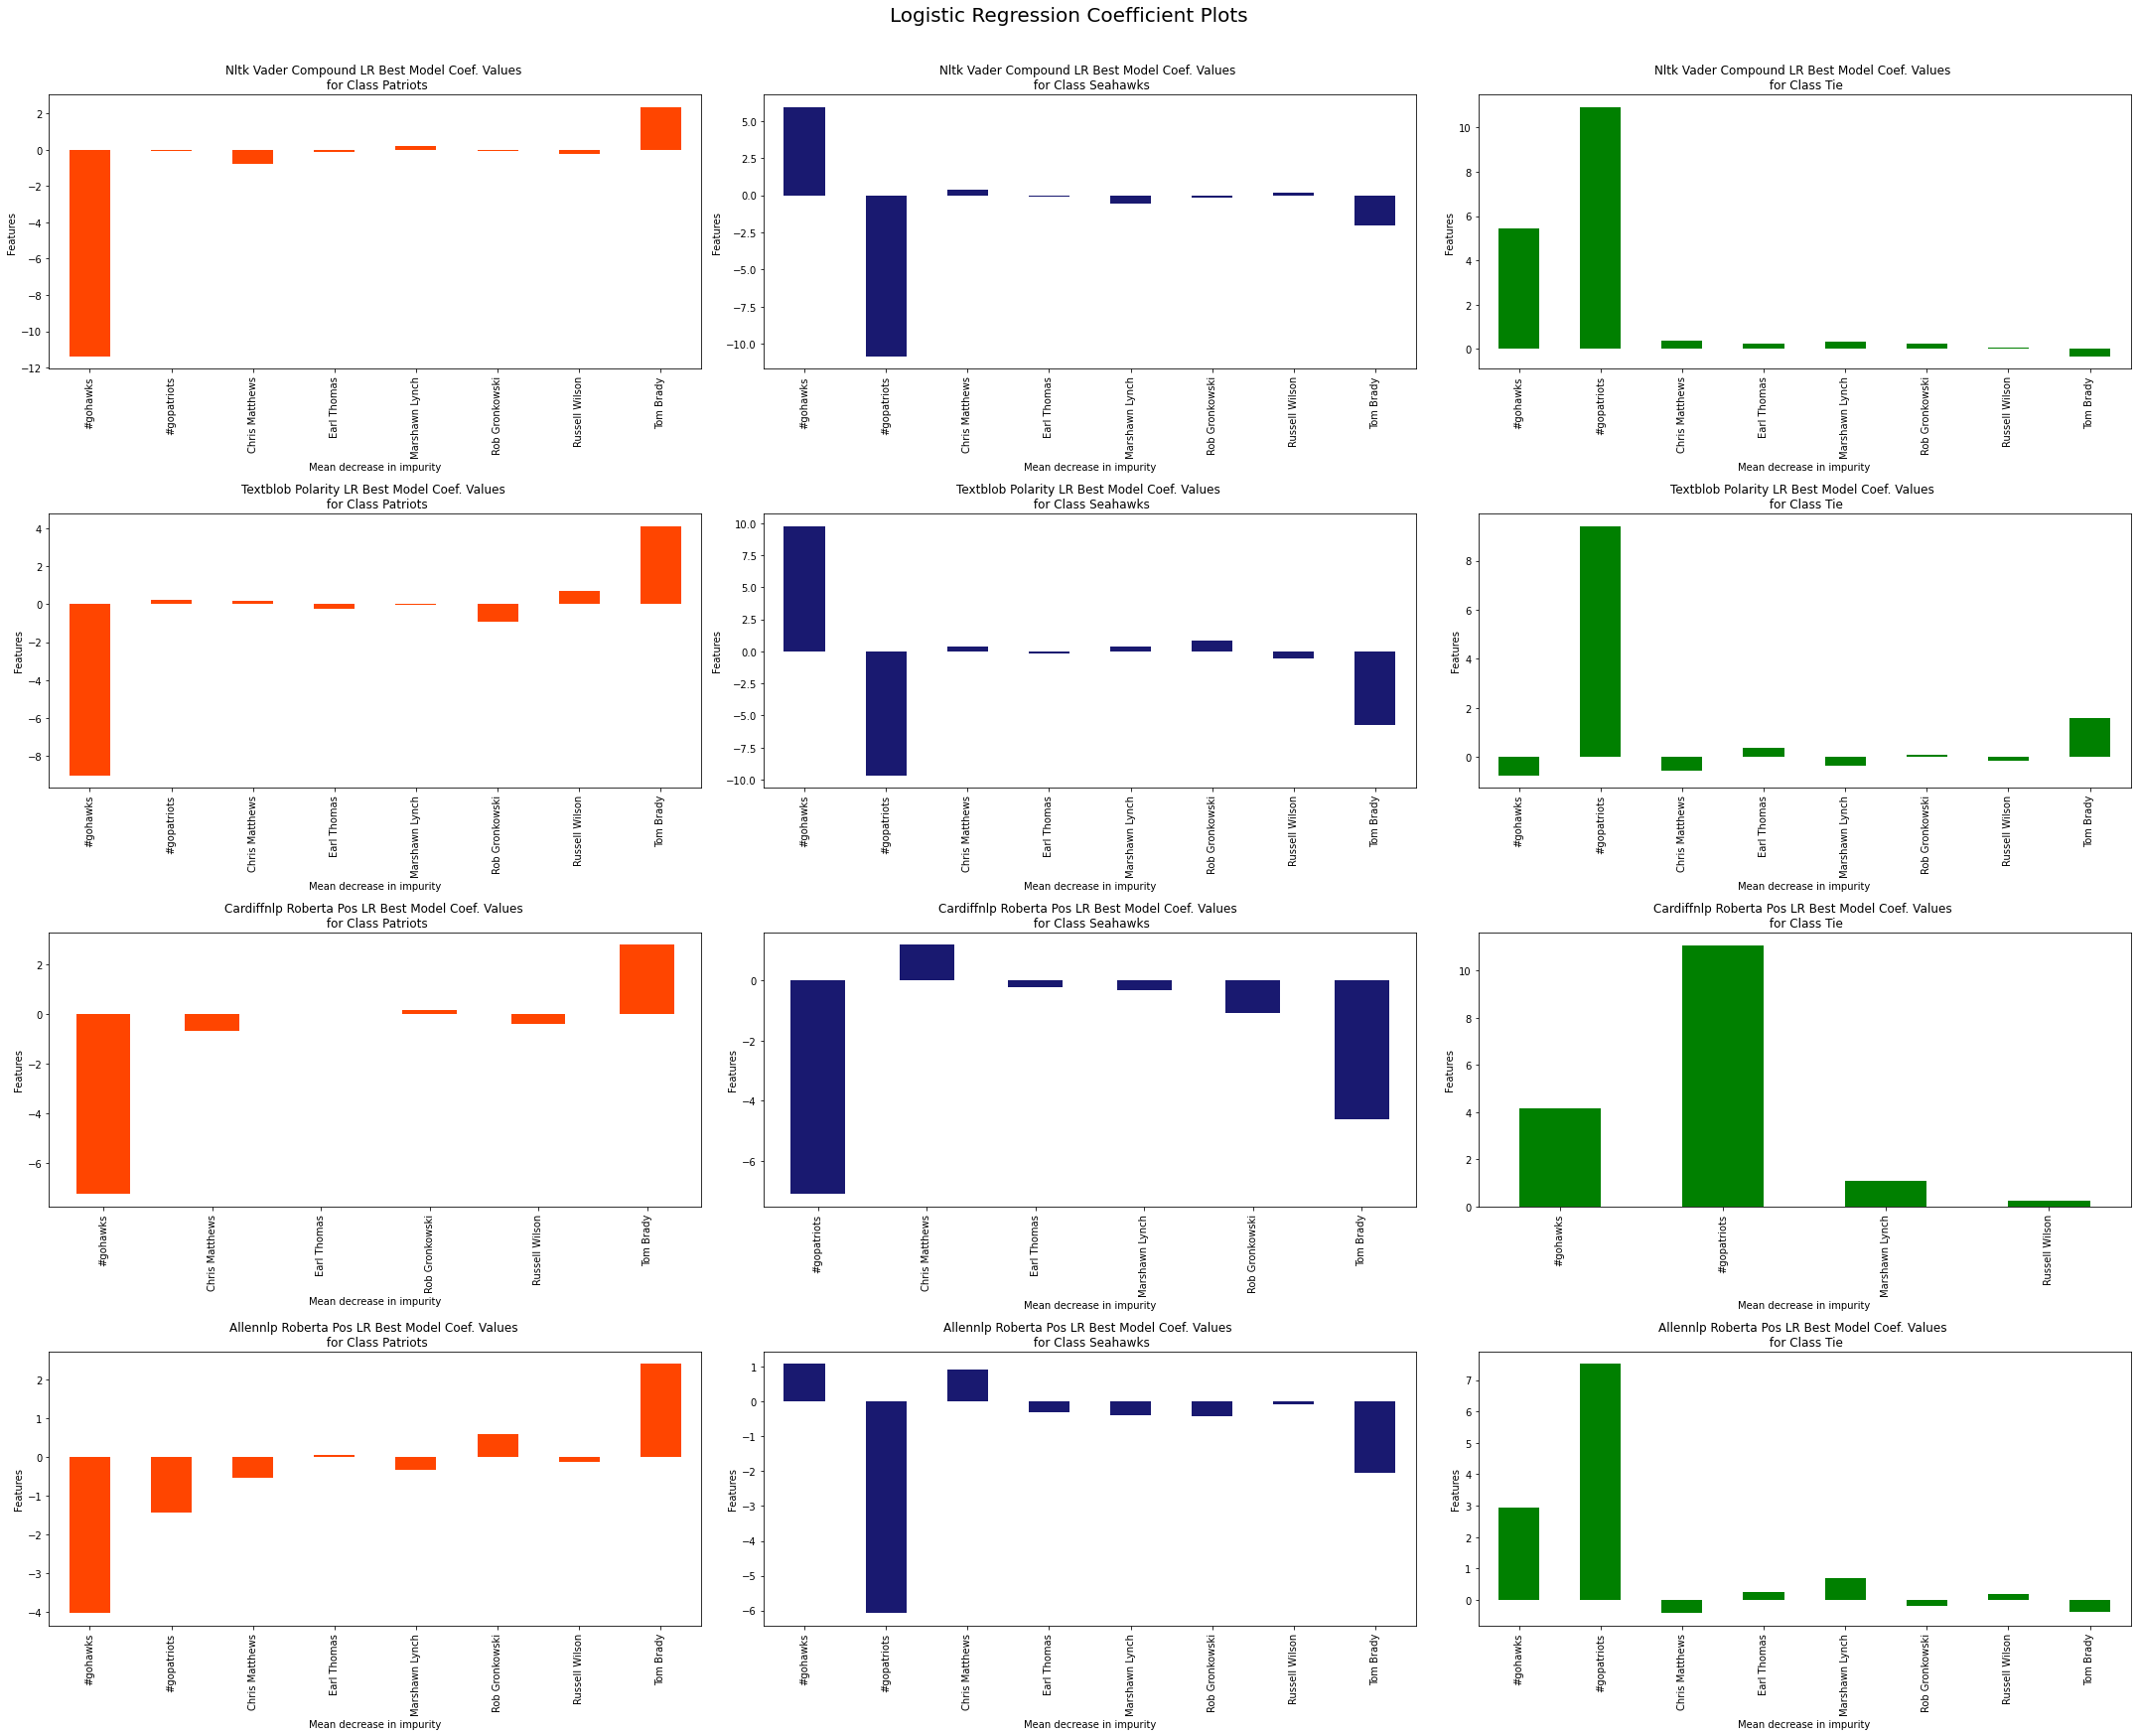

In [102]:
def coef_plot(clf, X, ax_ind, lbl, c):
    coeffs = pd.DataFrame(clf.coef_.T, columns=clf.classes_)
    coeffs['features'] = X.columns
    coeffs = coeffs.set_index('features')
    coeffs[coeffs[lbl]!=0][lbl].plot(kind="bar", ax=ax_ind, color=c)
    ax_ind.set_xlabel("Mean decrease in impurity")
    ax_ind.set_ylabel("Features")
    return coeffs


fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(30,24))
plt.suptitle(f'Logistic Regression Coefficient Plots', fontsize=20, y=1.01)
axs = ax.ravel()
ind = 0
for st in exp_res_df_50.keys():
    sent_name = ' '.join(st.split('_')[1:-2]).title()
    
    X_lr_train = exp_res_df_50[st]['X_train']
    lr_clf = exp_res_df_50[st]['lr_cv_search'].best_estimator_['model']
    for lbl, c in zip(['Patriots', 'Seahawks', 'Tie'], ['orangered', 'midnightblue', 'green']):
        coef_plot(clf=lr_clf, X=X_lr_train, ax_ind=axs[ind], lbl=lbl, c=c)
        axs[ind].set_title(f'{sent_name} LR Best Model Coef. Values \n for Class {lbl}')
        ind+=1
fig.tight_layout()
plt.show()

- We can see that in all 4 feature sets, Tom Brady get the highest positive coeff value for assigning Patriots as leading game, and highest negative coeff value for class Seahawks. For Tie assignment, Tom Brady is not as important.


Patriots Coefficients:
- In all 4 models, negative #gohawks and positive Tom Brady coeffs are found the most relevant informations for assigning Patriots as class. This means there is a negative correlation on positive overall positive Seahawks team and positive correlation on positive Tom Brady sentiments to predict Patriots leading the game. One interesting thing is that AllenNLP was able to catch correct players for each team: assigned positive coeff. values to Patriots players and negative coeff. values to Seahawks players


Seahawks Coefficients:
- We can see Tom Brady as the highest negative coeff. value for the players for all 4 LR model coefficients on assigning Seawhawks class. In all 4 models, the prediction is mainly driven on overall team emotions and Tom Brady. One interesting thing to notice is that both of the Roberta feature sets gave a higher positive value to Chris Matthews (and also only positive coeff. to a player). We can interpret this as perceived emotion against Chris Matthews is positively correlated in predicting the times when Seahawks leading the game and Chris Matthews played an important role as a receiver for Seahawks team for them to score.


Overall, from these plots, if we would guess and MVP it would be Tom Brady, who had high absolute value of coefficient amongs all players for each class. Chris Matthews can potentially be selected as best receiver for the Seahawks team.

## Conclusion

I learned more about American Football, Patriots and Seahawks than I could ever imagine. Probably now I should go and try to see a game. The results for both Character-Centric Time-Series Tracking and Winner Prediction tasks were very interesting and full of insights. Fan based emotions about players in time windows are indeed good signals for understanding game status, scores and even the MVP of the game. Can we tell which feature type is better for the two tasks? For the Character-Centric Time-Series Tracking, both of the Roberta models offer more accurate and relevant correlations between scores and the emotions perceived by fans for players and teams. Rule-based nltk and textblob, seems to underperform compared the other two feature types, textblob seem to be the worst one, in this context and dataset. For Winner Prediction task in a given time interval, CardiffNLP seem to be the best performing feature set combined with a Random Forest model that leads almost 75% validation and 79.5% test accuracy.

This project should be taken as an preliminary exploration for the given tasks and can be improved in many different ways, we can deep dive even further in almost every step. 


### Appendix

#### __Winner Prediction Experiments with different number of players__

##### __Results for experiment with 30% density requirement on columns__

In [103]:
exp_res_df_30 = experiment(col_drop_level=0.3, print_stat=True)
piv_res_30, res_table_30 = create_res_table(exp_results=exp_res_df_30)
display(piv_res_30)

-- Info about data: 

X shape: (216, 11)


'Class Distribution:'

Tie         98
Patriots    67
Seahawks    51
Name: leading, dtype: int64

'Class Distribution (normalized):'

Tie         0.453704
Patriots    0.310185
Seahawks    0.236111
Name: leading, dtype: float64

	Dropped columns where less than 30.0% is empty
	X shape after dropping columns: (216, 11)
        Remaining columns:                  ['#gohawks',
'#gopatriots', 'Chris Matthews', 'Earl Thomas', 'Jamie Collins',
'Julian Edelman', 'Marshawn Lynch', 'Richard Sherman', 'Rob
Gronkowski', 'Russell Wilson', 'Tom Brady']
	Filling NaN emotions scores with 0..
Model Experiments for : sent_nltk_vader_compound_1_mins data: 
Model Experiments for : sent_textblob_polarity_1_mins data: 
Model Experiments for : sent_cardiffnlp_roberta_pos_1_mins data: 
Model Experiments for : sent_allennlp_roberta_pos_1_mins data: 


Mean Train Score               Mean Validation Score  \
Model Name                           LR     NN     RF                    LR   
Sentiment Feature                                                             
Nltk Vader Compound               0.716  0.711  1.000                 0.656   
Textblob Polarity                 0.660  0.713  0.988                 0.623   
Cardiffnlp Roberta Pos            0.738  0.650  0.983                 0.675   
Allennlp Roberta Pos              0.735  0.615  0.990                 0.669   

                                     Mean Test Score                
Model Name                 NN     RF              LR     NN     RF  
Sentiment Feature                                                   
Nltk Vader Compound     0.616  0.750           0.773  0.682  0.727  
Textblob Polarity       0.605  0.727           0.705  0.614  0.705  
Cardiffnlp Roberta Pos  0.583  0.750           0.727  0.727  0.773  
Allennlp Roberta Pos    0.528  0.722           0.682  0.500  0.659

##### __Results for experiment with 80% density requirement on columns__

In [104]:
exp_res_df_80 = experiment(col_drop_level=0.8, print_stat=True)
piv_res_80, res_table_80 = create_res_table(exp_results=exp_res_df_80)
display(piv_res_80)

-- Info about data: 

X shape: (216, 5)


'Class Distribution:'

Tie         98
Patriots    67
Seahawks    51
Name: leading, dtype: int64

'Class Distribution (normalized):'

Tie         0.453704
Patriots    0.310185
Seahawks    0.236111
Name: leading, dtype: float64

	Dropped columns where less than 80.0% is empty
	X shape after dropping columns: (216, 5)
        Remaining columns:                  ['#gohawks',
'#gopatriots', 'Rob Gronkowski', 'Russell Wilson', 'Tom Brady']
	Filling NaN emotions scores with 0..
Model Experiments for : sent_nltk_vader_compound_1_mins data: 
Model Experiments for : sent_textblob_polarity_1_mins data: 
Model Experiments for : sent_cardiffnlp_roberta_pos_1_mins data: 
Model Experiments for : sent_allennlp_roberta_pos_1_mins data: 


Mean Train Score               Mean Validation Score  \
Model Name                           LR     NN     RF                    LR   
Sentiment Feature                                                             
Nltk Vader Compound               0.702  0.709  0.767                 0.685   
Textblob Polarity                 0.686  0.694  0.860                 0.669   
Cardiffnlp Roberta Pos            0.745  0.682  0.770                 0.721   
Allennlp Roberta Pos              0.715  0.645  0.921                 0.693   

                                     Mean Test Score                
Model Name                 NN     RF              LR     NN     RF  
Sentiment Feature                                                   
Nltk Vader Compound     0.644  0.732           0.773  0.750  0.705  
Textblob Polarity       0.658  0.692           0.727  0.682  0.682  
Cardiffnlp Roberta Pos  0.645  0.751           0.750  0.523  0.682  
Allennlp Roberta Pos    0.617  0.710           0.727  0.523  0.682